# NOTEBOOK USED FOR TROUBLESHOOTING RIGS

Modified from notebooks\BehaviorAnalysis\General\SummaryTodayTraining.ipynb

In [2]:
# DEFINITIONS CELL
import aind_vr_foraging_analysis.utils as processing
from aind_vr_foraging_analysis.utils.parsing import data_access

# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os
import json
from pathlib import Path

# sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle

verbose = True

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4="#ffec45"
odor_list_color = [color1, color2, color3, color4]

pdf_path = r'C:\Data\pdfs'
foraging_figures = r'C:\Data\tests\img'

color_dict_label = {'InterSite': '#808080',
    'InterPatch': '#b3b3b3', 
    'PatchZ': '#d95f02', 'PatchZB': '#d95f02', 
    'PatchB': '#d95f02','PatchA': '#7570b3', 
    'PatchC': '#1b9e77',
    'Alpha-pinene': '#1b9e77', 
    'Methyl Butyrate': '#7570b3', 
    'Amyl Acetate': '#d95f02', 
    'Fenchone': '#7570b3', 
    'S': color1,
    'D': color2,
    'N': color3,
    'odor_0': color3,
    'odor_60': color2,
    'odor_90':color1,
    'odor_fast': color2,
    'odor_slow': color3
    }

label_dict = {**{
"InterSite": '#808080',
"InterPatch": '#b3b3b3'}, 
            **color_dict_label}

In [3]:
# FUNCTIONS

# LOAD AND PARSE DATA
from aind_vr_foraging_analysis.utils.parsing.parse import ContinuousData

def load_session(path: Path) -> list[pd.DataFrame, ContinuousData, dict, pd.DataFrame, pd.DataFrame]:
    """Gets all the datastreams from a directory"""
    try:
        all_epochs, stream_data, data = data_access.load_session(path, extra=True)
        odor_sites = all_epochs.loc[all_epochs['label'] == 'OdorSite']
        odor_triggers = stream_data.odor_triggers
    except Exception as e:
            print(f"Error loading a behavior session in {path.name}: {e}")
    return all_epochs, stream_data, data, odor_sites, odor_triggers

def load_streams_from_harp(data:dict, harp:str, list_of_stream_names:list[str], drop:list[str] = ["MessageType"]) -> dict[str, dict[str, str]]:
    """
    Collect a list of data streams from a specific harp device.

    Parameters
    ----------
    data : dict
        Dictionary of harp devices (e.g., data["harpX"]).
    stream_names : list[str]
        List of stream names to extract (e.g., ["WhoAmI", "HardwareVersionHigh"]).
    drop : List[str] | None (optional)
        List of columns to not collect

    Returns
    -------
    dict
        Nested dictionary: {harp_name: {stream_name: stream_values}}
    """
    stream_dict = {}
    for stream_name in list_of_stream_names:
        data[harp].streams[stream_name].load_from_file()
        stream_dict[stream_name]= data[harp].streams[stream_name].data.drop(columns=drop, errors="ignore")
    return stream_dict

def preload_some_streams(data: dict) -> dict[str, dict[str, str]]:
    """  Function used to preload the streams that will be used later    """
    
    olf_streams_lst = ["Flowmeter", "EndValveState", "OdorValveState",
                "Channel0ActualFlow", "Channel1ActualFlow", "Channel2ActualFlow", "Channel3ActualFlow","Channel4ActualFlow"]
    treadmill_streams_lst = ["Encoder", "Torque", "SensorData"]
    evnts_streams_lst= ["ActivePatch", "ActiveSite", "ArmOdor", "GlobalPatchState", "PatchStateAtReward"]

    envmt_stream = load_streams_from_harp(data, "harp_environment_sensor", ["SensorData"])  
    olf_streams = load_streams_from_harp(data, "harp_olfactometer", olf_streams_lst)        
    treadmill_streams = load_streams_from_harp(data, "harp_treadmill", treadmill_streams_lst)
    sw_events_streams = load_streams_from_harp(data, "software_events", evnts_streams_lst, ["dataType", "data_type_hint", "timestamp_source"])
    
    return envmt_stream, olf_streams, treadmill_streams, sw_events_streams

def collect_value_across_all_harps(data: dict, stream_name_list: list[str]) -> dict:
    """
    Collect individual value from specified streams across all harp devices.

    Parameters
    ----------
    data : dict
        Dictionary of harp devices (e.g., data["harpX"]).
    stream_names : list[str]
        List of stream names to extract (e.g., ["WhoAmI", "HardwareVersionHigh"]).

    Returns
    -------
    dict
        Nested dictionary: {harp_name: {stream_name: stream_value}}
    """
    results = {}

    for harp_name, harp_obj in data.items():
        if harp_name.startswith("harp"):
            harp_results = {}
            for stream in stream_name_list:
                try:
                    stream_obj = harp_obj.streams[stream]
                    # Try load_from_file first
                    value = stream_obj.load_from_file()
                    if value is None or hasattr(value, "empty"):
                        # Fallback to .data
                        value = stream_obj.data
                    # If it's a DataFrame, extract the first value
                    if hasattr(value, "iloc"):
                        try:
                            scalar = value.iloc[0, 0]
                        except Exception:
                            scalar = value
                        harp_results[stream] = scalar
                    else:
                        harp_results[stream] = value
                except Exception as e:
                    harp_results[stream] = f"Error: {e}"
            results[harp_name] = harp_results
    return results

#-----------------------------------------------------

# METRICS CALCULATION AND DATA SLICING

def slice_stream_in_equal_slices(df: pd.DataFrame, n: int, func, decimals: int | None = None, normalize: bool = True) -> dict[str, float]:
    """Split df into n equal-duration time windows using the float index (seconds), compute a metric per window (and 'Full'), optionally normalize by minutes."""
    if n <= 0: raise ValueError("n must be > 0")
    if df.empty: raise ValueError("df must not be empty")

    def _to_scalar(x) -> int|float:
        if isinstance(x, (pd.Series, pd.DataFrame)):
            return x.mean().mean()
        return x

    start = float(df.index.min())
    end = float(df.index.max())
    if not np.isfinite(start) or not np.isfinite(end):
        raise ValueError("Index must contain finite numeric timestamps")
    total_span = end - start
    if total_span <= 0:
        raise ValueError("Index span must be positive (max > min)")
    total_minutes = total_span / 60.0

    results: dict[str, float] = {}

    # Full dataset
    full_raw = _to_scalar(func(df))
    denom = total_minutes if normalize else 1.0
    full_val = full_raw / denom
    if decimals is not None:
        full_val = round(float(full_val), decimals)
    results["Full"] = full_val
    if verbose:     
        print(f"Full dataset: {full_val} (computed as {full_raw} / minutes={total_minutes})") if normalize else print(f"Full dataset: {full_val}")

    # Equal-duration time windows (based on index range)
    edges = np.linspace(start, end, n + 1)
    for i in range(n):
        left, right = float(edges[i]), float(edges[i + 1])
        if right <= left:
            continue

        mask = (df.index >= left) & (df.index < right if i < n - 1 else df.index <= right)
        part = df.loc[mask]
        if part.empty:
            continue

        window_minutes = (right - left) / 60.0
        slice_raw = _to_scalar(func(part))
        denom = window_minutes if normalize else 1.0
        val = round(slice_raw / denom, decimals)

        start_pct = int(round(i * 100 / n))
        end_pct = int(round((i + 1) * 100 / n))

        label = f"{start_pct}-{end_pct}%"
        if verbose:     
            print(f"Slice dataset: {val} (computed as {slice_raw} / {(window_minutes)}min)") if normalize else print(f"Slice dataset: {val}")
        results[label] = val

    return results

def slice_stream_by_minutes(df: pd.DataFrame, window_minutes: float, func, decimals: int | None = None, normalize: bool = True) -> dict[str, float]:
    """Split df into fixed-duration windows of `window_minutes` (index in seconds), compute a metric per window and 'Full', optionally normalize by minutes."""
    if window_minutes <= 0:
        raise ValueError("window_minutes must be > 0")
    if df.empty:
        raise ValueError("df must not be empty")

    def _to_scalar(x) -> float:
        if isinstance(x, (pd.Series, pd.DataFrame)):
            return x.mean().mean()
        return x

    def _fmt(m) -> str:
        return str(int(m)) if float(m).is_integer() else f"{m:.1f}".rstrip("0").rstrip(".")

    start = float(df.index.min())
    end = float(df.index.max())
    if not np.isfinite(start) or not np.isfinite(end):
        raise ValueError("Index must contain finite numeric timestamps (seconds)")
    total_span = end - start
    if total_span <= 0:
        raise ValueError("Index span must be positive (max > min)")
    total_minutes = total_span / 60.0

    results: dict[str, float] = {}

    # Full dataset
    full_raw = _to_scalar(func(df))
    denom = total_minutes if normalize else 1.0
    full_val = full_raw / denom
    if decimals is not None:
        full_val = round(float(full_val), decimals)
    results["Full"] = full_val
    if verbose:     
        print(f"Full dataset: {full_val} (computed as {full_raw} / minutes={total_minutes})") if normalize else print(f"Full dataset: {full_val}")

    # Fixed-duration windows
    start_min = 0.0
    while start_min < total_minutes:
        end_min = start_min + window_minutes
        left = start + start_min * 60.0
        right = start + end_min * 60.0

        # Include right edge only for the last window
        is_last = end_min >= total_minutes
        mask = (df.index >= left) & (df.index < right if not is_last else df.index <= right)
        part = df.loc[mask]
        if not part.empty:
            duration_minutes = (right - left) / 60.0
            if duration_minutes > 0:
                slice_raw = _to_scalar(func(part))
                denom = duration_minutes if normalize else 1.0
                val = slice_raw / denom
                if decimals is not None:
                    val = round(float(val), decimals)
                label = f"{_fmt(start_min)}-{_fmt(end_min)}"
                if verbose:     
                    print(f"Slice dataset: {val} (computed as {slice_raw} / {duration_minutes}min)") if normalize else print(f"Slice dataset: {val}")
                
                results[label] = val

        start_min = end_min

    return results

def summarize_task(data, odor_sites, envmt_stream, olf_streams, treadmill_streams) -> dict [str]:

    def merge_dicts(**dicts) -> dict:
        from collections import defaultdict
        merged = defaultdict(dict)
        for name, d in dicts.items():
            for slice_key, value in d.items():
                merged[slice_key][name] = value
        return dict(merged)

    # Odor sites
    total_harvest_attempts = odor_sites.loc[(odor_sites['is_choice']==True)]['reward_available'].count()
    rewarded = odor_sites.loc[odor_sites.is_reward==1]['is_choice'].count()
    rewarded_perc = round((rewarded/total_harvest_attempts)*100,2)
    unrewarded = odor_sites.loc[(odor_sites.is_reward==0 ) & (odor_sites['is_choice']==True)]['is_choice'].count()
    unrewarded_perc = round((unrewarded/total_harvest_attempts)*100,2)
    water_collected = odor_sites.loc[(odor_sites['is_reward']==1)]['reward_amount'].sum()
    
    # Operation control
    total_stops = data["operation_control"].streams["IsStopped"].data["IsStopped"].sum()
    stops = data["operation_control"].streams["IsStopped"].data["IsStopped"].reset_index()
    stops['index_diff'] = abs(stops['Seconds'].diff(-1).fillna(0))
    stopped_t = stops.groupby('IsStopped')['index_diff'].sum().iloc[1]

    seconds_per_stop = stops.groupby('IsStopped')['index_diff'].nth(1).agg(['max', 'min', 'mean', 'std']).to_dict()
    
    total_travelled = data["operation_control"].streams["CurrentPosition"].data["Position"].max().round(0)/100
    
    # Odor-specific water amounts
    odor_rewards = {
        odor_label: odor_sites.loc[
            (odor_sites['odor_label'] == odor_label) & (odor_sites['is_reward'] == 1),
            'reward_amount'
        ].sum()
        for odor_label in odor_sites.odor_label.unique()
    }

    # Environment data
    envmt_cols = ["Pressure", "Temperature", "Humidity"]
    envmt_dict = envmt_stream["SensorData"].loc[:, envmt_cols].agg(['max', 'min', 'mean', 'std']).to_dict()
    
    # Olfactometer data
    olf_cols = [ "Channel0ActualFlow", "Channel1ActualFlow", "Channel2ActualFlow", "Channel3ActualFlow", "Channel4ActualFlow"]
    olfactometer_dict = pd.concat([olf_streams[col][[col]] for col in olf_cols], axis=1).agg(['max', 'min', 'mean', 'std']).to_dict()
    
    # Treadmill data
    tdmll_cols = ["Encoder", "Torque", "TorqueLoadCurrent", "velocity", "distance", "filtered_velocity"]
    treadmill_dict = treadmill_streams["SensorData"].loc[:, tdmll_cols].agg(['max', 'min', 'mean', 'std']).to_dict()
    
    #Using encoder data to calculate the session duration, as it has data across the whole session without interruptions (like the olfactometer streams)
    time_sec = float(treadmill_streams["SensorData"]["Encoder"].index.max() - treadmill_streams["SensorData"]["Encoder"].index.min())
    minutes = round(time_sec / 60 , 2)

    
    # Slices
    n = 5 #Minutes for each slice
    slice_dict = merge_dicts(
        rewarded_stops=slice_stream_by_minutes(odor_sites['is_choice'], n, sum, decimals=2, normalize=False),
        unrewarded_stops=slice_stream_by_minutes(odor_sites.loc[(odor_sites.is_reward==0 ) & (odor_sites['is_choice']==True)]['is_choice'], n, sum, decimals=2, normalize=False),
        total_harvest_attempts=slice_stream_by_minutes(odor_sites.loc[odor_sites['is_choice']==True]['reward_available'], n, lambda x: x.count(), decimals=2, normalize=False),
        total_stops=slice_stream_by_minutes(data["operation_control"].streams["IsStopped"].data["IsStopped"], n, sum, decimals=2, normalize=False),
        water_collected=slice_stream_by_minutes(odor_sites.loc[odor_sites['is_reward']==1]['reward_amount'], n, sum, decimals=2, normalize=False),
        travelled=slice_stream_by_minutes((data["operation_control"].streams["CurrentPosition"].data["Position"]/100), n, lambda x: x.max()-x.min(), decimals=2, normalize=False)
    )

    # Final dictionary
    summary = {
        "task": {
            "minutes": minutes,
            "total_sites/min": len(odor_sites)/minutes,
            "total_harvest_attempts/min": total_harvest_attempts/minutes,
            "total_stops/min": total_stops/minutes,
            "rewarded_stops": rewarded/minutes,
            "rewarded_stops_perc": rewarded_perc,
            "unrewarded_stops": unrewarded/minutes,
            "unrewarded_stops_perc": unrewarded_perc,
            "water_collected_ul": water_collected,
            "total_travelled_m": total_travelled,
            # "odor_rewards": odor_rewards,
            "stopped_t": stopped_t
        },
        "seconds_per_stop": seconds_per_stop,
        "environment": envmt_dict,
        "olfactometer": olfactometer_dict,
        "treadmill": treadmill_dict,
        "Slices": slice_dict
    }
    print(summary)
    return summary


#-----------------------------------------------------

#SAVING DATA
def save_json(dict:dict, path:str) -> None:
    with open(os.path.join(path,'summary.json'), 'w') as fp:
        json.dump(dict, fp, indent=4, default=int)

#-----------------------------------------------------
# PLOTTING HELPERS
def annotate_points(ax: plt.Axes, x: list, y: list, tags: list | None, fontsize: int = 15, color: str = 'black') -> None:
    """Annotate (x, y) points with text tags on a Matplotlib Axes."""
    if tags is not None:
        for xi, yi, tag in zip(x, y, tags):
            if pd.notna(yi):
                ax.annotate(str(tag), (xi, yi), textcoords="offset points", xytext=(3, 5), fontsize=fontsize, alpha=0.9, color=color)


# **One session exploration**

In [ ]:
# Generates the summary in a single session
path = Path(r"C:\Data\tests\828423_2025-12-04T010903Z")

all_epochs, stream_data, data, odor_sites, odor_triggers = load_session(path)

envmt_stream, olf_streams, treadmill_streams, sw_events_streams = preload_some_streams(data)
summary = summarize_task(data, odor_sites,envmt_stream, olf_streams, treadmill_streams)
summary["versions"] = collect_value_across_all_harps(data, ["HardwareVersionHigh", "HardwareVersionLow", "AssemblyVersion", "FirmwareVersionHigh", "FirmwareVersionLow"])
save_json(summary, path)

In [ ]:
#Run this cell for more info about the available datastreams and how to access them
# Also see: https://allenneuraldynamics.github.io/Aind.Behavior.VrForaging/dataset.html 
print("Contents in data available:")
for key, value in data.items():
    print(key, "-",value)

print(f"--------------------\nContents from the '{key}' DataStreamSource-> {data[key].streams} \n-----------------------" )

print("The DataStreamSource is iterable and will contain DataStreamType.XXXX streams:")
for element in data[key].streams:    
    print(data[key].streams[element])  

print(f"If trying to access a stream results in this message: 'DataStreamType.XXXX' stream with None/Not loaded entries\n", 
      "You need to load it first using .load_from_file() method, or access through the property .data, that will load it too")
print(f"data[key].streams[element].data or data[key].streams.element.data can be used. example:", data[key].streams[element].data)


In [ ]:
# Extra cell used to check a specific DataStream if needed
# data["harp_olfactometer"].streams["EnableFlow"].load_from_file()
data["software_events"].streams
data["software_events"].streams["WaitRewardOutcome"].data

["ActivePatch", "ActiveSite", "ArmOdor", "GlobalPatchState", "PatchStateAtReward"]



# Multi Sessions in the same directory

RUN THE FOLLOWING CELL FOR SAVING A SUMMARY OF THE SESSION IN EVERY FOLDER OF A GIVEN PATH

In [4]:
main_path = Path(r"C:/Data/tests")

rewrite = True # Set to False to skip analysis if summary.json already exists in session folder

dirs = [os.path.join(main_path, name) for name in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, name))]
print(dirs)


for path in dirs:
    summary_path = os.path.join(path, "summary.json")
    if os.path.exists(summary_path) and not rewrite:
        print(f"{summary_path} already exists. Skipping analysis")
        continue
    all_epochs, stream_data, data, odor_sites, odor_triggers = load_session(path)
    envmt_stream, olf_streams, treadmill_streams, sw_events_streams = preload_some_streams(data)
    summary = summarize_task(data, odor_sites,envmt_stream, olf_streams, treadmill_streams)
    save_json(summary, path)
    print(f"Analysis made and stored as {summary_path}")

['C:\\Data\\tests\\828423_2026-01-08T222155Z', 'C:\\Data\\tests\\828423_2026-01-09T220200Z', 'C:\\Data\\tests\\828423_2026-01-12T220554Z', 'C:\\Data\\tests\\828423_2026-01-13T220622Z', 'C:\\Data\\tests\\828423_2026-01-14T222311Z', 'C:\\Data\\tests\\828423_2026-01-15T220910Z', 'C:\\Data\\tests\\828423_2026-01-17T002554Z', 'C:\\Data\\tests\\828423_2026-01-19T201751Z', 'C:\\Data\\tests\\828423_2026-01-20T174842Z', 'C:\\Data\\tests\\828423_2026-01-20T222129Z', 'C:\\Data\\tests\\828423_2026-01-21T205933Z', 'C:\\Data\\tests\\828423_2026-01-22T221343Z', 'C:\\Data\\tests\\828423_2026-01-23T210156Z', 'C:\\Data\\tests\\828423_2026-01-26T201234Z', 'C:\\Data\\tests\\828423_2026-01-28T002110Z', 'C:\\Data\\tests\\828423_2026-01-28T203936Z', 'C:\\Data\\tests\\828423_2026-01-29T205811Z', 'C:\\Data\\tests\\828423_2026-01-30T210924Z', 'C:\\Data\\tests\\828423_2026-02-03T204810Z', 'C:\\Data\\tests\\828423_2026-02-04T220303Z', 'C:\\Data\\tests\\828423_2026-02-05T202723Z', 'C:\\Data\\tests\\828423_2026-02-

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 378.0
Slice dataset: 67.0
Slice dataset: 59.0
Slice dataset: 55.0
Slice dataset: 45.0
Slice dataset: 48.0
Slice dataset: 36.0
Slice dataset: 31.0
Slice dataset: 35.0
Slice dataset: 0.0
Slice dataset: 2.0
Full dataset: 157.0
Slice dataset: 39.0
Slice dataset: 27.0
Slice dataset: 27.0
Slice dataset: 18.0
Slice dataset: 20.0
Slice dataset: 7.0
Slice dataset: 9.0
Slice dataset: 9.0
Slice dataset: 1.0
Full dataset: 378.0
Slice dataset: 67.0
Slice dataset: 59.0
Slice dataset: 55.0
Slice dataset: 45.0
Slice dataset: 48.0
Slice dataset: 36.0
Slice dataset: 31.0
Slice dataset: 35.0
Slice dataset: 2.0
Full dataset: 543.0
Slice dataset: 81.0
Slice dataset: 86.0
Slice dataset: 89.0
Slice dataset: 75.0
Slice dataset: 66.0
Slice dataset: 48.0
Slice dataset: 41.0
Slice dataset: 38.0
Slice dataset: 14.0
Slice dataset: 5.0
Full dataset: 1105.0
Slice dataset: 155.0
Slice dataset: 150.0
Slice dataset: 135.0
Slice dataset: 135.0
Slice dataset: 145.0
Slic

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 414.0
Slice dataset: 62.0
Slice dataset: 58.0
Slice dataset: 57.0
Slice dataset: 53.0
Slice dataset: 52.0
Slice dataset: 50.0
Slice dataset: 44.0
Slice dataset: 36.0
Slice dataset: 2.0
Slice dataset: 0.0
Full dataset: 179.0
Slice dataset: 36.0
Slice dataset: 27.0
Slice dataset: 33.0
Slice dataset: 24.0
Slice dataset: 20.0
Slice dataset: 17.0
Slice dataset: 10.0
Slice dataset: 11.0
Slice dataset: 1.0
Full dataset: 414.0
Slice dataset: 62.0
Slice dataset: 58.0
Slice dataset: 57.0
Slice dataset: 53.0
Slice dataset: 52.0
Slice dataset: 50.0
Slice dataset: 44.0
Slice dataset: 36.0
Slice dataset: 2.0
Full dataset: 635.0
Slice dataset: 82.0
Slice dataset: 89.0
Slice dataset: 93.0
Slice dataset: 95.0
Slice dataset: 84.0
Slice dataset: 78.0
Slice dataset: 59.0
Slice dataset: 48.0
Slice dataset: 6.0
Slice dataset: 1.0
Full dataset: 1175.0
Slice dataset: 140.0
Slice dataset: 145.0
Slice dataset: 125.0
Slice dataset: 140.0
Slice dataset: 160.0
Sl

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 431.0
Slice dataset: 70.0
Slice dataset: 61.0
Slice dataset: 55.0
Slice dataset: 54.0
Slice dataset: 54.0
Slice dataset: 46.0
Slice dataset: 48.0
Slice dataset: 21.0
Slice dataset: 22.0
Full dataset: 164.0
Slice dataset: 32.0
Slice dataset: 29.0
Slice dataset: 24.0
Slice dataset: 16.0
Slice dataset: 21.0
Slice dataset: 17.0
Slice dataset: 17.0
Slice dataset: 4.0
Slice dataset: 4.0
Full dataset: 431.0
Slice dataset: 70.0
Slice dataset: 61.0
Slice dataset: 55.0
Slice dataset: 54.0
Slice dataset: 54.0
Slice dataset: 46.0
Slice dataset: 48.0
Slice dataset: 21.0
Slice dataset: 22.0
Full dataset: 566.0
Slice dataset: 76.0
Slice dataset: 79.0
Slice dataset: 85.0
Slice dataset: 71.0
Slice dataset: 78.0
Slice dataset: 54.0
Slice dataset: 54.0
Slice dataset: 29.0
Slice dataset: 35.0
Slice dataset: 5.0
Full dataset: 1335.0
Slice dataset: 190.0
Slice dataset: 165.0
Slice dataset: 155.0
Slice dataset: 185.0
Slice dataset: 165.0
Slice dataset: 145.

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 452.0
Slice dataset: 63.0
Slice dataset: 61.0
Slice dataset: 54.0
Slice dataset: 52.0
Slice dataset: 53.0
Slice dataset: 49.0
Slice dataset: 46.0
Slice dataset: 41.0
Slice dataset: 32.0
Slice dataset: 1.0
Full dataset: 184.0
Slice dataset: 29.0
Slice dataset: 30.0
Slice dataset: 25.0
Slice dataset: 26.0
Slice dataset: 22.0
Slice dataset: 16.0
Slice dataset: 19.0
Slice dataset: 10.0
Slice dataset: 7.0
Full dataset: 452.0
Slice dataset: 63.0
Slice dataset: 61.0
Slice dataset: 54.0
Slice dataset: 52.0
Slice dataset: 53.0
Slice dataset: 49.0
Slice dataset: 46.0
Slice dataset: 41.0
Slice dataset: 32.0
Slice dataset: 1.0
Full dataset: 733.0
Slice dataset: 84.0
Slice dataset: 105.0
Slice dataset: 91.0
Slice dataset: 92.0
Slice dataset: 83.0
Slice dataset: 72.0
Slice dataset: 77.0
Slice dataset: 61.0
Slice dataset: 54.0
Slice dataset: 14.0
Full dataset: 1340.0
Slice dataset: 175.0
Slice dataset: 150.0
Slice dataset: 145.0
Slice dataset: 130.0

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 349.0
Slice dataset: 62.0
Slice dataset: 56.0
Slice dataset: 54.0
Slice dataset: 51.0
Slice dataset: 50.0
Slice dataset: 39.0
Slice dataset: 22.0
Slice dataset: 15.0
Slice dataset: 0.0
Slice dataset: 0.0
Full dataset: 128.0
Slice dataset: 26.0
Slice dataset: 22.0
Slice dataset: 22.0
Slice dataset: 19.0
Slice dataset: 17.0
Slice dataset: 10.0
Slice dataset: 7.0
Slice dataset: 5.0
Full dataset: 349.0
Slice dataset: 62.0
Slice dataset: 56.0
Slice dataset: 54.0
Slice dataset: 51.0
Slice dataset: 50.0
Slice dataset: 39.0
Slice dataset: 22.0
Slice dataset: 15.0
Full dataset: 640.0
Slice dataset: 101.0
Slice dataset: 98.0
Slice dataset: 88.0
Slice dataset: 96.0
Slice dataset: 91.0
Slice dataset: 58.0
Slice dataset: 52.0
Slice dataset: 28.0
Slice dataset: 13.0
Slice dataset: 15.0
Full dataset: 1105.0
Slice dataset: 180.0
Slice dataset: 175.0
Slice dataset: 165.0
Slice dataset: 160.0
Slice dataset: 155.0
Slice dataset: 145.0
Slice dataset: 75.

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 351.0
Slice dataset: 59.0
Slice dataset: 56.0
Slice dataset: 49.0
Slice dataset: 50.0
Slice dataset: 46.0
Slice dataset: 37.0
Slice dataset: 21.0
Slice dataset: 13.0
Slice dataset: 18.0
Slice dataset: 2.0
Full dataset: 104.0
Slice dataset: 21.0
Slice dataset: 19.0
Slice dataset: 13.0
Slice dataset: 12.0
Slice dataset: 12.0
Slice dataset: 14.0
Slice dataset: 7.0
Slice dataset: 1.0
Slice dataset: 4.0
Slice dataset: 1.0
Full dataset: 351.0
Slice dataset: 61.0
Slice dataset: 56.0
Slice dataset: 49.0
Slice dataset: 50.0
Slice dataset: 46.0
Slice dataset: 37.0
Slice dataset: 20.0
Slice dataset: 12.0
Slice dataset: 18.0
Slice dataset: 2.0
Full dataset: 529.0
Slice dataset: 82.0
Slice dataset: 81.0
Slice dataset: 67.0
Slice dataset: 71.0
Slice dataset: 59.0
Slice dataset: 51.0
Slice dataset: 33.0
Slice dataset: 39.0
Slice dataset: 41.0
Slice dataset: 5.0
Full dataset: 1235.0
Slice dataset: 200.0
Slice dataset: 185.0
Slice dataset: 185.0
Slice

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 337.0
Slice dataset: 65.0
Slice dataset: 57.0
Slice dataset: 53.0
Slice dataset: 51.0
Slice dataset: 46.0
Slice dataset: 41.0
Slice dataset: 24.0
Full dataset: 119.0
Slice dataset: 31.0
Slice dataset: 21.0
Slice dataset: 20.0
Slice dataset: 12.0
Slice dataset: 15.0
Slice dataset: 14.0
Slice dataset: 6.0
Full dataset: 337.0
Slice dataset: 65.0
Slice dataset: 57.0
Slice dataset: 53.0
Slice dataset: 51.0
Slice dataset: 46.0
Slice dataset: 41.0
Slice dataset: 24.0
Full dataset: 404.0
Slice dataset: 84.0
Slice dataset: 76.0
Slice dataset: 69.0
Slice dataset: 54.0
Slice dataset: 52.0
Slice dataset: 42.0
Slice dataset: 27.0
Full dataset: 1090.0
Slice dataset: 175.0
Slice dataset: 175.0
Slice dataset: 165.0
Slice dataset: 195.0
Slice dataset: 160.0
Slice dataset: 130.0
Slice dataset: 90.0
Full dataset: 499.51
Slice dataset: 72.17
Slice dataset: 69.6
Slice dataset: 70.3
Slice dataset: 63.84
Slice dataset: 67.41
Slice dataset: 77.98
Slice datas

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 318.0
Slice dataset: 57.0
Slice dataset: 52.0
Slice dataset: 52.0
Slice dataset: 55.0
Slice dataset: 53.0
Slice dataset: 44.0
Slice dataset: 5.0
Full dataset: 135.0
Slice dataset: 29.0
Slice dataset: 21.0
Slice dataset: 24.0
Slice dataset: 28.0
Slice dataset: 21.0
Slice dataset: 12.0
Full dataset: 318.0
Slice dataset: 57.0
Slice dataset: 52.0
Slice dataset: 52.0
Slice dataset: 55.0
Slice dataset: 53.0
Slice dataset: 44.0
Slice dataset: 5.0
Full dataset: 433.0
Slice dataset: 78.0
Slice dataset: 83.0
Slice dataset: 77.0
Slice dataset: 68.0
Slice dataset: 65.0
Slice dataset: 50.0
Slice dataset: 12.0
Full dataset: 915.0
Slice dataset: 145.0
Slice dataset: 150.0
Slice dataset: 140.0
Slice dataset: 140.0
Slice dataset: 160.0
Slice dataset: 155.0
Slice dataset: 25.0
Full dataset: 453.33
Slice dataset: 59.45
Slice dataset: 61.68
Slice dataset: 59.49
Slice dataset: 56.76
Slice dataset: 62.68
Slice dataset: 79.99
Slice dataset: 73.27
{'task': {

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 216.0
Slice dataset: 62.0
Slice dataset: 58.0
Slice dataset: 52.0
Slice dataset: 44.0
Full dataset: 115.0
Slice dataset: 34.0
Slice dataset: 39.0
Slice dataset: 23.0
Slice dataset: 19.0
Full dataset: 216.0
Slice dataset: 64.0
Slice dataset: 58.0
Slice dataset: 52.0
Slice dataset: 42.0
Full dataset: 250.0
Slice dataset: 66.0
Slice dataset: 64.0
Slice dataset: 66.0
Slice dataset: 54.0
Full dataset: 505.0
Slice dataset: 155.0
Slice dataset: 95.0
Slice dataset: 140.0
Slice dataset: 115.0
Full dataset: 246.71
Slice dataset: 70.49
Slice dataset: 58.94
Slice dataset: 58.73
Slice dataset: 58.55
{'task': {'minutes': 19.93, 'total_sites/min': 11.440040140491721, 'total_harvest_attempts/min': 10.837932764676367, 'total_stops/min': 12.54390366281987, 'rewarded_stops': 5.067737079779227, 'rewarded_stops_perc': 46.76, 'unrewarded_stops': 5.77019568489714, 'unrewarded_stops_perc': 53.24, 'water_collected_ul': 505.0, 'total_travelled_m': 246.85, 'sto

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 402.0
Slice dataset: 19.0
Slice dataset: 30.0
Slice dataset: 25.0
Slice dataset: 36.0
Slice dataset: 37.0
Slice dataset: 38.0
Slice dataset: 42.0
Slice dataset: 40.0
Slice dataset: 38.0
Slice dataset: 40.0
Slice dataset: 32.0
Slice dataset: 23.0
Slice dataset: 2.0
Full dataset: 140.0
Slice dataset: 9.0
Slice dataset: 4.0
Slice dataset: 15.0
Slice dataset: 21.0
Slice dataset: 18.0
Slice dataset: 21.0
Slice dataset: 10.0
Slice dataset: 9.0
Slice dataset: 10.0
Slice dataset: 11.0
Slice dataset: 8.0
Slice dataset: 4.0
Full dataset: 402.0
Slice dataset: 19.0
Slice dataset: 30.0
Slice dataset: 25.0
Slice dataset: 36.0
Slice dataset: 37.0
Slice dataset: 38.0
Slice dataset: 42.0
Slice dataset: 40.0
Slice dataset: 38.0
Slice dataset: 40.0
Slice dataset: 32.0
Slice dataset: 23.0
Slice dataset: 2.0
Full dataset: 864.0
Slice dataset: 72.0
Slice dataset: 70.0
Slice dataset: 108.0
Slice dataset: 105.0
Slice dataset: 70.0
Slice dataset: 86.0
Slice d

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 434.0
Slice dataset: 57.0
Slice dataset: 52.0
Slice dataset: 57.0
Slice dataset: 55.0
Slice dataset: 50.0
Slice dataset: 46.0
Slice dataset: 43.0
Slice dataset: 44.0
Slice dataset: 24.0
Slice dataset: 6.0
Slice dataset: 0.0
Full dataset: 147.0
Slice dataset: 24.0
Slice dataset: 22.0
Slice dataset: 26.0
Slice dataset: 20.0
Slice dataset: 15.0
Slice dataset: 13.0
Slice dataset: 13.0
Slice dataset: 8.0
Slice dataset: 4.0
Slice dataset: 2.0
Full dataset: 434.0
Slice dataset: 58.0
Slice dataset: 52.0
Slice dataset: 58.0
Slice dataset: 53.0
Slice dataset: 51.0
Slice dataset: 45.0
Slice dataset: 44.0
Slice dataset: 45.0
Slice dataset: 22.0
Slice dataset: 6.0
Full dataset: 551.0
Slice dataset: 66.0
Slice dataset: 64.0
Slice dataset: 68.0
Slice dataset: 71.0
Slice dataset: 53.0
Slice dataset: 50.0
Slice dataset: 47.0
Slice dataset: 45.0
Slice dataset: 41.0
Slice dataset: 30.0
Slice dataset: 16.0
Full dataset: 1435.0
Slice dataset: 180.0
Slice 

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 299.0
Slice dataset: 54.0
Slice dataset: 47.0
Slice dataset: 45.0
Slice dataset: 46.0
Slice dataset: 47.0
Slice dataset: 40.0
Slice dataset: 0.0
Slice dataset: 19.0
Slice dataset: 1.0
Slice dataset: 0.0
Full dataset: 96.0
Slice dataset: 20.0
Slice dataset: 13.0
Slice dataset: 12.0
Slice dataset: 17.0
Slice dataset: 19.0
Slice dataset: 8.0
Slice dataset: 7.0
Full dataset: 299.0
Slice dataset: 57.0
Slice dataset: 47.0
Slice dataset: 45.0
Slice dataset: 46.0
Slice dataset: 46.0
Slice dataset: 38.0
Slice dataset: 20.0
Full dataset: 398.0
Slice dataset: 67.0
Slice dataset: 51.0
Slice dataset: 54.0
Slice dataset: 52.0
Slice dataset: 50.0
Slice dataset: 47.0
Slice dataset: 19.0
Slice dataset: 42.0
Slice dataset: 14.0
Slice dataset: 2.0
Full dataset: 1015.0
Slice dataset: 195.0
Slice dataset: 170.0
Slice dataset: 155.0
Slice dataset: 145.0
Slice dataset: 135.0
Slice dataset: 150.0
Slice dataset: 65.0
Full dataset: 714.27
Slice dataset: 73.4
S

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 537.0
Slice dataset: 55.0
Slice dataset: 43.0
Slice dataset: 52.0
Slice dataset: 47.0
Slice dataset: 41.0
Slice dataset: 37.0
Slice dataset: 42.0
Slice dataset: 38.0
Slice dataset: 36.0
Slice dataset: 45.0
Slice dataset: 41.0
Slice dataset: 39.0
Slice dataset: 21.0
Full dataset: 197.0
Slice dataset: 24.0
Slice dataset: 14.0
Slice dataset: 19.0
Slice dataset: 19.0
Slice dataset: 18.0
Slice dataset: 9.0
Slice dataset: 14.0
Slice dataset: 13.0
Slice dataset: 13.0
Slice dataset: 18.0
Slice dataset: 16.0
Slice dataset: 16.0
Slice dataset: 4.0
Full dataset: 537.0
Slice dataset: 57.0
Slice dataset: 42.0
Slice dataset: 52.0
Slice dataset: 47.0
Slice dataset: 41.0
Slice dataset: 38.0
Slice dataset: 40.0
Slice dataset: 39.0
Slice dataset: 37.0
Slice dataset: 44.0
Slice dataset: 40.0
Slice dataset: 41.0
Slice dataset: 19.0
Full dataset: 622.0
Slice dataset: 64.0
Slice dataset: 48.0
Slice dataset: 61.0
Slice dataset: 53.0
Slice dataset: 53.0
Slic

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 277.0
Slice dataset: 57.0
Slice dataset: 55.0
Slice dataset: 46.0
Slice dataset: 36.0
Slice dataset: 26.0
Slice dataset: 31.0
Slice dataset: 26.0
Slice dataset: 0.0
Slice dataset: 0.0
Slice dataset: 0.0
Slice dataset: 0.0
Slice dataset: 0.0
Slice dataset: 0.0
Full dataset: 128.0
Slice dataset: 35.0
Slice dataset: 25.0
Slice dataset: 21.0
Slice dataset: 18.0
Slice dataset: 12.0
Slice dataset: 8.0
Slice dataset: 9.0
Full dataset: 277.0
Slice dataset: 59.0
Slice dataset: 54.0
Slice dataset: 46.0
Slice dataset: 36.0
Slice dataset: 26.0
Slice dataset: 31.0
Slice dataset: 25.0
Full dataset: 483.0
Slice dataset: 72.0
Slice dataset: 69.0
Slice dataset: 60.0
Slice dataset: 73.0
Slice dataset: 56.0
Slice dataset: 65.0
Slice dataset: 45.0
Slice dataset: 19.0
Slice dataset: 3.0
Slice dataset: 4.0
Slice dataset: 3.0
Slice dataset: 9.0
Slice dataset: 5.0
Full dataset: 745.0
Slice dataset: 140.0
Slice dataset: 140.0
Slice dataset: 110.0
Slice datase

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 661.0
Slice dataset: 59.0
Slice dataset: 51.0
Slice dataset: 56.0
Slice dataset: 56.0
Slice dataset: 55.0
Slice dataset: 58.0
Slice dataset: 54.0
Slice dataset: 55.0
Slice dataset: 56.0
Slice dataset: 58.0
Slice dataset: 60.0
Slice dataset: 43.0
Full dataset: 389.0
Slice dataset: 35.0
Slice dataset: 27.0
Slice dataset: 29.0
Slice dataset: 35.0
Slice dataset: 29.0
Slice dataset: 32.0
Slice dataset: 28.0
Slice dataset: 35.0
Slice dataset: 27.0
Slice dataset: 43.0
Slice dataset: 40.0
Slice dataset: 29.0
Full dataset: 661.0
Slice dataset: 61.0
Slice dataset: 52.0
Slice dataset: 55.0
Slice dataset: 56.0
Slice dataset: 55.0
Slice dataset: 58.0
Slice dataset: 54.0
Slice dataset: 56.0
Slice dataset: 55.0
Slice dataset: 58.0
Slice dataset: 60.0
Slice dataset: 41.0
Full dataset: 804.0
Slice dataset: 72.0
Slice dataset: 64.0
Slice dataset: 74.0
Slice dataset: 62.0
Slice dataset: 80.0
Slice dataset: 67.0
Slice dataset: 68.0
Slice dataset: 66.0
Sl

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 344.0
Slice dataset: 48.0
Slice dataset: 23.0
Slice dataset: 38.0
Slice dataset: 30.0
Slice dataset: 29.0
Slice dataset: 32.0
Slice dataset: 40.0
Slice dataset: 40.0
Slice dataset: 37.0
Slice dataset: 18.0
Slice dataset: 4.0
Slice dataset: 2.0
Slice dataset: 2.0
Slice dataset: 1.0
Full dataset: 163.0
Slice dataset: 19.0
Slice dataset: 5.0
Slice dataset: 26.0
Slice dataset: 18.0
Slice dataset: 10.0
Slice dataset: 15.0
Slice dataset: 17.0
Slice dataset: 20.0
Slice dataset: 20.0
Slice dataset: 4.0
Slice dataset: 5.0
Slice dataset: 1.0
Slice dataset: 3.0
Full dataset: 344.0
Slice dataset: 52.0
Slice dataset: 22.0
Slice dataset: 40.0
Slice dataset: 30.0
Slice dataset: 29.0
Slice dataset: 31.0
Slice dataset: 39.0
Slice dataset: 41.0
Slice dataset: 37.0
Slice dataset: 14.0
Slice dataset: 5.0
Slice dataset: 1.0
Slice dataset: 3.0
Full dataset: 1132.0
Slice dataset: 81.0
Slice dataset: 71.0
Slice dataset: 109.0
Slice dataset: 112.0
Slice datas

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 458.0
Slice dataset: 26.0
Slice dataset: 35.0
Slice dataset: 33.0
Slice dataset: 36.0
Slice dataset: 24.0
Slice dataset: 24.0
Slice dataset: 34.0
Slice dataset: 34.0
Slice dataset: 43.0
Slice dataset: 40.0
Slice dataset: 45.0
Slice dataset: 48.0
Slice dataset: 36.0
Full dataset: 280.0
Slice dataset: 5.0
Slice dataset: 16.0
Slice dataset: 29.0
Slice dataset: 31.0
Slice dataset: 14.0
Slice dataset: 17.0
Slice dataset: 28.0
Slice dataset: 25.0
Slice dataset: 34.0
Slice dataset: 20.0
Slice dataset: 25.0
Slice dataset: 23.0
Slice dataset: 13.0
Full dataset: 458.0
Slice dataset: 26.0
Slice dataset: 35.0
Slice dataset: 33.0
Slice dataset: 36.0
Slice dataset: 24.0
Slice dataset: 24.0
Slice dataset: 34.0
Slice dataset: 34.0
Slice dataset: 43.0
Slice dataset: 40.0
Slice dataset: 45.0
Slice dataset: 48.0
Slice dataset: 36.0
Full dataset: 1811.0
Slice dataset: 158.0
Slice dataset: 182.0
Slice dataset: 198.0
Slice dataset: 165.0
Slice dataset: 231

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 555.0
Slice dataset: 45.0
Slice dataset: 45.0
Slice dataset: 43.0
Slice dataset: 44.0
Slice dataset: 43.0
Slice dataset: 38.0
Slice dataset: 35.0
Slice dataset: 39.0
Slice dataset: 40.0
Slice dataset: 39.0
Slice dataset: 41.0
Slice dataset: 43.0
Slice dataset: 28.0
Slice dataset: 32.0
Full dataset: 329.0
Slice dataset: 31.0
Slice dataset: 25.0
Slice dataset: 23.0
Slice dataset: 22.0
Slice dataset: 33.0
Slice dataset: 32.0
Slice dataset: 16.0
Slice dataset: 20.0
Slice dataset: 24.0
Slice dataset: 23.0
Slice dataset: 21.0
Slice dataset: 26.0
Slice dataset: 18.0
Slice dataset: 15.0
Full dataset: 555.0
Slice dataset: 50.0
Slice dataset: 45.0
Slice dataset: 41.0
Slice dataset: 44.0
Slice dataset: 44.0
Slice dataset: 38.0
Slice dataset: 35.0
Slice dataset: 35.0
Slice dataset: 43.0
Slice dataset: 38.0
Slice dataset: 42.0
Slice dataset: 41.0
Slice dataset: 29.0
Slice dataset: 30.0
Full dataset: 1628.0
Slice dataset: 129.0
Slice dataset: 124.0

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 306.0
Slice dataset: 54.0
Slice dataset: 41.0
Slice dataset: 46.0
Slice dataset: 25.0
Slice dataset: 4.0
Slice dataset: 9.0
Slice dataset: 23.0
Slice dataset: 26.0
Slice dataset: 14.0
Slice dataset: 17.0
Slice dataset: 17.0
Slice dataset: 23.0
Slice dataset: 7.0
Full dataset: 231.0
Slice dataset: 33.0
Slice dataset: 33.0
Slice dataset: 38.0
Slice dataset: 10.0
Slice dataset: 5.0
Slice dataset: 19.0
Slice dataset: 21.0
Slice dataset: 14.0
Slice dataset: 15.0
Slice dataset: 17.0
Slice dataset: 24.0
Slice dataset: 2.0
Full dataset: 306.0
Slice dataset: 54.0
Slice dataset: 41.0
Slice dataset: 46.0
Slice dataset: 25.0
Slice dataset: 4.0
Slice dataset: 9.0
Slice dataset: 23.0
Slice dataset: 26.0
Slice dataset: 14.0
Slice dataset: 17.0
Slice dataset: 17.0
Slice dataset: 23.0
Slice dataset: 7.0
Full dataset: 1336.0
Slice dataset: 85.0
Slice dataset: 99.0
Slice dataset: 106.0
Slice dataset: 148.0
Slice dataset: 37.0
Slice dataset: 116.0
Slice 

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 209.0
Slice dataset: 18.0
Slice dataset: 14.0
Slice dataset: 13.0
Slice dataset: 12.0
Slice dataset: 11.0
Slice dataset: 7.0
Slice dataset: 11.0
Slice dataset: 13.0
Slice dataset: 19.0
Slice dataset: 11.0
Slice dataset: 16.0
Slice dataset: 18.0
Slice dataset: 27.0
Slice dataset: 19.0
Full dataset: 158.0
Slice dataset: 12.0
Slice dataset: 8.0
Slice dataset: 12.0
Slice dataset: 8.0
Slice dataset: 12.0
Slice dataset: 6.0
Slice dataset: 11.0
Slice dataset: 11.0
Slice dataset: 16.0
Slice dataset: 3.0
Slice dataset: 13.0
Slice dataset: 11.0
Slice dataset: 22.0
Slice dataset: 13.0
Full dataset: 209.0
Slice dataset: 18.0
Slice dataset: 14.0
Slice dataset: 13.0
Slice dataset: 12.0
Slice dataset: 11.0
Slice dataset: 7.0
Slice dataset: 11.0
Slice dataset: 13.0
Slice dataset: 19.0
Slice dataset: 11.0
Slice dataset: 16.0
Slice dataset: 18.0
Slice dataset: 27.0
Slice dataset: 19.0
Full dataset: 1310.0
Slice dataset: 79.0
Slice dataset: 139.0
Slice 

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 405.0
Slice dataset: 32.0
Slice dataset: 38.0
Slice dataset: 33.0
Slice dataset: 35.0
Slice dataset: 30.0
Slice dataset: 33.0
Slice dataset: 36.0
Slice dataset: 30.0
Slice dataset: 33.0
Slice dataset: 35.0
Slice dataset: 40.0
Slice dataset: 24.0
Slice dataset: 6.0
Full dataset: 256.0
Slice dataset: 17.0
Slice dataset: 29.0
Slice dataset: 29.0
Slice dataset: 29.0
Slice dataset: 26.0
Slice dataset: 26.0
Slice dataset: 21.0
Slice dataset: 18.0
Slice dataset: 19.0
Slice dataset: 14.0
Slice dataset: 19.0
Slice dataset: 7.0
Slice dataset: 2.0
Full dataset: 405.0
Slice dataset: 32.0
Slice dataset: 38.0
Slice dataset: 33.0
Slice dataset: 35.0
Slice dataset: 30.0
Slice dataset: 33.0
Slice dataset: 36.0
Slice dataset: 30.0
Slice dataset: 33.0
Slice dataset: 35.0
Slice dataset: 40.0
Slice dataset: 24.0
Slice dataset: 6.0
Full dataset: 599.0
Slice dataset: 58.0
Slice dataset: 52.0
Slice dataset: 46.0
Slice dataset: 43.0
Slice dataset: 40.0
Slice 

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 495.0
Slice dataset: 43.0
Slice dataset: 49.0
Slice dataset: 52.0
Slice dataset: 51.0
Slice dataset: 50.0
Slice dataset: 52.0
Slice dataset: 46.0
Slice dataset: 42.0
Slice dataset: 32.0
Slice dataset: 22.0
Slice dataset: 24.0
Slice dataset: 32.0
Full dataset: 281.0
Slice dataset: 27.0
Slice dataset: 25.0
Slice dataset: 30.0
Slice dataset: 28.0
Slice dataset: 25.0
Slice dataset: 28.0
Slice dataset: 18.0
Slice dataset: 28.0
Slice dataset: 23.0
Slice dataset: 13.0
Slice dataset: 11.0
Slice dataset: 25.0
Full dataset: 495.0
Slice dataset: 45.0
Slice dataset: 50.0
Slice dataset: 52.0
Slice dataset: 51.0
Slice dataset: 51.0
Slice dataset: 51.0
Slice dataset: 45.0
Slice dataset: 42.0
Slice dataset: 31.0
Slice dataset: 22.0
Slice dataset: 25.0
Slice dataset: 30.0
Full dataset: 699.0
Slice dataset: 73.0
Slice dataset: 72.0
Slice dataset: 76.0
Slice dataset: 65.0
Slice dataset: 56.0
Slice dataset: 54.0
Slice dataset: 47.0
Slice dataset: 45.0
Sl

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 113.0
Slice dataset: 35.0
Slice dataset: 44.0
Slice dataset: 28.0
Slice dataset: 3.0
Slice dataset: 3.0
Slice dataset: 0.0
Slice dataset: 0.0
Slice dataset: 0.0
Slice dataset: 0.0
Slice dataset: 0.0
Slice dataset: 0.0
Full dataset: 38.0
Slice dataset: 14.0
Slice dataset: 19.0
Slice dataset: 3.0
Slice dataset: 1.0
Slice dataset: 1.0
Full dataset: 113.0
Slice dataset: 35.0
Slice dataset: 44.0
Slice dataset: 28.0
Slice dataset: 3.0
Slice dataset: 3.0
Full dataset: 353.0
Slice dataset: 90.0
Slice dataset: 78.0
Slice dataset: 62.0
Slice dataset: 20.0
Slice dataset: 35.0
Slice dataset: 10.0
Slice dataset: 3.0
Slice dataset: 2.0
Slice dataset: 9.0
Slice dataset: 11.0
Slice dataset: 33.0
Full dataset: 375.0
Slice dataset: 110.0
Slice dataset: 135.0
Slice dataset: 110.0
Slice dataset: 10.0
Slice dataset: 10.0
Full dataset: 1037.47
Slice dataset: 54.07
Slice dataset: 59.76
Slice dataset: 64.18
Slice dataset: 123.89
Slice dataset: 109.85
Slice d

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 397.0
Slice dataset: 46.0
Slice dataset: 34.0
Slice dataset: 30.0
Slice dataset: 27.0
Slice dataset: 20.0
Slice dataset: 28.0
Slice dataset: 32.0
Slice dataset: 32.0
Slice dataset: 28.0
Slice dataset: 35.0
Slice dataset: 37.0
Slice dataset: 29.0
Slice dataset: 19.0
Full dataset: 314.0
Slice dataset: 32.0
Slice dataset: 30.0
Slice dataset: 28.0
Slice dataset: 26.0
Slice dataset: 13.0
Slice dataset: 20.0
Slice dataset: 25.0
Slice dataset: 33.0
Slice dataset: 19.0
Slice dataset: 28.0
Slice dataset: 32.0
Slice dataset: 15.0
Slice dataset: 13.0
Full dataset: 397.0
Slice dataset: 47.0
Slice dataset: 34.0
Slice dataset: 29.0
Slice dataset: 27.0
Slice dataset: 20.0
Slice dataset: 28.0
Slice dataset: 33.0
Slice dataset: 32.0
Slice dataset: 28.0
Slice dataset: 35.0
Slice dataset: 37.0
Slice dataset: 29.0
Slice dataset: 18.0
Full dataset: 1030.0
Slice dataset: 74.0
Slice dataset: 67.0
Slice dataset: 65.0
Slice dataset: 64.0
Slice dataset: 64.0
S

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 574.0
Slice dataset: 48.0
Slice dataset: 52.0
Slice dataset: 39.0
Slice dataset: 37.0
Slice dataset: 35.0
Slice dataset: 39.0
Slice dataset: 48.0
Slice dataset: 48.0
Slice dataset: 53.0
Slice dataset: 49.0
Slice dataset: 54.0
Slice dataset: 51.0
Slice dataset: 21.0
Full dataset: 341.0
Slice dataset: 18.0
Slice dataset: 26.0
Slice dataset: 32.0
Slice dataset: 35.0
Slice dataset: 29.0
Slice dataset: 26.0
Slice dataset: 25.0
Slice dataset: 22.0
Slice dataset: 29.0
Slice dataset: 21.0
Slice dataset: 37.0
Slice dataset: 30.0
Slice dataset: 11.0
Full dataset: 574.0
Slice dataset: 50.0
Slice dataset: 51.0
Slice dataset: 40.0
Slice dataset: 36.0
Slice dataset: 35.0
Slice dataset: 40.0
Slice dataset: 47.0
Slice dataset: 49.0
Slice dataset: 53.0
Slice dataset: 48.0
Slice dataset: 55.0
Slice dataset: 51.0
Slice dataset: 19.0
Full dataset: 755.0
Slice dataset: 81.0
Slice dataset: 77.0
Slice dataset: 63.0
Slice dataset: 49.0
Slice dataset: 52.0
Sl

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 259.0
Slice dataset: 57.0
Slice dataset: 53.0
Slice dataset: 52.0
Slice dataset: 47.0
Slice dataset: 40.0
Slice dataset: 4.0
Slice dataset: 0.0
Slice dataset: 3.0
Slice dataset: 2.0
Slice dataset: 1.0
Slice dataset: 0.0
Full dataset: 107.0
Slice dataset: 26.0
Slice dataset: 23.0
Slice dataset: 20.0
Slice dataset: 20.0
Slice dataset: 18.0
Full dataset: 259.0
Slice dataset: 57.0
Slice dataset: 53.0
Slice dataset: 52.0
Slice dataset: 47.0
Slice dataset: 40.0
Slice dataset: 4.0
Slice dataset: 3.0
Slice dataset: 2.0
Slice dataset: 1.0
Full dataset: 351.0
Slice dataset: 58.0
Slice dataset: 57.0
Slice dataset: 57.0
Slice dataset: 48.0
Slice dataset: 47.0
Slice dataset: 15.0
Slice dataset: 10.0
Slice dataset: 18.0
Slice dataset: 17.0
Slice dataset: 14.0
Slice dataset: 10.0
Slice dataset: 0.0
Full dataset: 760.0
Slice dataset: 155.0
Slice dataset: 155.0
Slice dataset: 155.0
Slice dataset: 135.0
Slice dataset: 110.0
Slice dataset: 20.0
Slice da

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 426.0
Slice dataset: 17.0
Slice dataset: 28.0
Slice dataset: 30.0
Slice dataset: 32.0
Slice dataset: 33.0
Slice dataset: 30.0
Slice dataset: 34.0
Slice dataset: 38.0
Slice dataset: 39.0
Slice dataset: 36.0
Slice dataset: 40.0
Slice dataset: 41.0
Slice dataset: 28.0
Full dataset: 129.0
Slice dataset: 4.0
Slice dataset: 8.0
Slice dataset: 10.0
Slice dataset: 9.0
Slice dataset: 6.0
Slice dataset: 7.0
Slice dataset: 15.0
Slice dataset: 17.0
Slice dataset: 13.0
Slice dataset: 8.0
Slice dataset: 13.0
Slice dataset: 12.0
Slice dataset: 7.0
Full dataset: 426.0
Slice dataset: 17.0
Slice dataset: 28.0
Slice dataset: 30.0
Slice dataset: 32.0
Slice dataset: 33.0
Slice dataset: 30.0
Slice dataset: 34.0
Slice dataset: 38.0
Slice dataset: 39.0
Slice dataset: 36.0
Slice dataset: 40.0
Slice dataset: 41.0
Slice dataset: 28.0
Full dataset: 604.0
Slice dataset: 44.0
Slice dataset: 41.0
Slice dataset: 45.0
Slice dataset: 41.0
Slice dataset: 42.0
Slice dat

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 268.0
Slice dataset: 29.0
Slice dataset: 46.0
Slice dataset: 49.0
Slice dataset: 48.0
Slice dataset: 40.0
Slice dataset: 30.0
Slice dataset: 13.0
Slice dataset: 3.0
Slice dataset: 3.0
Slice dataset: 1.0
Slice dataset: 2.0
Slice dataset: 3.0
Slice dataset: 1.0
Slice dataset: 0.0
Full dataset: 65.0
Slice dataset: 10.0
Slice dataset: 11.0
Slice dataset: 13.0
Slice dataset: 13.0
Slice dataset: 9.0
Slice dataset: 4.0
Slice dataset: 2.0
Slice dataset: 2.0
Slice dataset: 1.0
Full dataset: 268.0
Slice dataset: 29.0
Slice dataset: 46.0
Slice dataset: 49.0
Slice dataset: 48.0
Slice dataset: 40.0
Slice dataset: 30.0
Slice dataset: 13.0
Slice dataset: 3.0
Slice dataset: 3.0
Slice dataset: 1.0
Slice dataset: 2.0
Slice dataset: 3.0
Slice dataset: 1.0
Full dataset: 475.0
Slice dataset: 43.0
Slice dataset: 48.0
Slice dataset: 56.0
Slice dataset: 51.0
Slice dataset: 47.0
Slice dataset: 31.0
Slice dataset: 21.0
Slice dataset: 48.0
Slice dataset: 23.0
S

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 207.0
Slice dataset: 47.0
Slice dataset: 52.0
Slice dataset: 39.0
Slice dataset: 8.0
Slice dataset: 5.0
Slice dataset: 17.0
Slice dataset: 8.0
Slice dataset: 6.0
Slice dataset: 5.0
Slice dataset: 6.0
Slice dataset: 8.0
Slice dataset: 2.0
Slice dataset: 4.0
Full dataset: 49.0
Slice dataset: 17.0
Slice dataset: 17.0
Slice dataset: 7.0
Slice dataset: 1.0
Slice dataset: 3.0
Slice dataset: 2.0
Slice dataset: 1.0
Slice dataset: 1.0
Full dataset: 207.0
Slice dataset: 48.0
Slice dataset: 53.0
Slice dataset: 37.0
Slice dataset: 8.0
Slice dataset: 5.0
Slice dataset: 17.0
Slice dataset: 9.0
Slice dataset: 5.0
Slice dataset: 5.0
Slice dataset: 7.0
Slice dataset: 7.0
Slice dataset: 2.0
Slice dataset: 4.0
Full dataset: 343.0
Slice dataset: 50.0
Slice dataset: 54.0
Slice dataset: 42.0
Slice dataset: 25.0
Slice dataset: 18.0
Slice dataset: 28.0
Slice dataset: 24.0
Slice dataset: 17.0
Slice dataset: 17.0
Slice dataset: 15.0
Slice dataset: 22.0
Slice d

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 356.0
Slice dataset: 47.0
Slice dataset: 42.0
Slice dataset: 44.0
Slice dataset: 42.0
Slice dataset: 38.0
Slice dataset: 29.0
Slice dataset: 29.0
Slice dataset: 27.0
Slice dataset: 25.0
Slice dataset: 16.0
Slice dataset: 9.0
Slice dataset: 8.0
Slice dataset: 0.0
Full dataset: 65.0
Slice dataset: 10.0
Slice dataset: 10.0
Slice dataset: 9.0
Slice dataset: 9.0
Slice dataset: 9.0
Slice dataset: 6.0
Slice dataset: 5.0
Slice dataset: 2.0
Slice dataset: 2.0
Slice dataset: 3.0
Full dataset: 356.0
Slice dataset: 47.0
Slice dataset: 42.0
Slice dataset: 44.0
Slice dataset: 42.0
Slice dataset: 38.0
Slice dataset: 29.0
Slice dataset: 29.0
Slice dataset: 27.0
Slice dataset: 25.0
Slice dataset: 16.0
Slice dataset: 9.0
Slice dataset: 8.0
Full dataset: 396.0
Slice dataset: 50.0
Slice dataset: 45.0
Slice dataset: 44.0
Slice dataset: 45.0
Slice dataset: 40.0
Slice dataset: 35.0
Slice dataset: 31.0
Slice dataset: 29.0
Slice dataset: 30.0
Slice dataset: 2

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 225.0
Slice dataset: 47.0
Slice dataset: 48.0
Slice dataset: 42.0
Slice dataset: 39.0
Slice dataset: 16.0
Slice dataset: 3.0
Slice dataset: 10.0
Slice dataset: 3.0
Slice dataset: 2.0
Slice dataset: 1.0
Slice dataset: 6.0
Slice dataset: 6.0
Slice dataset: 2.0
Slice dataset: 0.0
Full dataset: 64.0
Slice dataset: 22.0
Slice dataset: 18.0
Slice dataset: 13.0
Slice dataset: 5.0
Slice dataset: 4.0
Slice dataset: 1.0
Slice dataset: 1.0
Full dataset: 225.0
Slice dataset: 49.0
Slice dataset: 46.0
Slice dataset: 42.0
Slice dataset: 40.0
Slice dataset: 15.0
Slice dataset: 3.0
Slice dataset: 11.0
Slice dataset: 2.0
Slice dataset: 2.0
Slice dataset: 1.0
Slice dataset: 6.0
Slice dataset: 6.0
Slice dataset: 2.0
Full dataset: 375.0
Slice dataset: 65.0
Slice dataset: 58.0
Slice dataset: 51.0
Slice dataset: 43.0
Slice dataset: 27.0
Slice dataset: 7.0
Slice dataset: 18.0
Slice dataset: 21.0
Slice dataset: 8.0
Slice dataset: 8.0
Slice dataset: 16.0
Slice

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 117.0
Slice dataset: 45.0
Slice dataset: 34.0
Slice dataset: 4.0
Slice dataset: 8.0
Slice dataset: 6.0
Slice dataset: 2.0
Slice dataset: 1.0
Slice dataset: 9.0
Slice dataset: 1.0
Slice dataset: 3.0
Slice dataset: 1.0
Slice dataset: 1.0
Slice dataset: 2.0
Slice dataset: 0.0
Full dataset: 19.0
Slice dataset: 8.0
Slice dataset: 5.0
Slice dataset: 1.0
Slice dataset: 1.0
Slice dataset: 1.0
Slice dataset: 1.0
Slice dataset: 1.0
Slice dataset: 1.0
Full dataset: 117.0
Slice dataset: 46.0
Slice dataset: 33.0
Slice dataset: 4.0
Slice dataset: 8.0
Slice dataset: 6.0
Slice dataset: 2.0
Slice dataset: 1.0
Slice dataset: 9.0
Slice dataset: 1.0
Slice dataset: 3.0
Slice dataset: 1.0
Slice dataset: 1.0
Slice dataset: 2.0
Full dataset: 263.0
Slice dataset: 54.0
Slice dataset: 39.0
Slice dataset: 10.0
Slice dataset: 21.0
Slice dataset: 15.0
Slice dataset: 16.0
Slice dataset: 10.0
Slice dataset: 22.0
Slice dataset: 10.0
Slice dataset: 23.0
Slice dataset:

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 374.0
Slice dataset: 51.0
Slice dataset: 42.0
Slice dataset: 38.0
Slice dataset: 41.0
Slice dataset: 37.0
Slice dataset: 32.0
Slice dataset: 29.0
Slice dataset: 33.0
Slice dataset: 27.0
Slice dataset: 17.0
Slice dataset: 21.0
Slice dataset: 6.0
Full dataset: 66.0
Slice dataset: 12.0
Slice dataset: 11.0
Slice dataset: 9.0
Slice dataset: 6.0
Slice dataset: 7.0
Slice dataset: 2.0
Slice dataset: 4.0
Slice dataset: 5.0
Slice dataset: 6.0
Slice dataset: 3.0
Slice dataset: 1.0
Full dataset: 374.0
Slice dataset: 51.0
Slice dataset: 42.0
Slice dataset: 38.0
Slice dataset: 41.0
Slice dataset: 37.0
Slice dataset: 32.0
Slice dataset: 29.0
Slice dataset: 33.0
Slice dataset: 27.0
Slice dataset: 17.0
Slice dataset: 21.0
Slice dataset: 6.0
Full dataset: 415.0
Slice dataset: 53.0
Slice dataset: 46.0
Slice dataset: 45.0
Slice dataset: 44.0
Slice dataset: 37.0
Slice dataset: 36.0
Slice dataset: 31.0
Slice dataset: 37.0
Slice dataset: 27.0
Slice dataset:

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 281.0
Slice dataset: 54.0
Slice dataset: 57.0
Slice dataset: 48.0
Slice dataset: 40.0
Slice dataset: 31.0
Slice dataset: 9.0
Slice dataset: 4.0
Slice dataset: 14.0
Slice dataset: 20.0
Slice dataset: 0.0
Slice dataset: 1.0
Slice dataset: 3.0
Full dataset: 64.0
Slice dataset: 15.0
Slice dataset: 15.0
Slice dataset: 12.0
Slice dataset: 11.0
Slice dataset: 6.0
Slice dataset: 1.0
Slice dataset: 2.0
Slice dataset: 2.0
Full dataset: 281.0
Slice dataset: 54.0
Slice dataset: 57.0
Slice dataset: 48.0
Slice dataset: 40.0
Slice dataset: 31.0
Slice dataset: 9.0
Slice dataset: 4.0
Slice dataset: 14.0
Slice dataset: 20.0
Slice dataset: 1.0
Slice dataset: 3.0
Full dataset: 342.0
Slice dataset: 56.0
Slice dataset: 57.0
Slice dataset: 48.0
Slice dataset: 45.0
Slice dataset: 33.0
Slice dataset: 12.0
Slice dataset: 20.0
Slice dataset: 21.0
Slice dataset: 21.0
Slice dataset: 12.0
Slice dataset: 7.0
Slice dataset: 10.0
Full dataset: 1085.0
Slice dataset: 2

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 371.0
Slice dataset: 57.0
Slice dataset: 51.0
Slice dataset: 52.0
Slice dataset: 47.0
Slice dataset: 50.0
Slice dataset: 43.0
Slice dataset: 37.0
Slice dataset: 23.0
Slice dataset: 8.0
Slice dataset: 3.0
Full dataset: 118.0
Slice dataset: 20.0
Slice dataset: 15.0
Slice dataset: 19.0
Slice dataset: 16.0
Slice dataset: 17.0
Slice dataset: 16.0
Slice dataset: 10.0
Slice dataset: 3.0
Slice dataset: 2.0
Full dataset: 371.0
Slice dataset: 57.0
Slice dataset: 51.0
Slice dataset: 52.0
Slice dataset: 47.0
Slice dataset: 50.0
Slice dataset: 43.0
Slice dataset: 37.0
Slice dataset: 23.0
Slice dataset: 8.0
Slice dataset: 3.0
Full dataset: 523.0
Slice dataset: 63.0
Slice dataset: 63.0
Slice dataset: 53.0
Slice dataset: 52.0
Slice dataset: 69.0
Slice dataset: 69.0
Slice dataset: 57.0
Slice dataset: 61.0
Slice dataset: 19.0
Slice dataset: 17.0
Full dataset: 1265.0
Slice dataset: 195.0
Slice dataset: 170.0
Slice dataset: 170.0
Slice dataset: 155.0
Sli

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 133.0
Slice dataset: 52.0
Slice dataset: 45.0
Slice dataset: 12.0
Slice dataset: 3.0
Slice dataset: 13.0
Slice dataset: 1.0
Slice dataset: 3.0
Slice dataset: 1.0
Slice dataset: 3.0
Slice dataset: 0.0
Slice dataset: 0.0
Full dataset: 47.0
Slice dataset: 24.0
Slice dataset: 14.0
Slice dataset: 3.0
Slice dataset: 3.0
Slice dataset: 2.0
Slice dataset: 1.0
Full dataset: 133.0
Slice dataset: 54.0
Slice dataset: 43.0
Slice dataset: 12.0
Slice dataset: 4.0
Slice dataset: 12.0
Slice dataset: 1.0
Slice dataset: 3.0
Slice dataset: 1.0
Slice dataset: 3.0
Full dataset: 224.0
Slice dataset: 63.0
Slice dataset: 50.0
Slice dataset: 28.0
Slice dataset: 9.0
Slice dataset: 18.0
Slice dataset: 9.0
Slice dataset: 14.0
Slice dataset: 11.0
Slice dataset: 10.0
Slice dataset: 7.0
Slice dataset: 5.0
Full dataset: 430.0
Slice dataset: 155.0
Slice dataset: 140.0
Slice dataset: 45.0
Slice dataset: 10.0
Slice dataset: 45.0
Slice dataset: 5.0
Slice dataset: 15.0
Sl

c:\git\Vr.Extended.Analysis\src\aind_vr_foraging_analysis\utils\parsing\parse.py:1290: ChainedAssignmentError: A value is being set on a copy of a DataFrame or Series through chained assignment.
Such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy (due to Copy-on-Write).

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the documentation for a more detailed explanation: https://pandas.pydata.org/pandas-docs/stable/user_guide/copy_on_write.html#chained-assignment
  all_epochs.stop_time.iloc[-1] = data['config'].streams.endsession.data['timestamp']


Reward functions from software events
Full dataset: 489.0
Slice dataset: 57.0
Slice dataset: 49.0
Slice dataset: 52.0
Slice dataset: 59.0
Slice dataset: 48.0
Slice dataset: 53.0
Slice dataset: 50.0
Slice dataset: 36.0
Slice dataset: 29.0
Slice dataset: 10.0
Slice dataset: 19.0
Slice dataset: 26.0
Slice dataset: 1.0
Full dataset: 149.0
Slice dataset: 20.0
Slice dataset: 14.0
Slice dataset: 19.0
Slice dataset: 27.0
Slice dataset: 11.0
Slice dataset: 17.0
Slice dataset: 14.0
Slice dataset: 9.0
Slice dataset: 6.0
Slice dataset: 2.0
Slice dataset: 5.0
Slice dataset: 5.0
Full dataset: 489.0
Slice dataset: 57.0
Slice dataset: 49.0
Slice dataset: 52.0
Slice dataset: 59.0
Slice dataset: 48.0
Slice dataset: 53.0
Slice dataset: 50.0
Slice dataset: 36.0
Slice dataset: 29.0
Slice dataset: 10.0
Slice dataset: 19.0
Slice dataset: 26.0
Slice dataset: 1.0
Full dataset: 698.0
Slice dataset: 68.0
Slice dataset: 63.0
Slice dataset: 81.0
Slice dataset: 82.0
Slice dataset: 69.0
Slice dataset: 76.0
Slice dat

USE THE FOLLOWING CELL TO LOAD ALL SUMMARIES AND PLOT EVERYTHING

Loaded summary for 828423_2026-01-08T222155Z
Loaded summary for 828423_2026-01-09T220200Z
Loaded summary for 828423_2026-01-12T220554Z
Loaded summary for 828423_2026-01-13T220622Z
Loaded summary for 828423_2026-01-14T222311Z
Loaded summary for 828423_2026-01-15T220910Z
Loaded summary for 828423_2026-01-17T002554Z
Loaded summary for 828423_2026-01-19T201751Z
Loaded summary for 828423_2026-01-20T174842Z
Loaded summary for 828423_2026-01-20T222129Z
Loaded summary for 828423_2026-01-21T205933Z
Loaded summary for 828423_2026-01-22T221343Z
Loaded summary for 828423_2026-01-23T210156Z
Loaded summary for 828423_2026-01-26T201234Z
Loaded summary for 828423_2026-01-28T002110Z
Loaded summary for 828423_2026-01-28T203936Z
Loaded summary for 828423_2026-01-29T205811Z
Loaded summary for 828423_2026-01-30T210924Z
Loaded summary for 828423_2026-02-03T204810Z
Loaded summary for 828423_2026-02-04T220303Z
Loaded summary for 828423_2026-02-05T202723Z
Loaded summary for 828423_2026-02-06T203443Z
Loaded sum

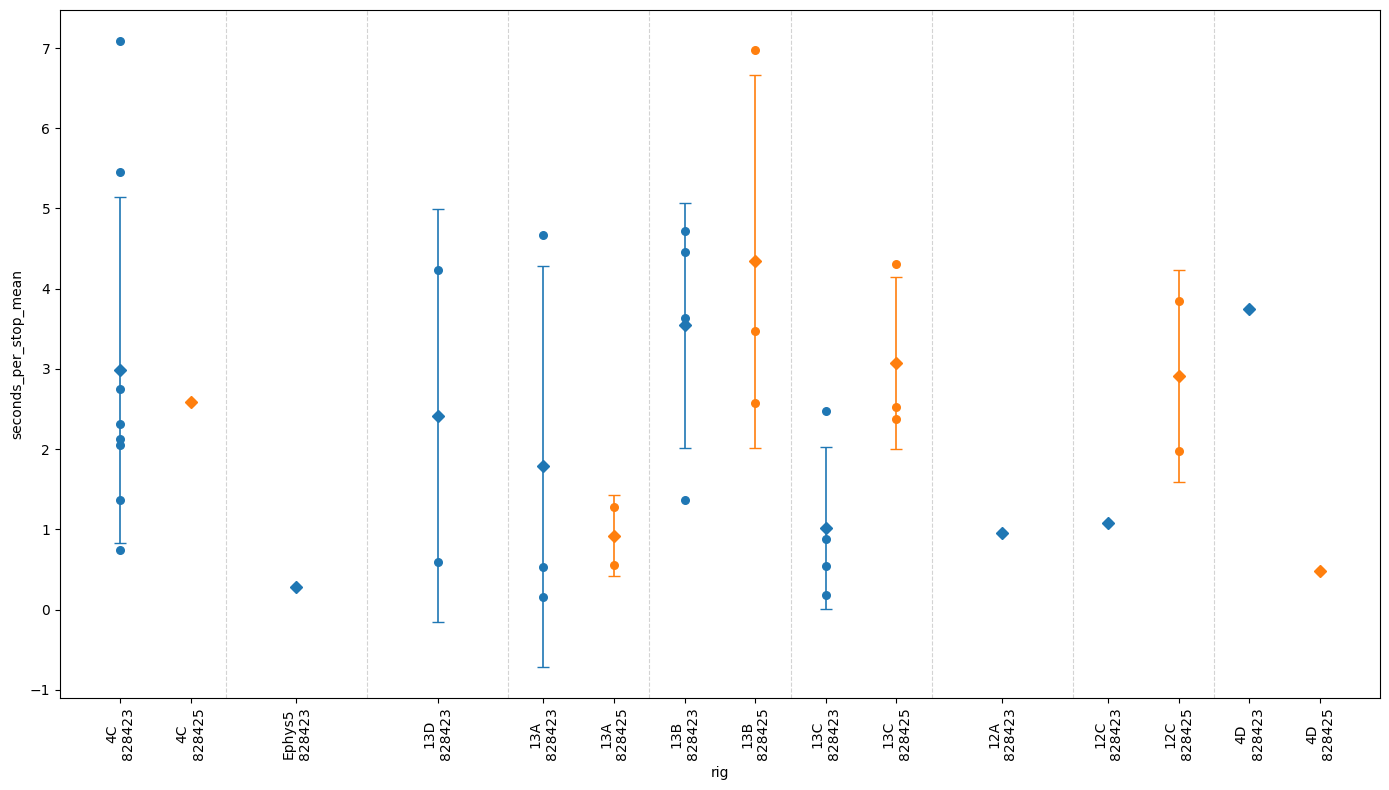

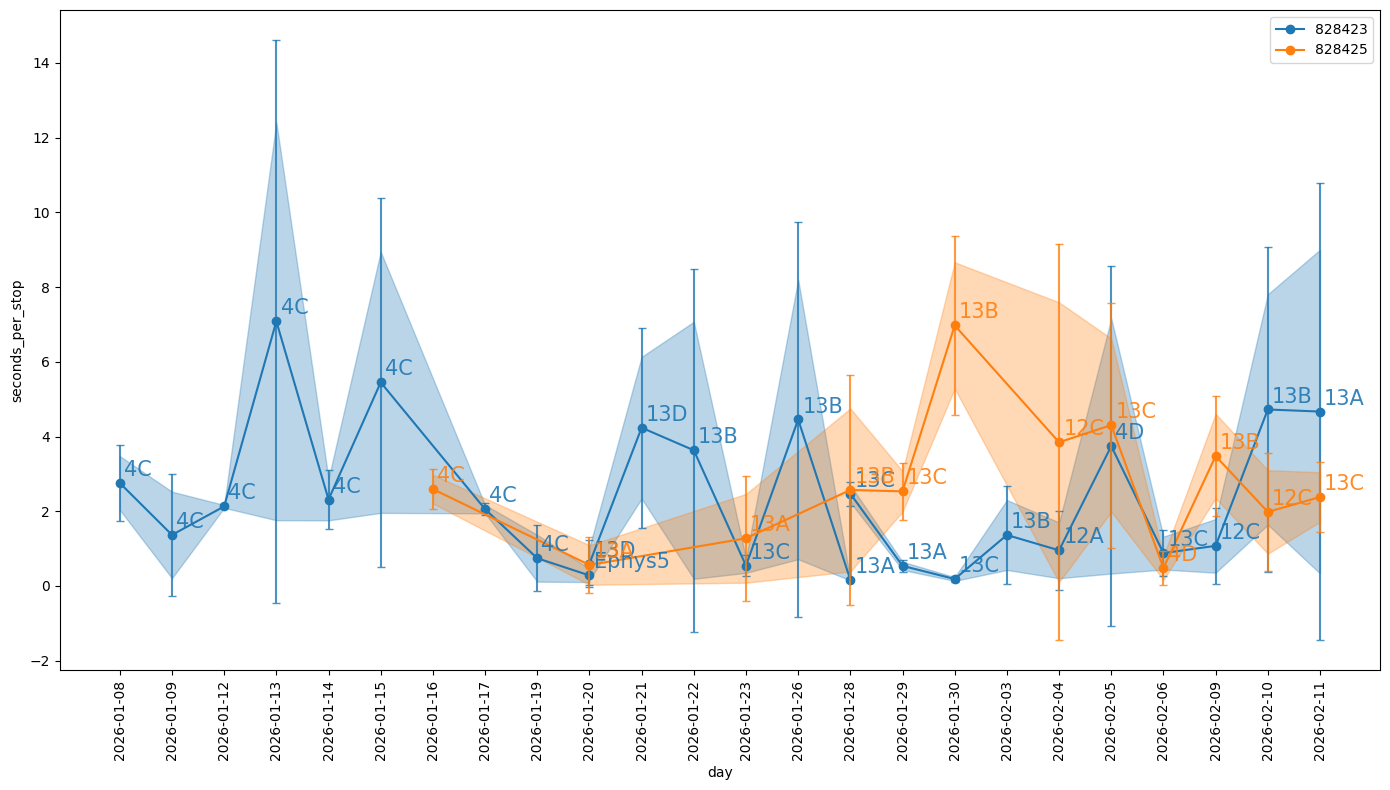

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


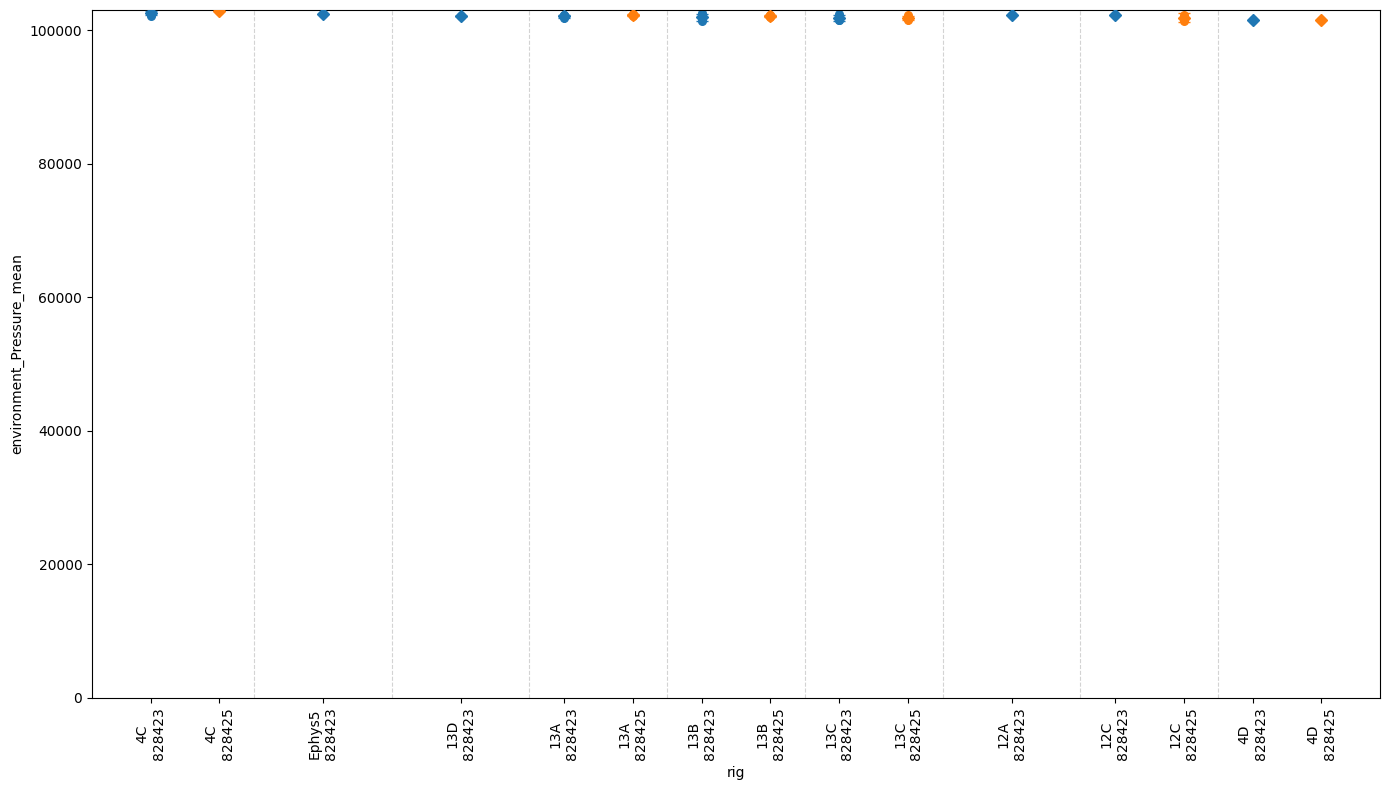

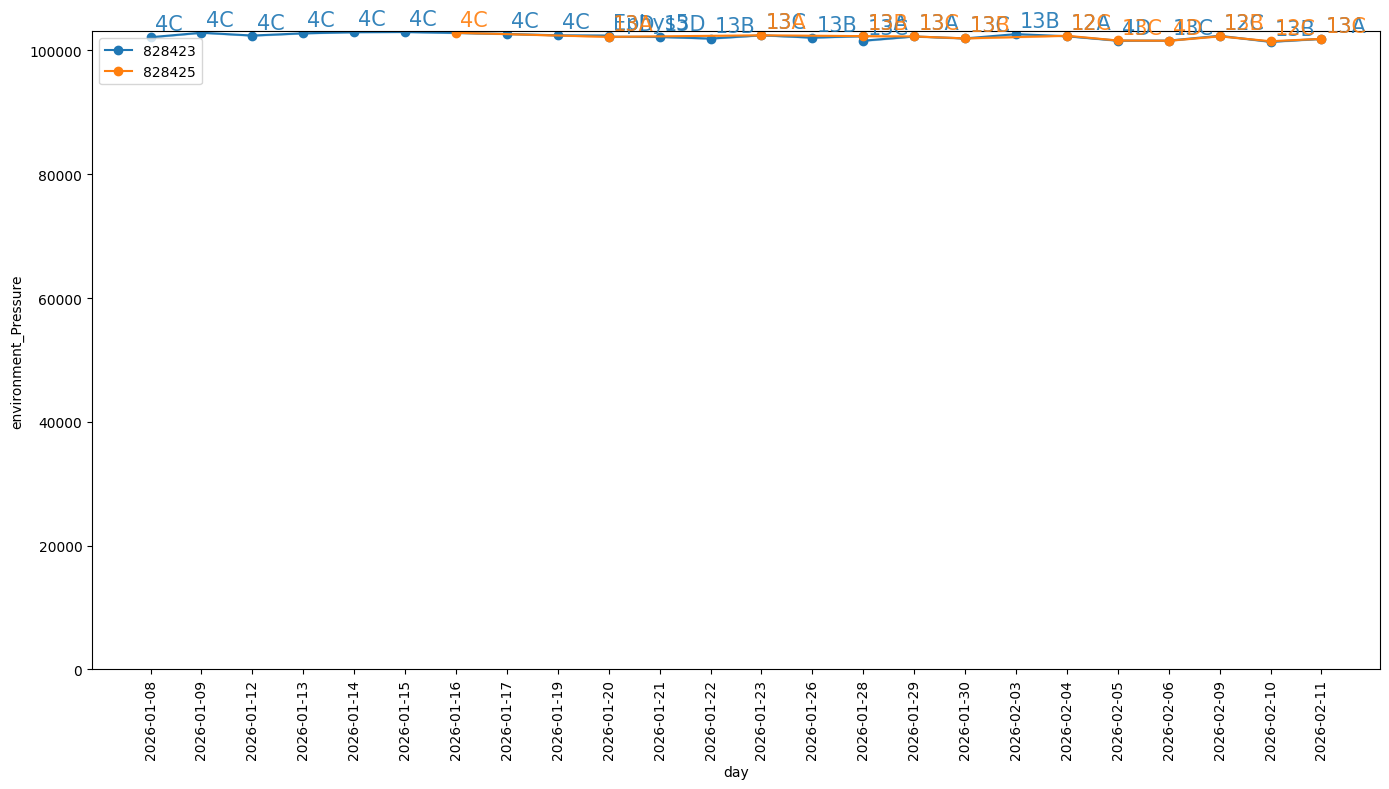

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


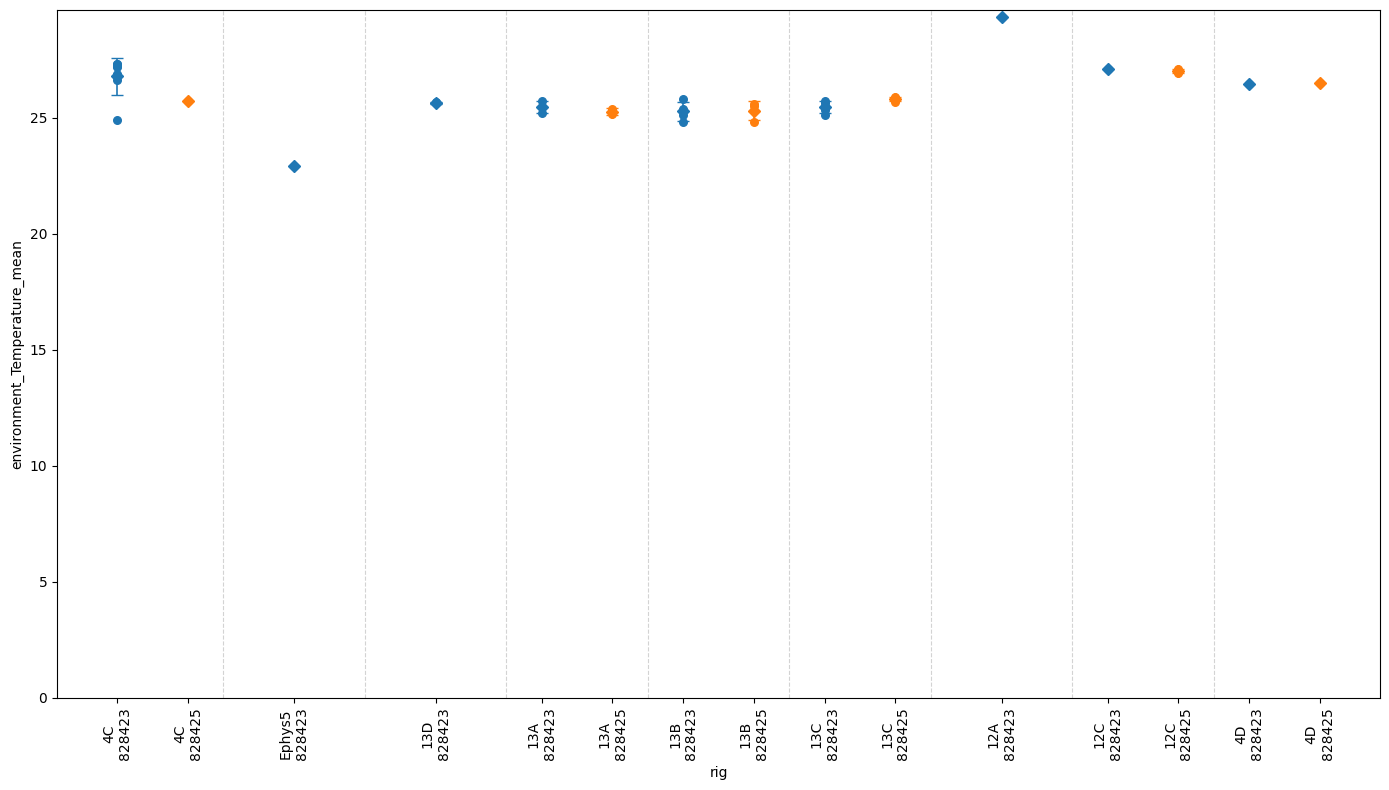

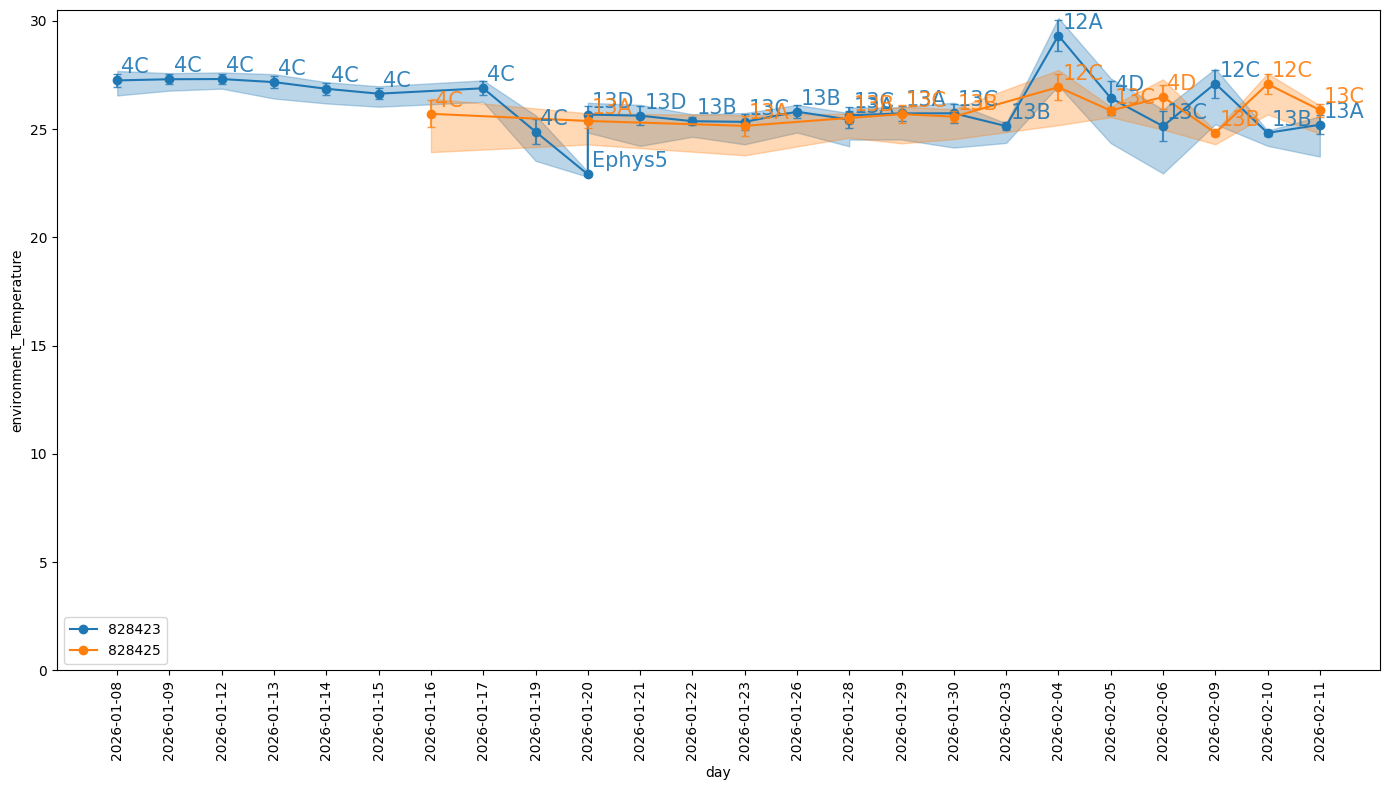

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


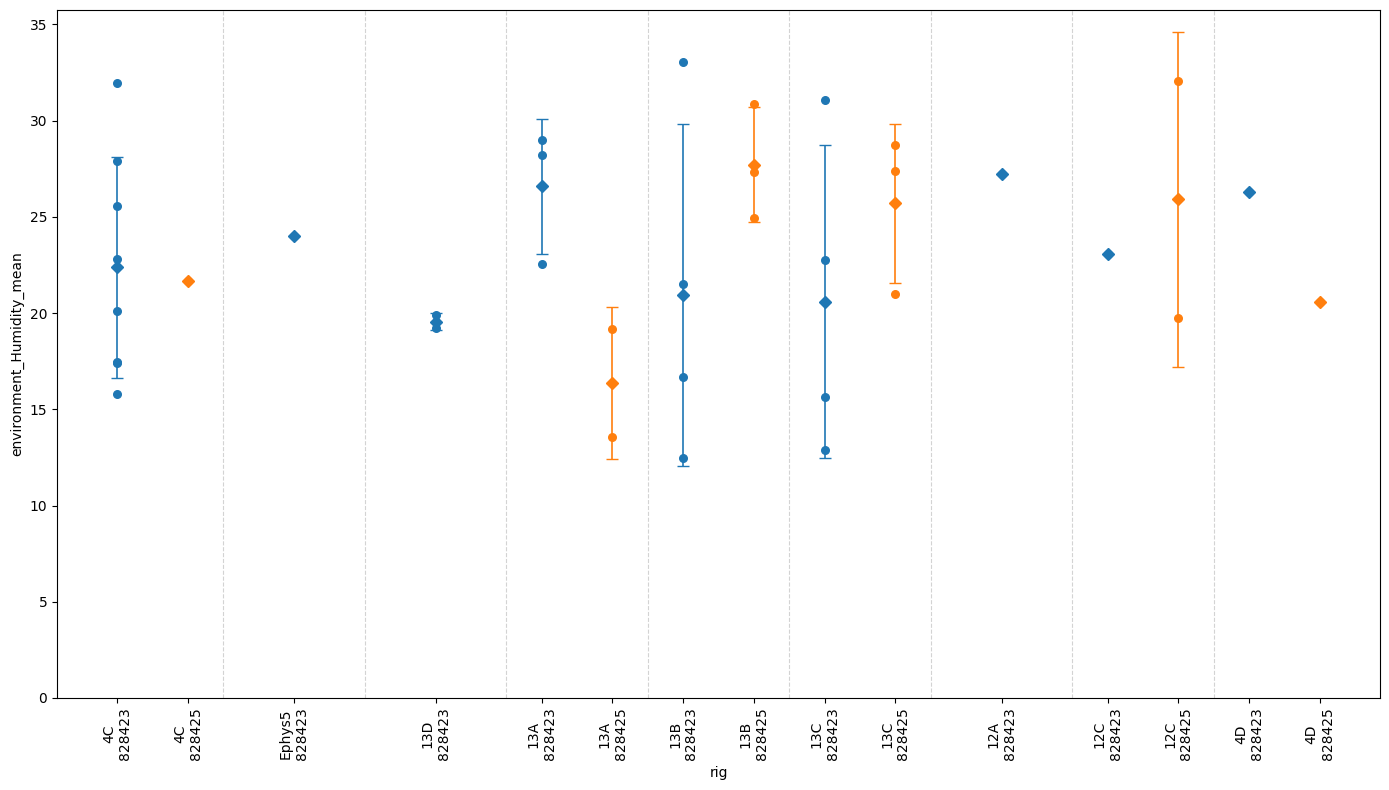

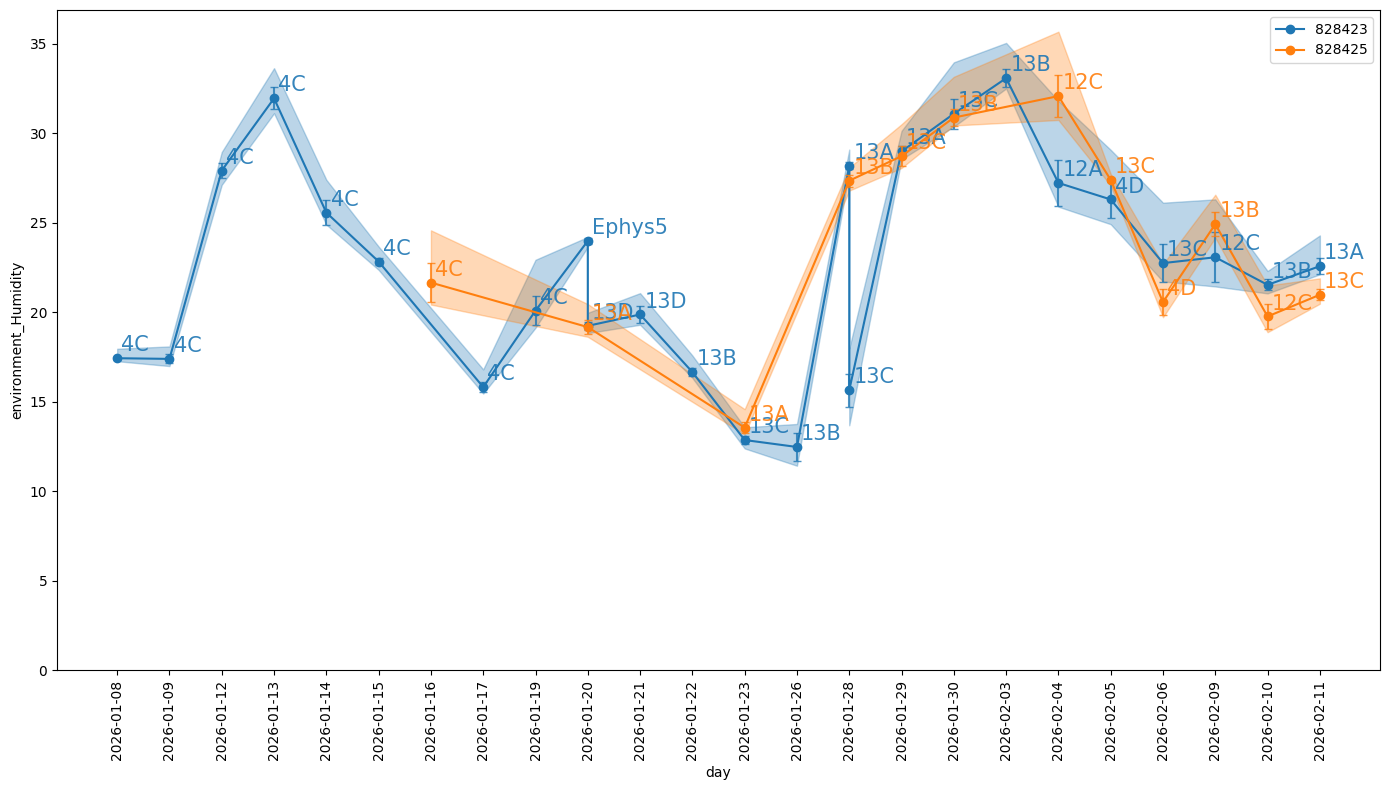

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


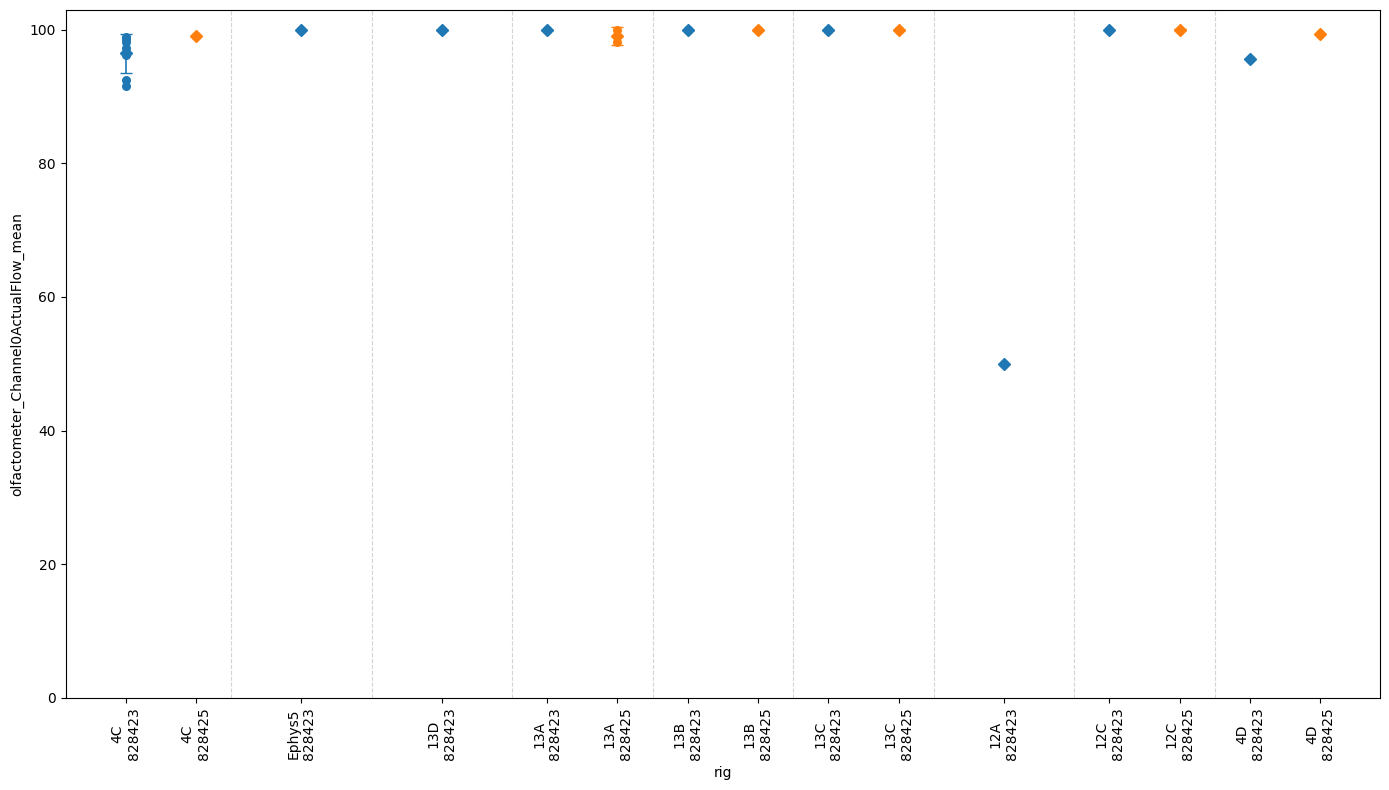

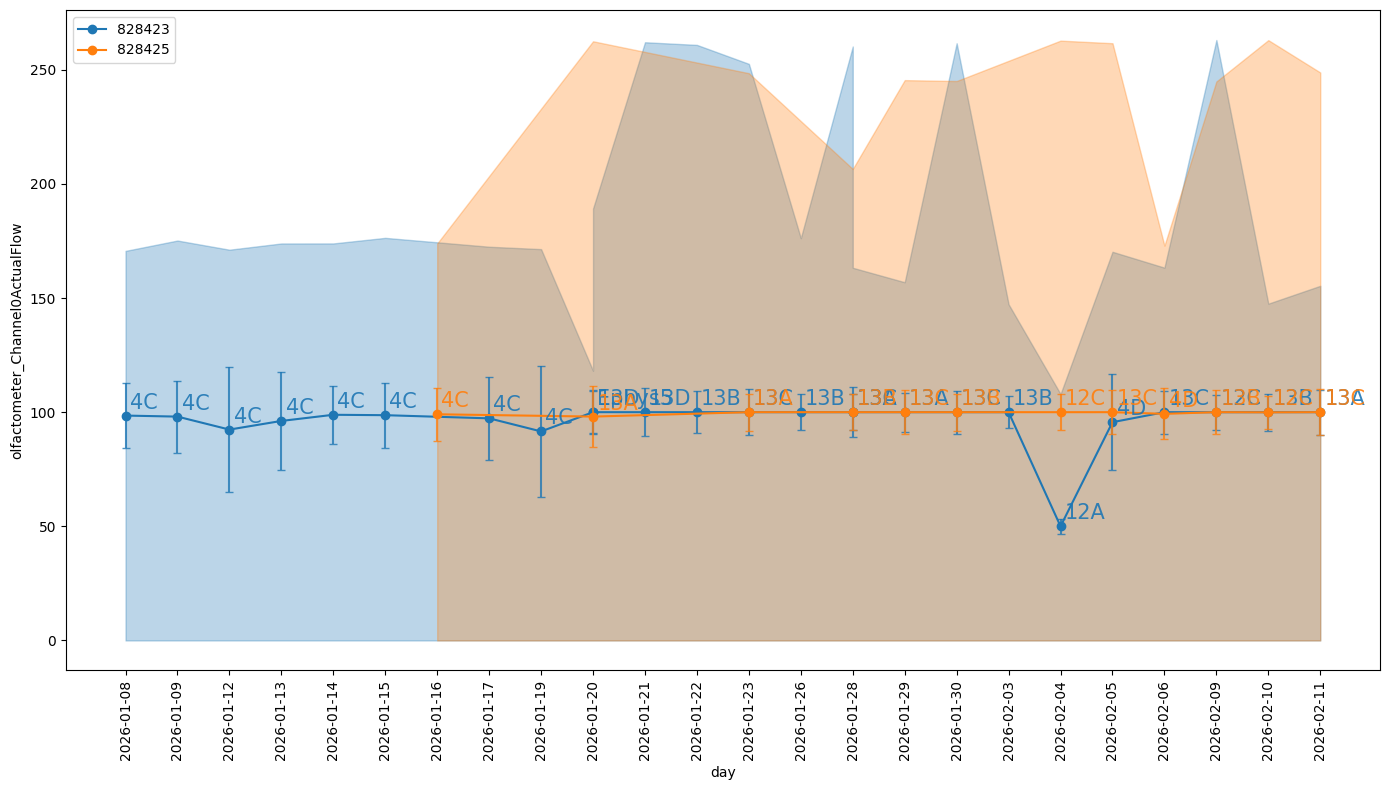

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


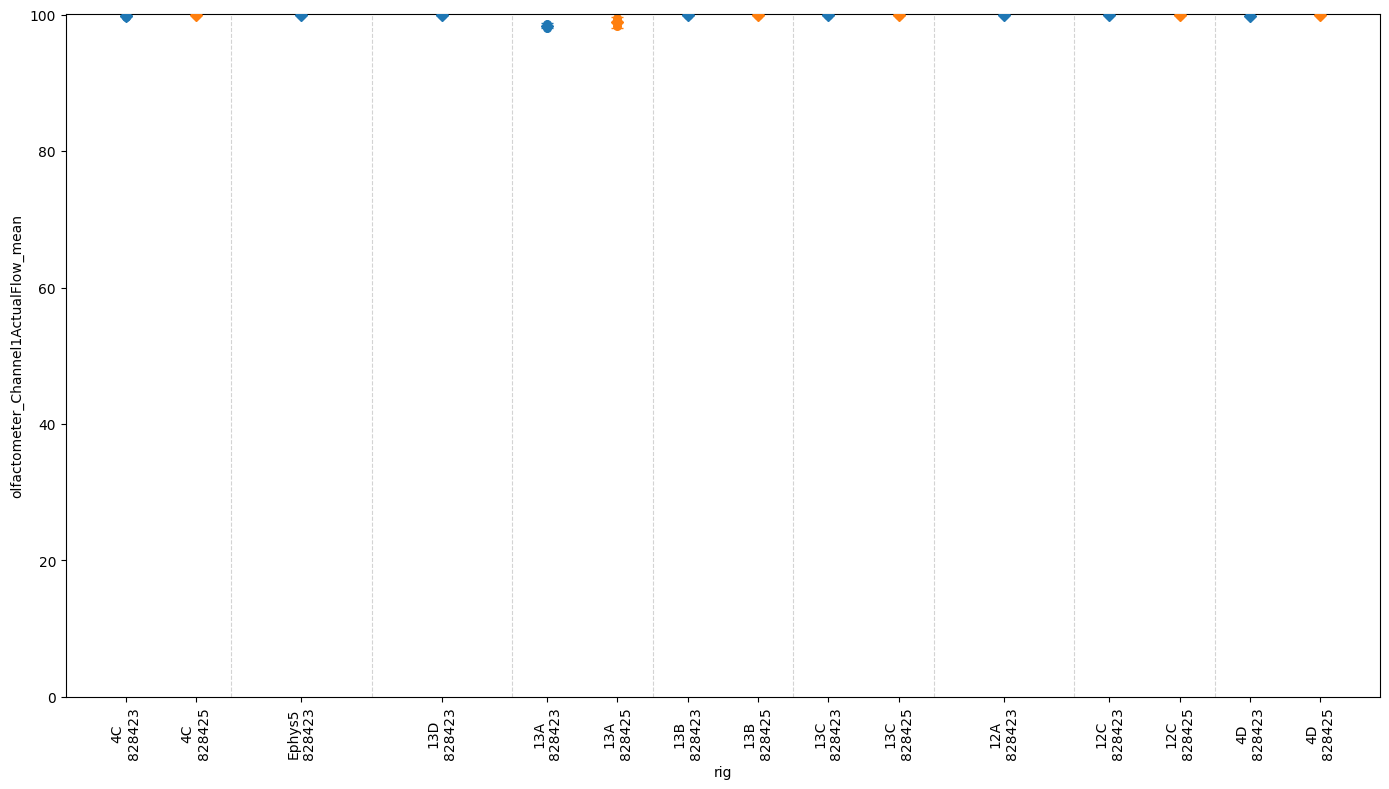

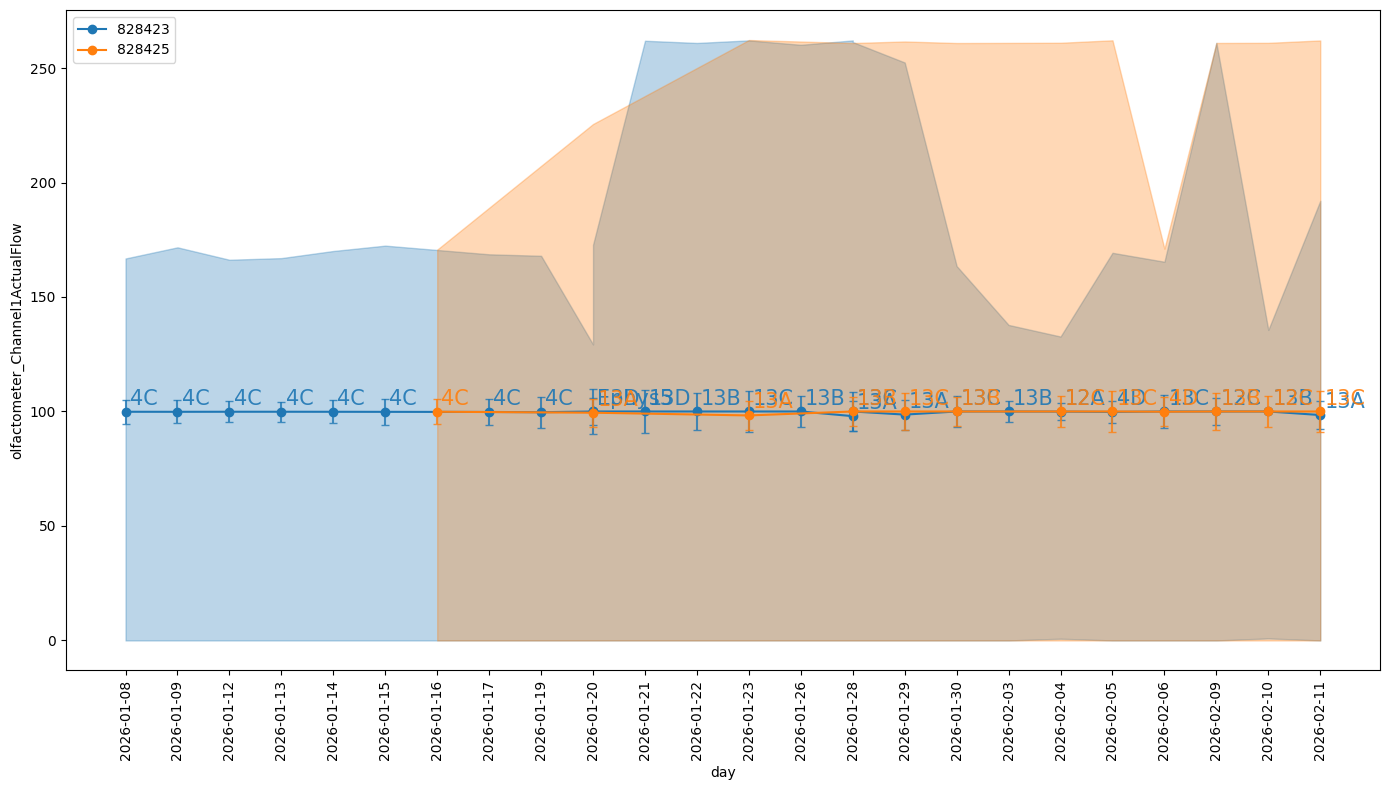

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


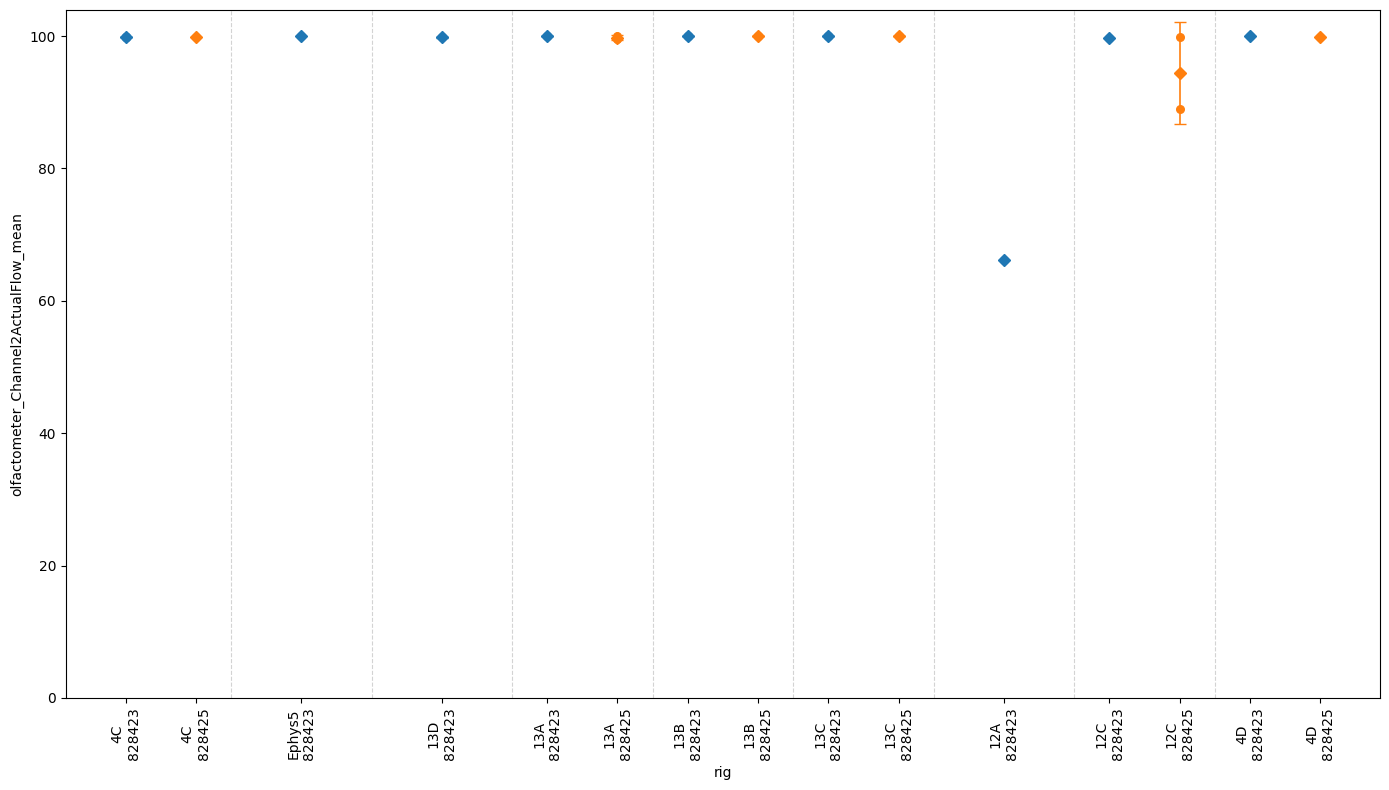

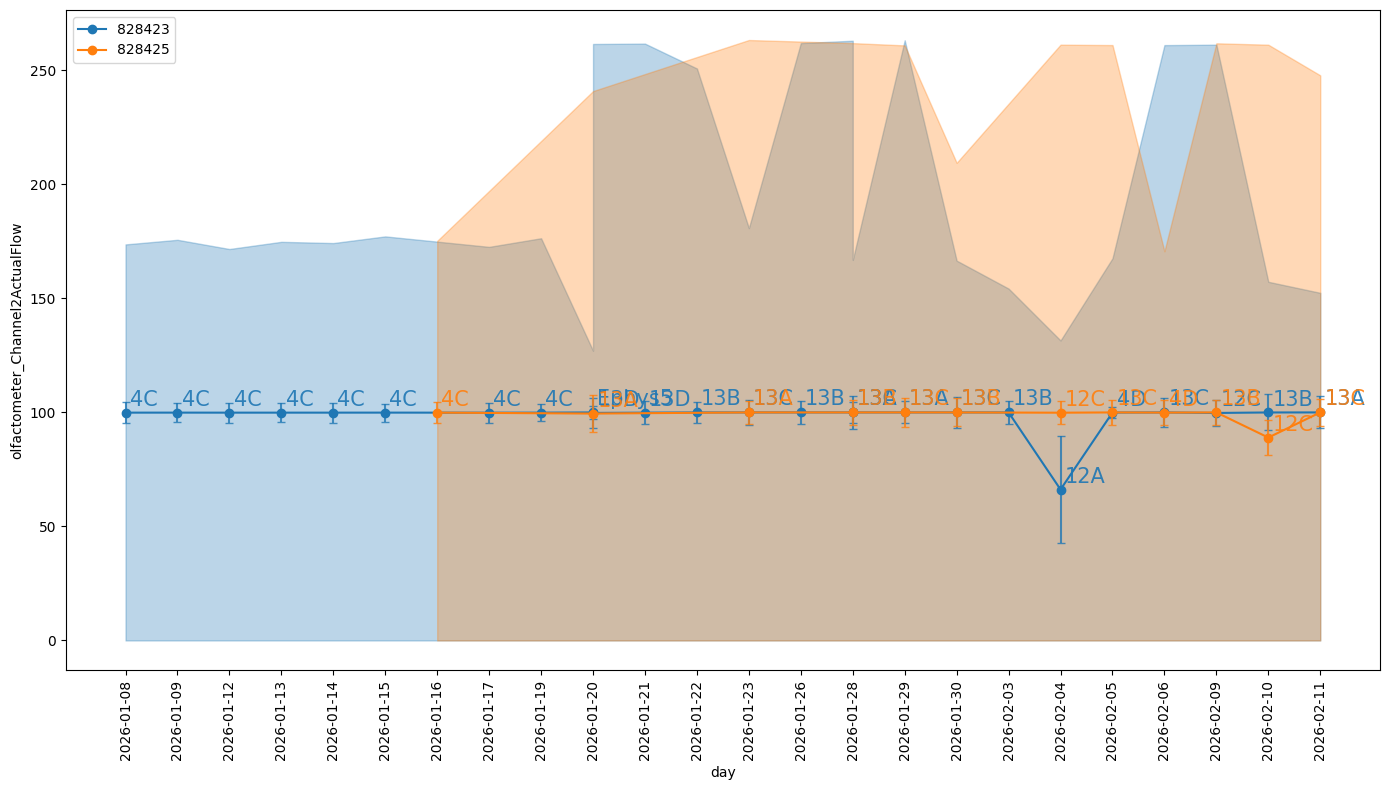

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


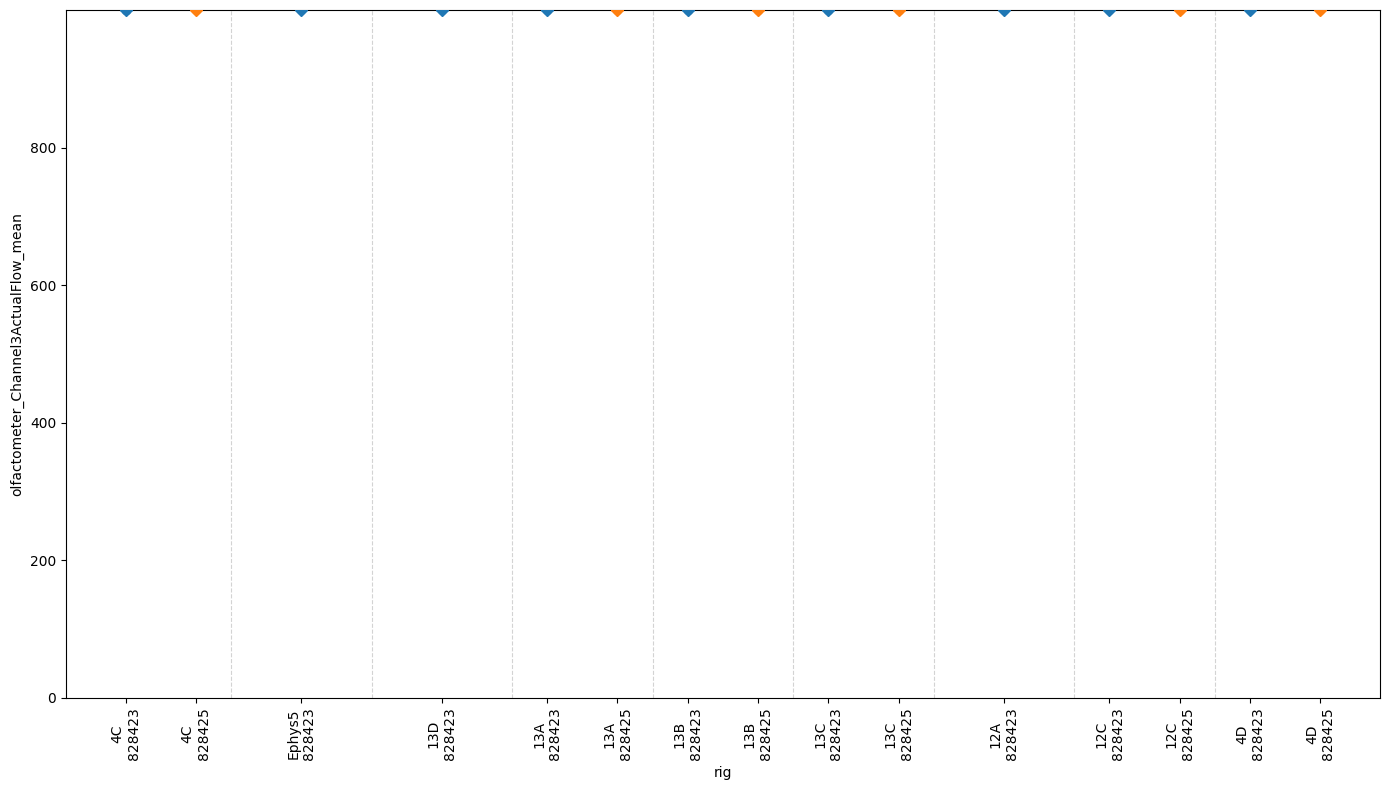

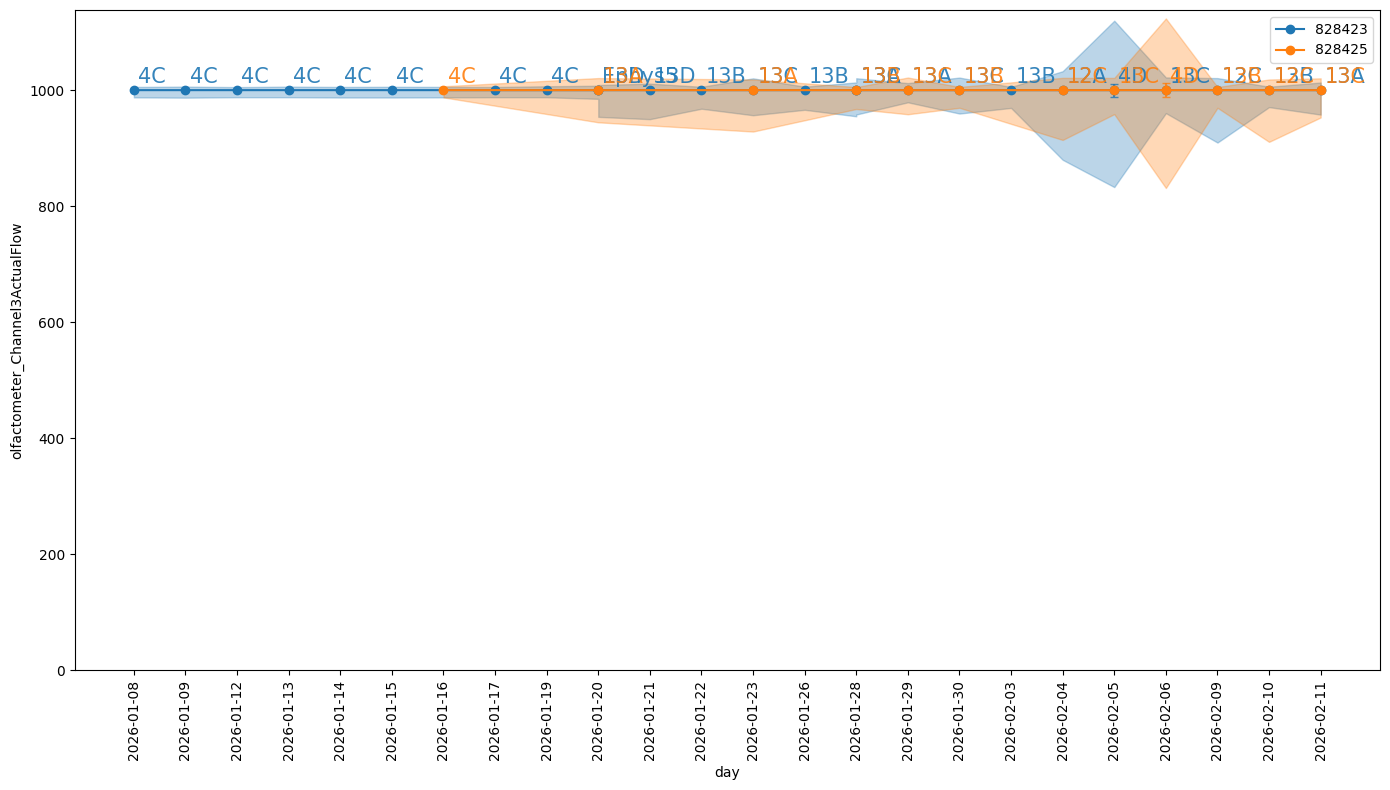

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


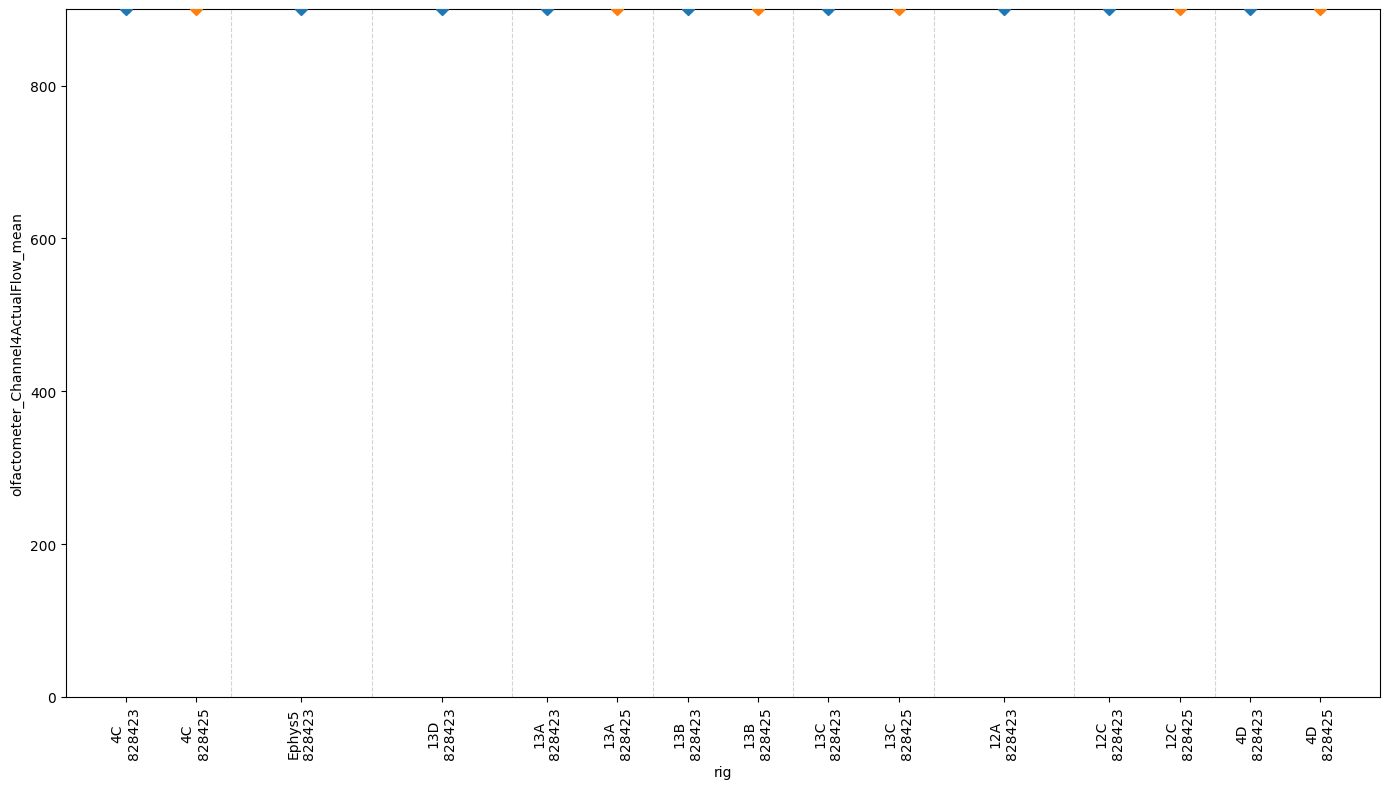

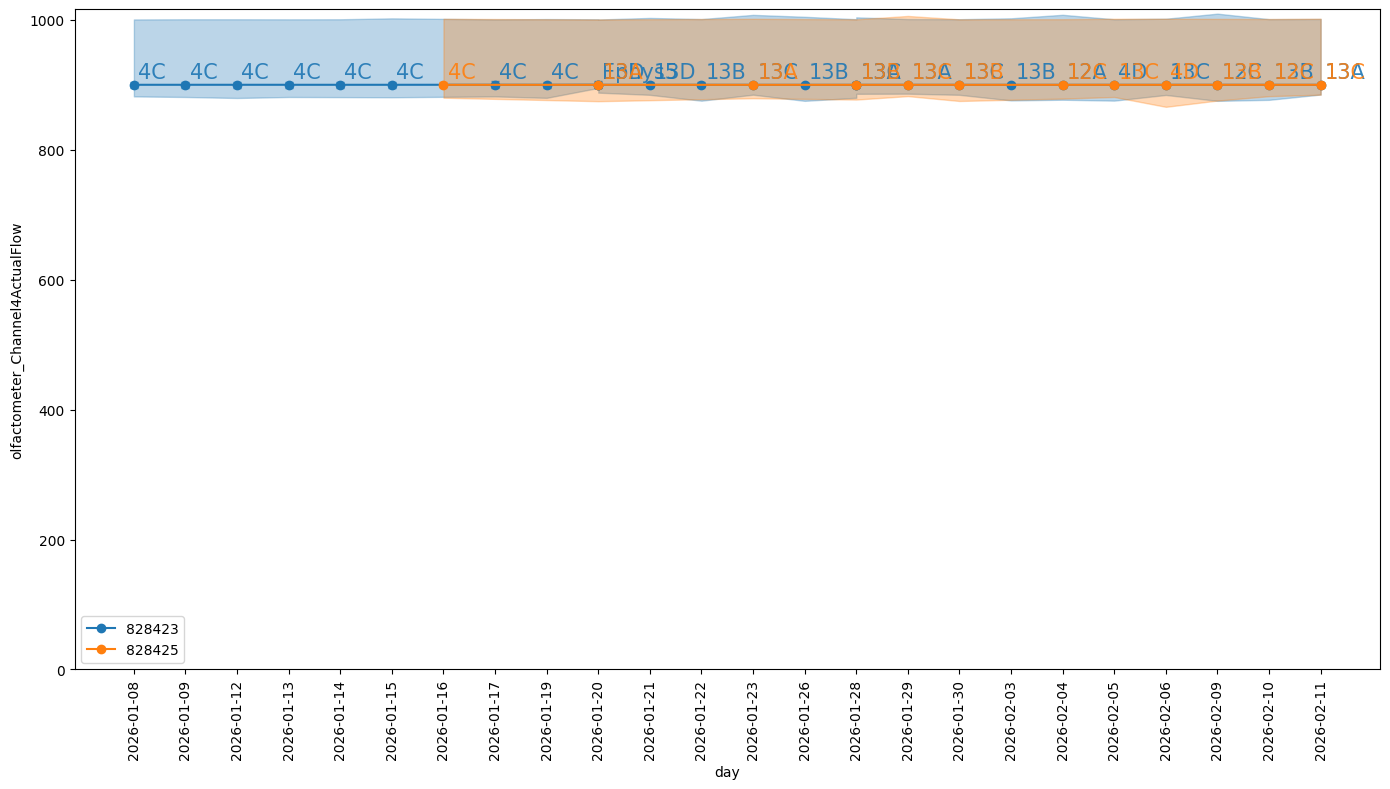

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


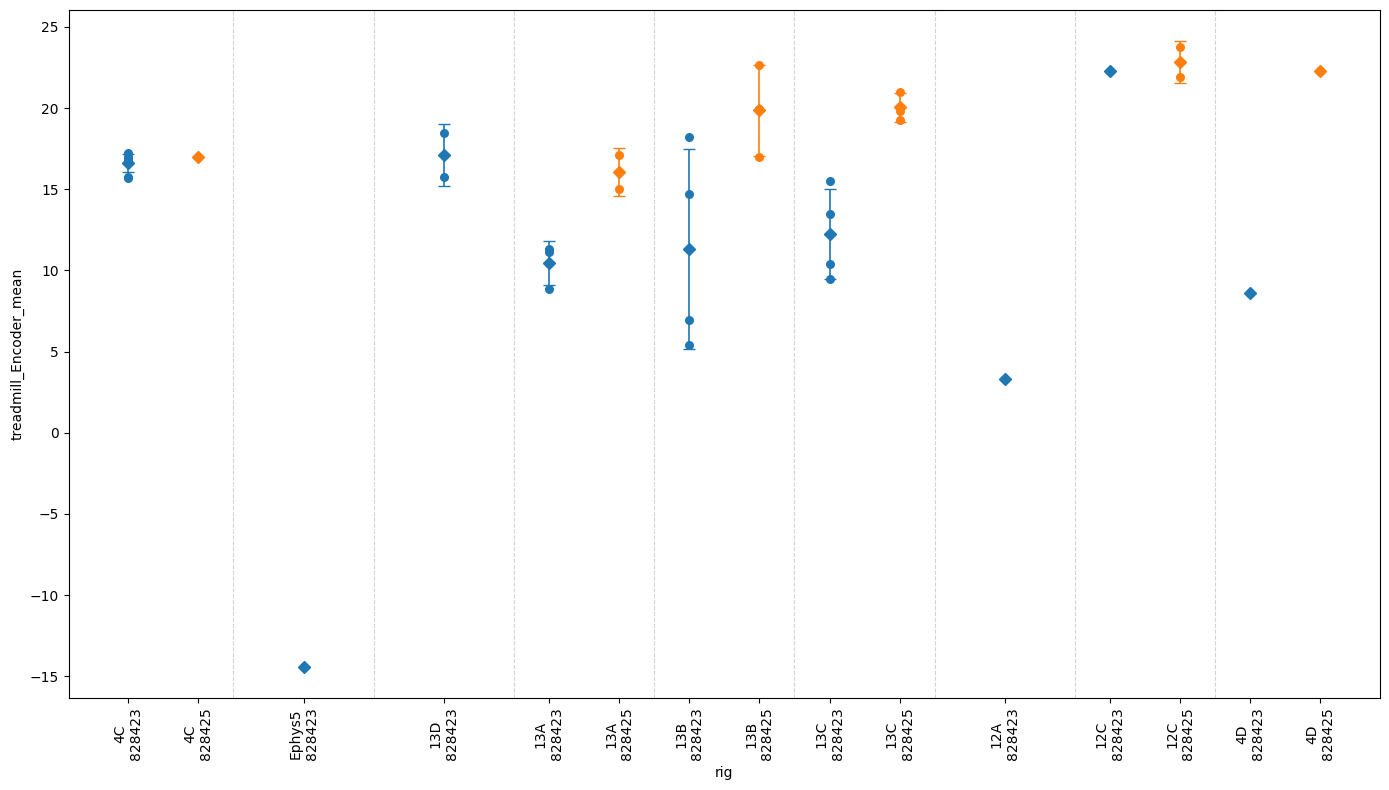

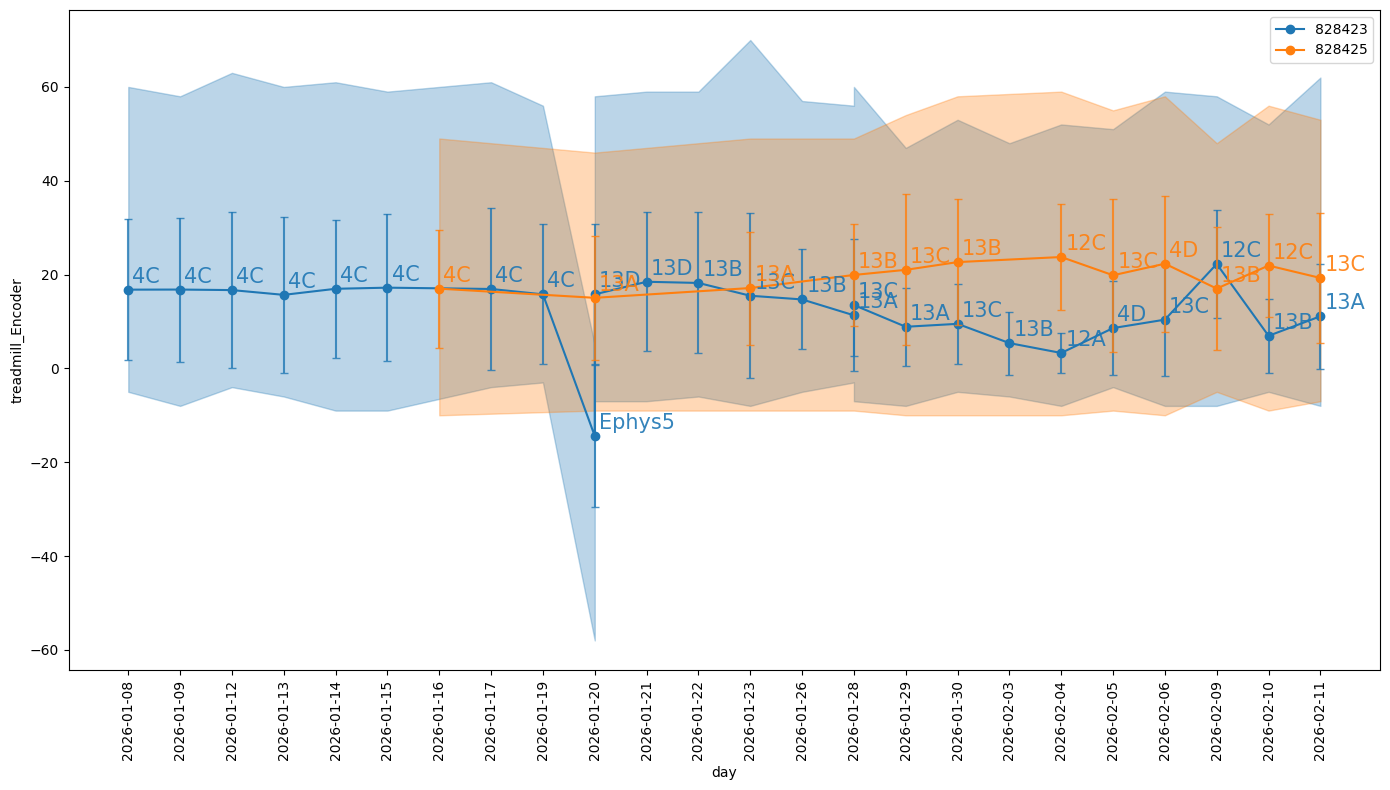

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


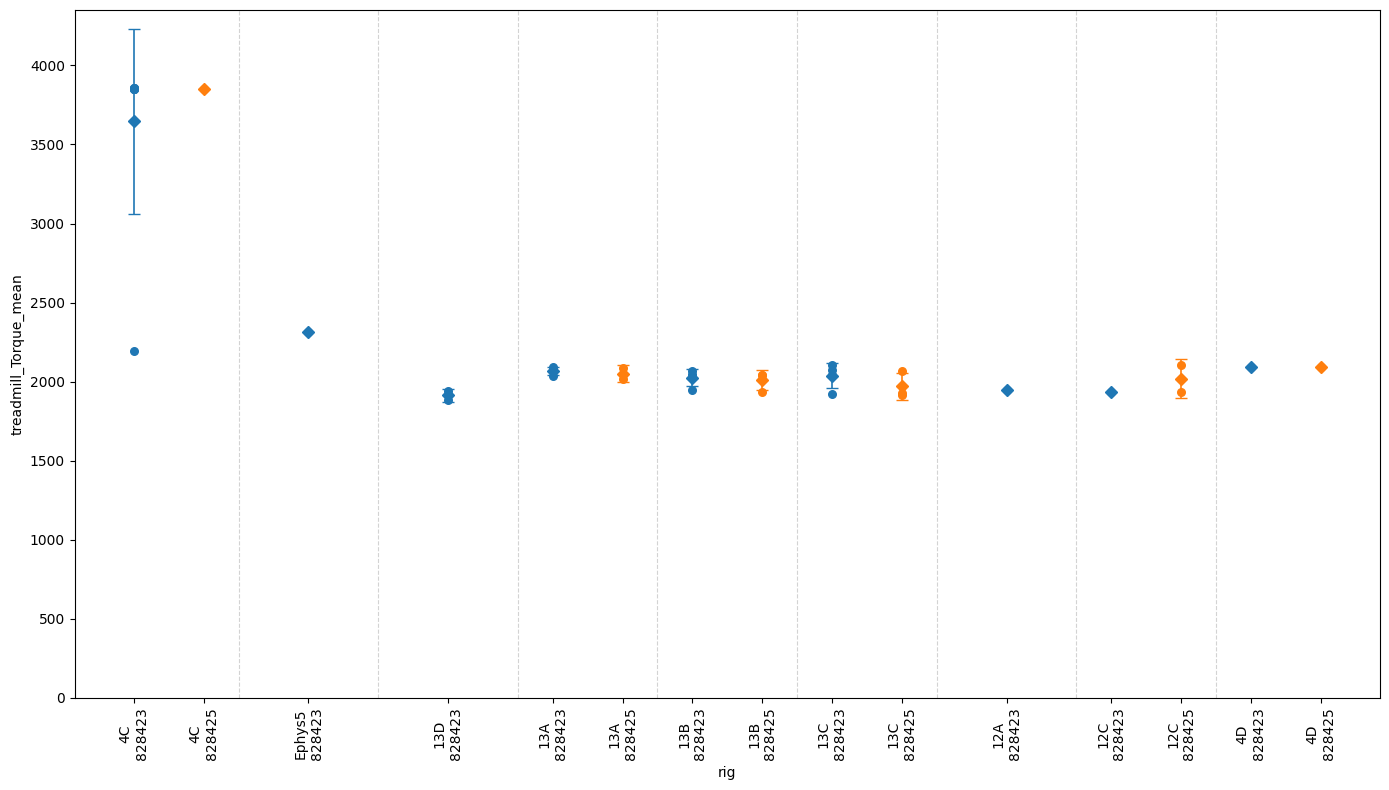

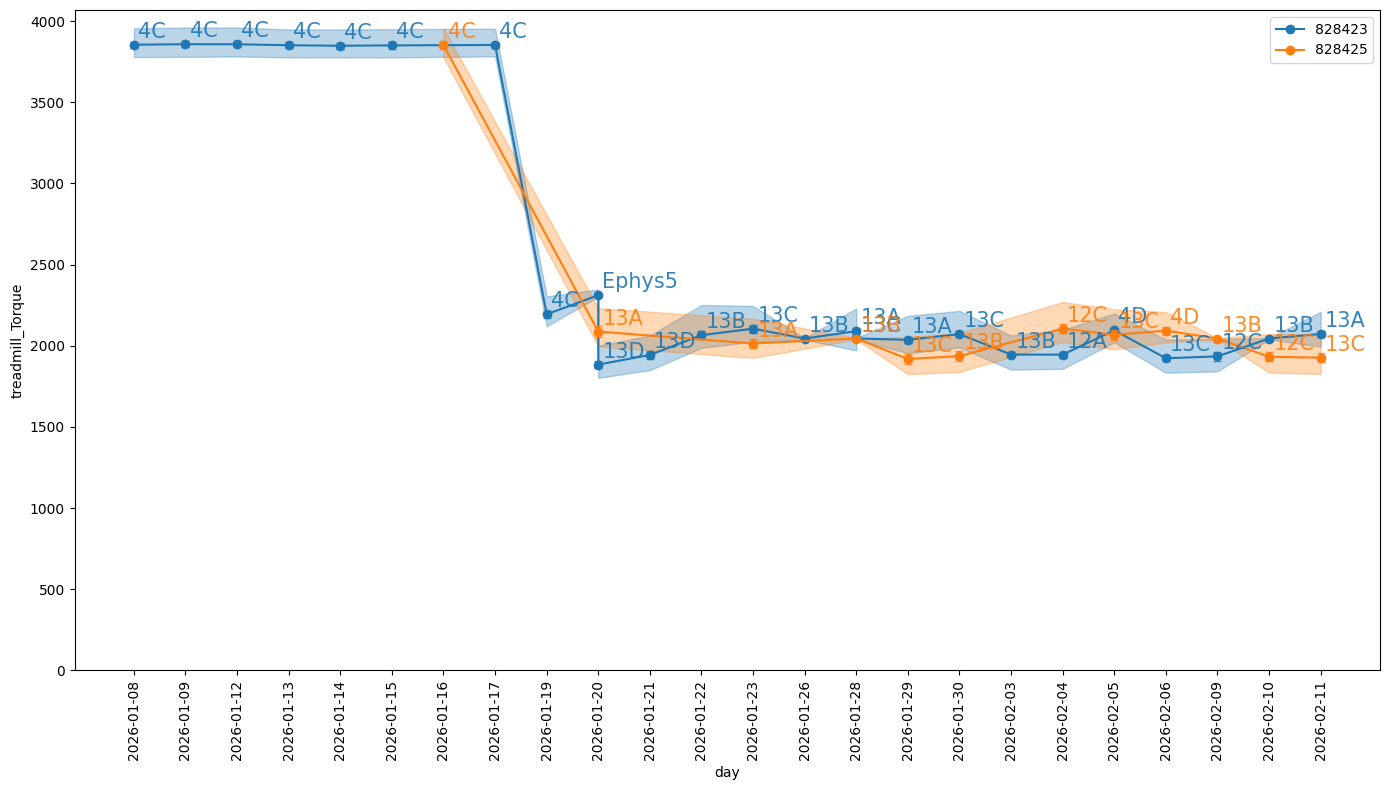

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


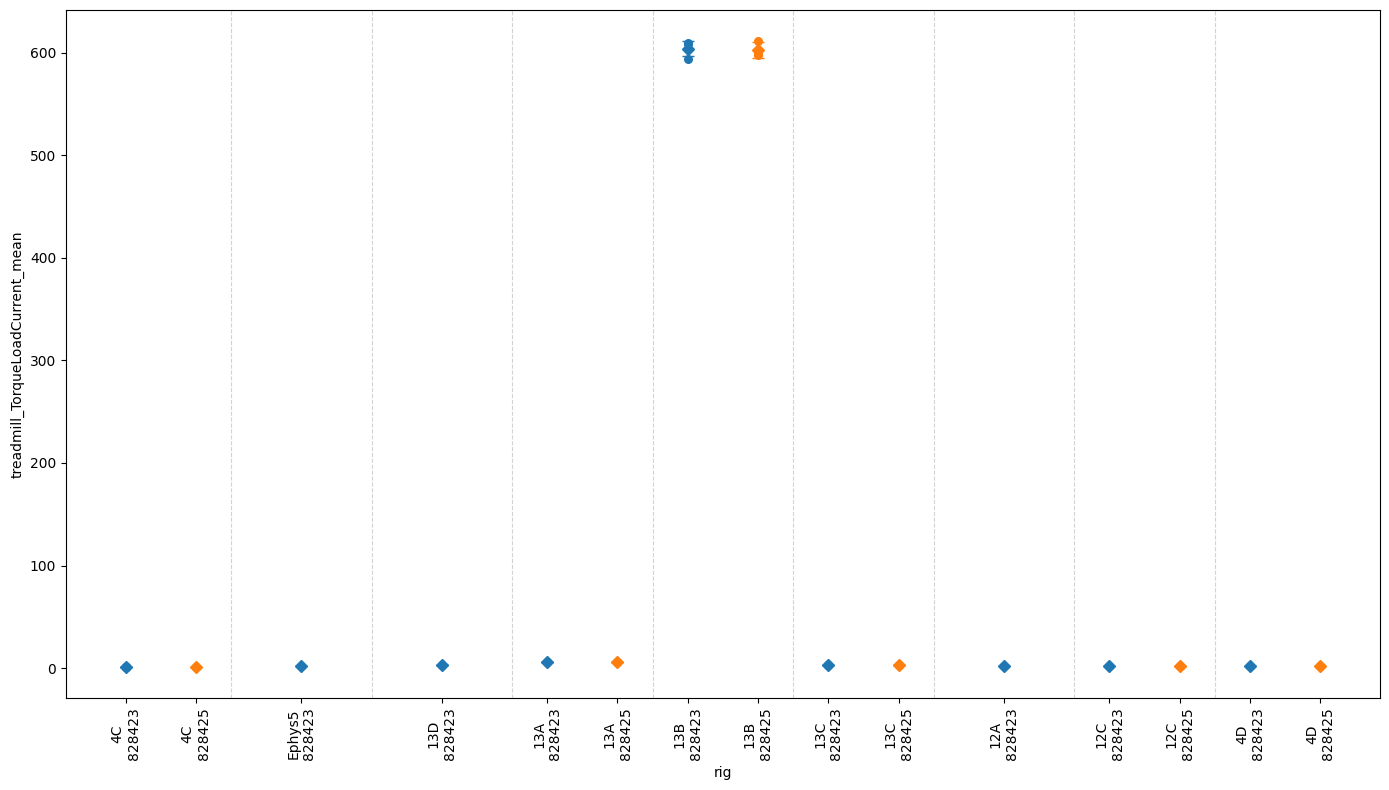

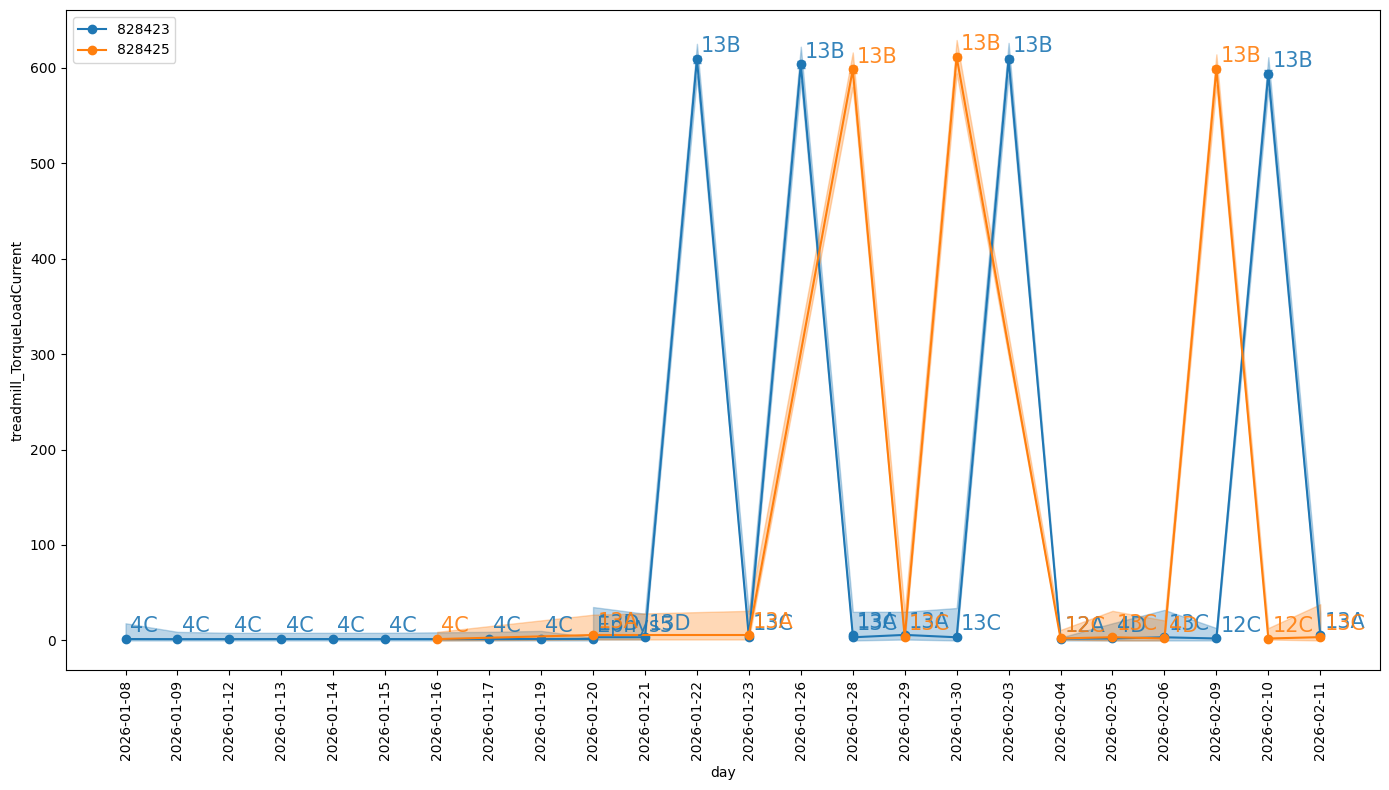

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


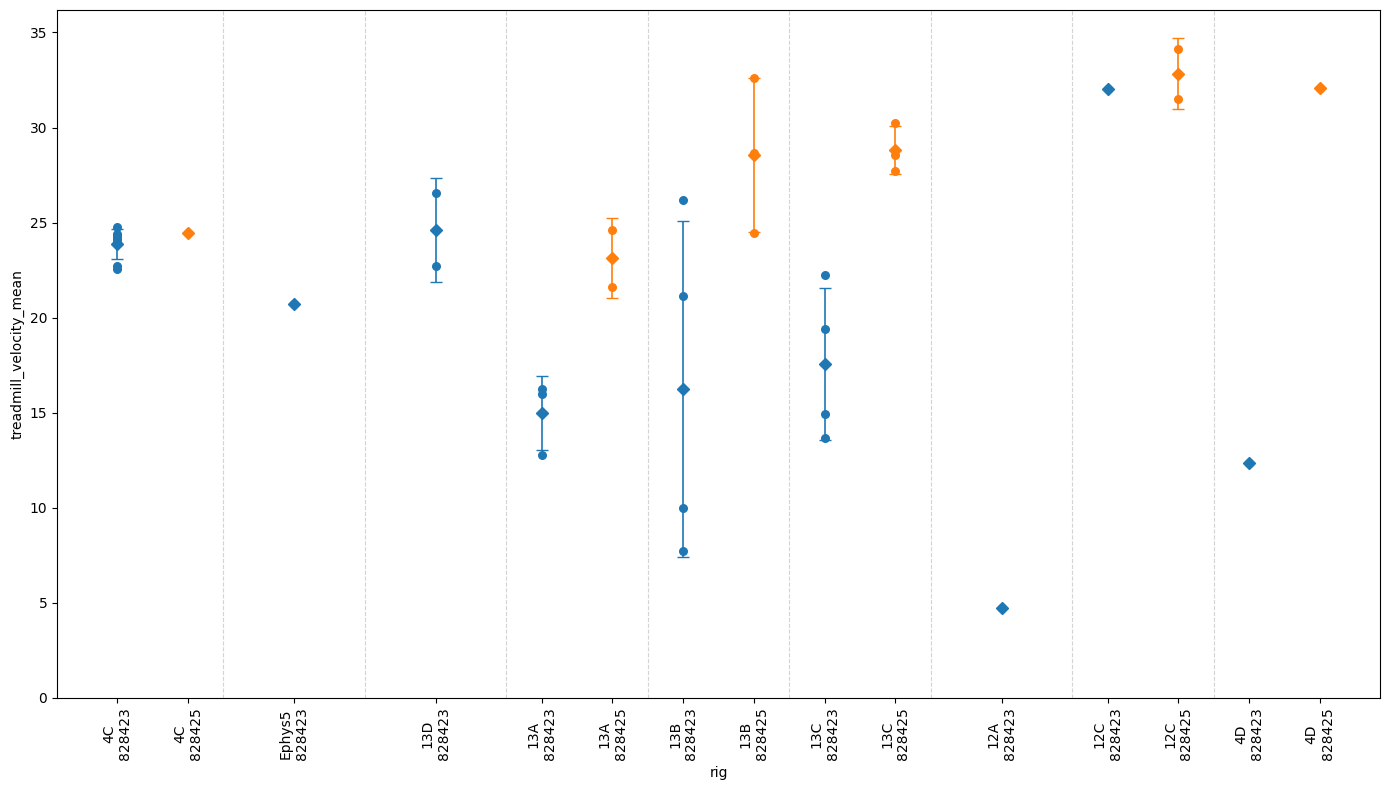

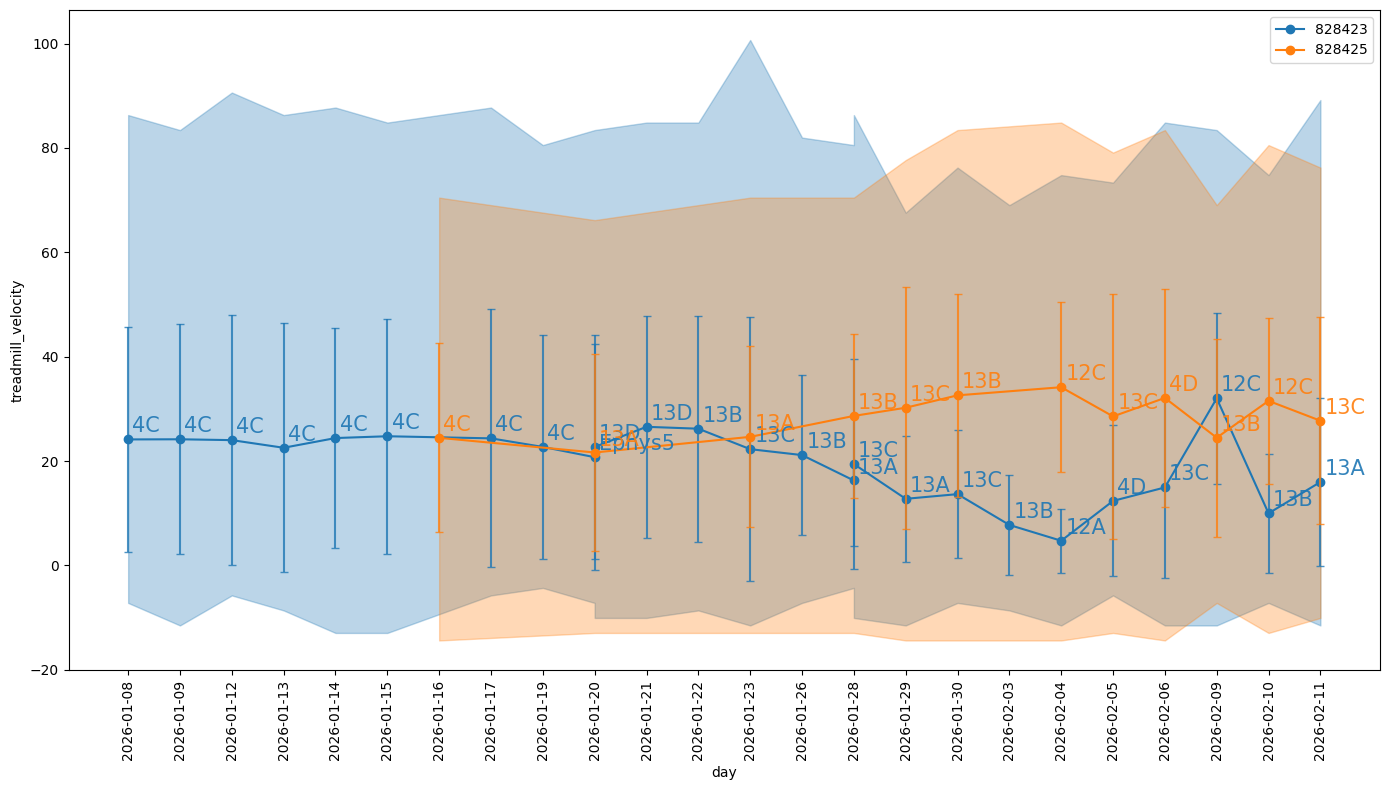

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


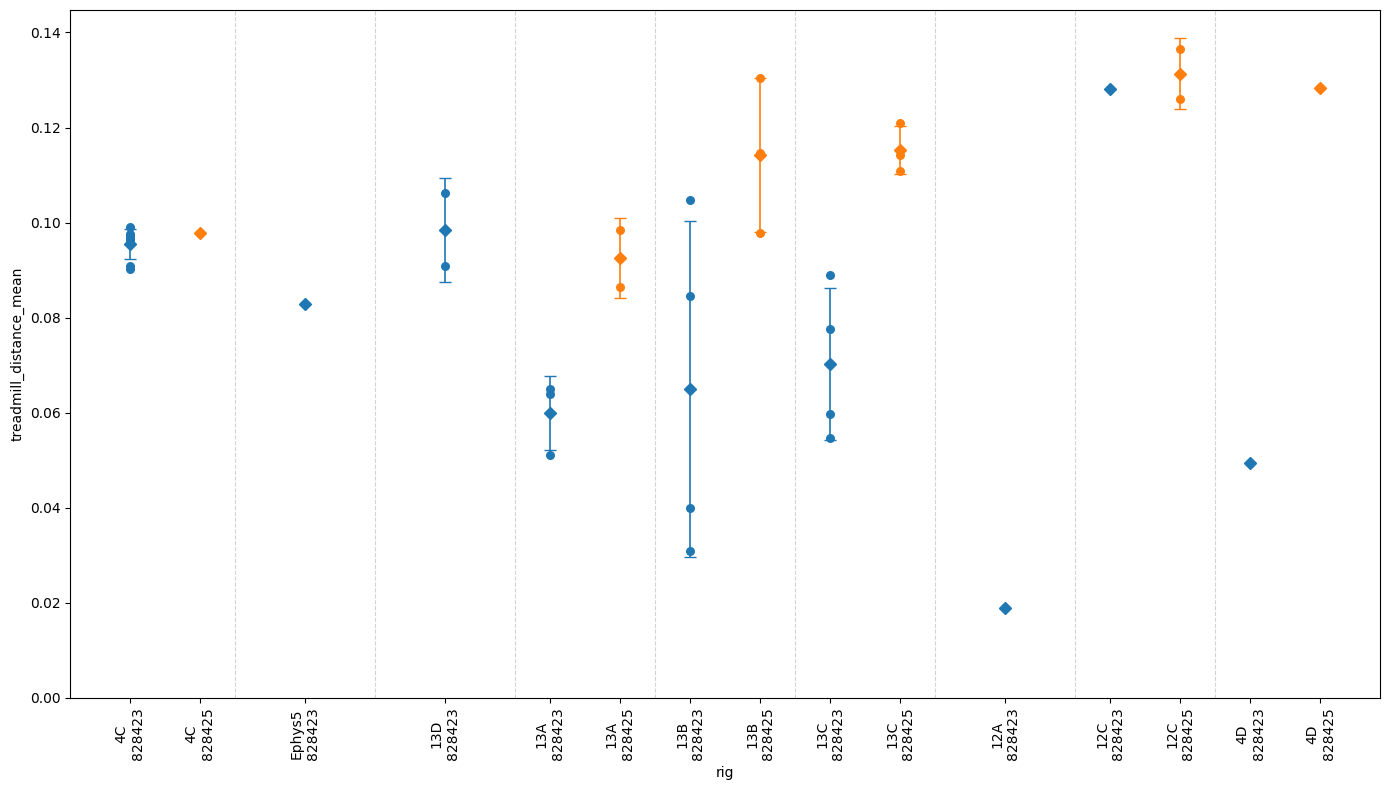

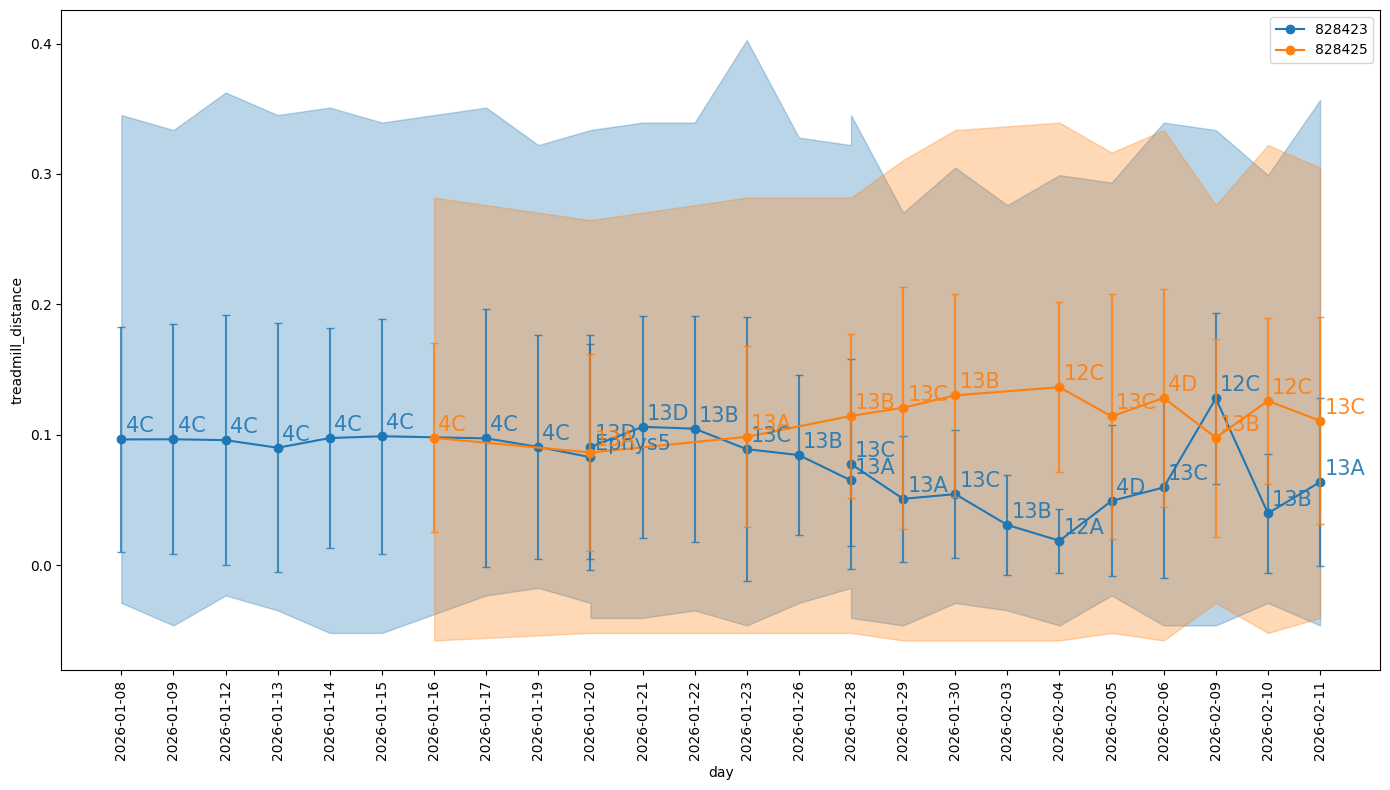

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


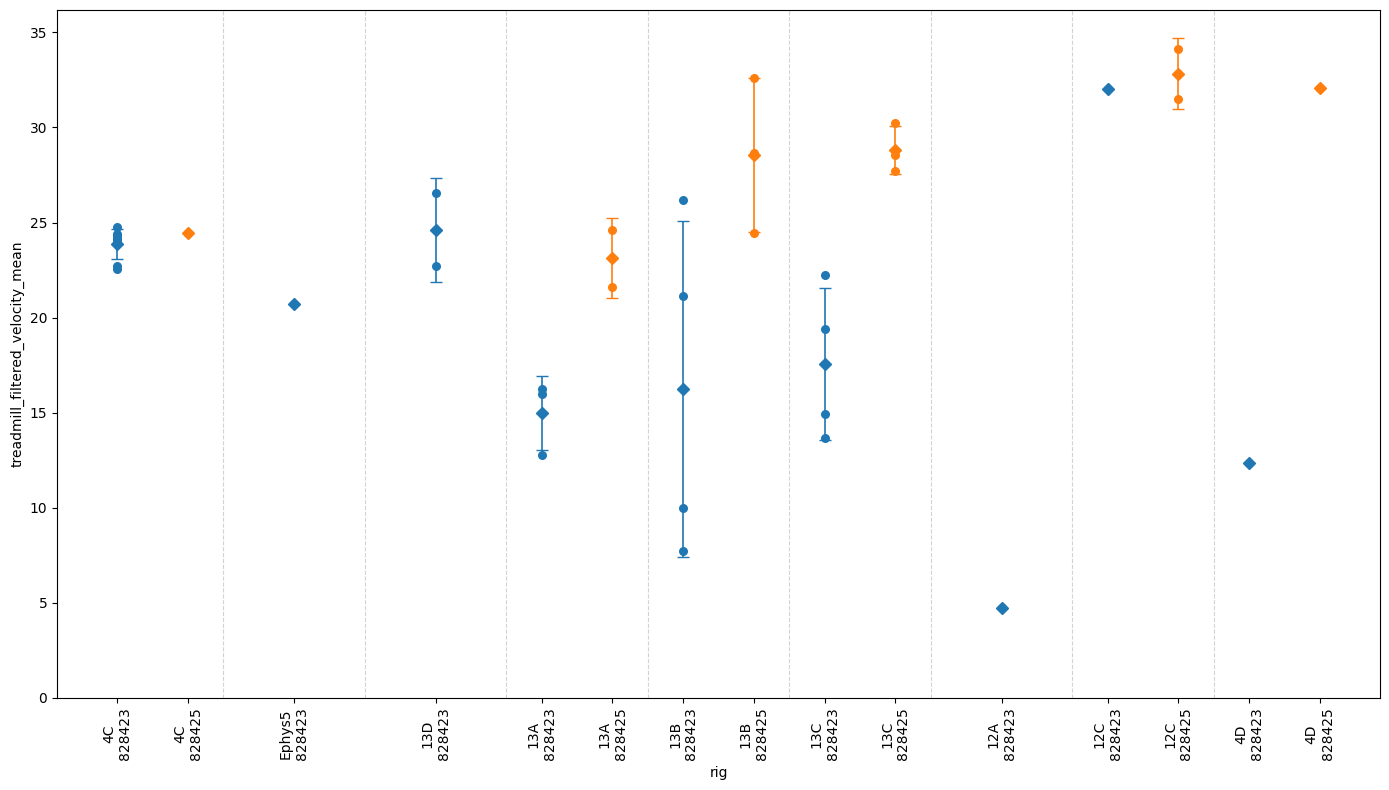

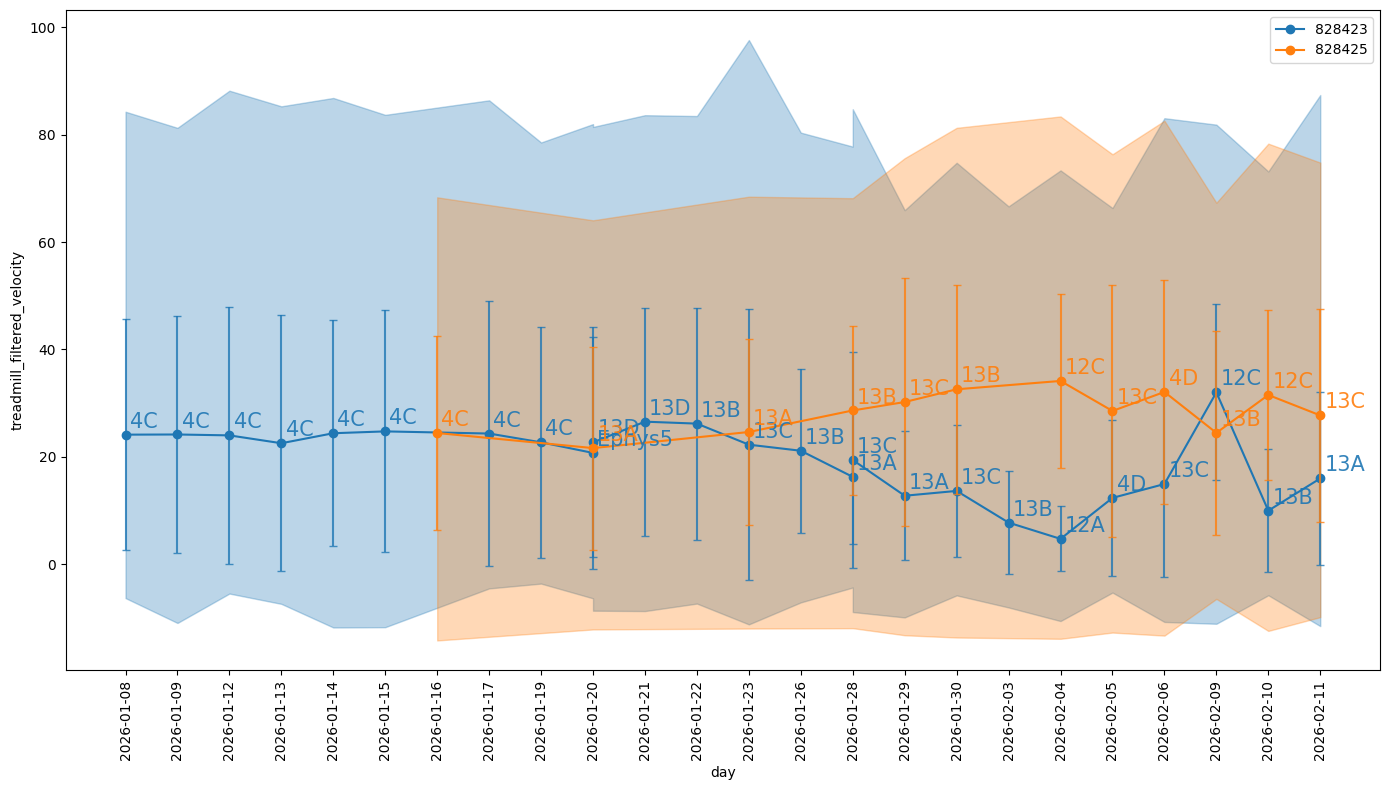

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


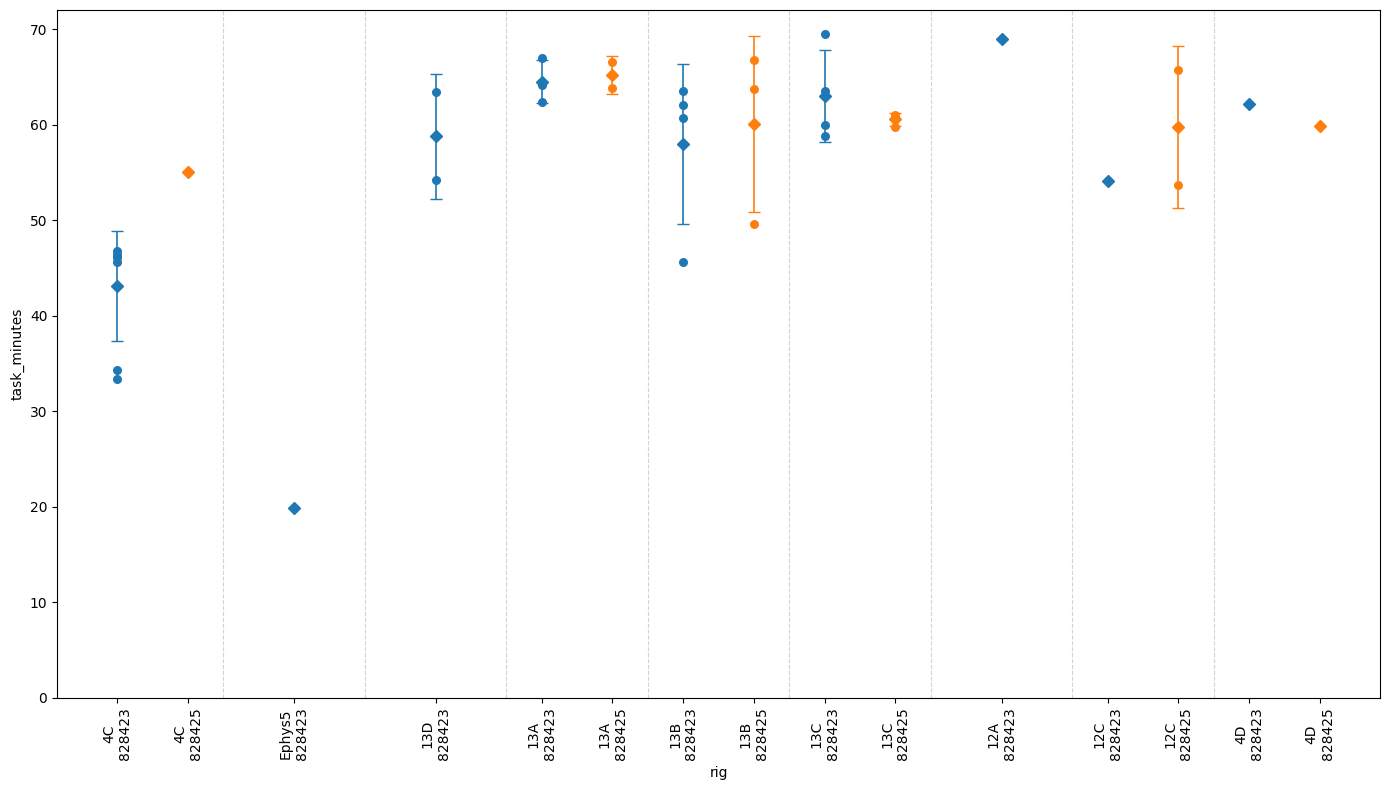

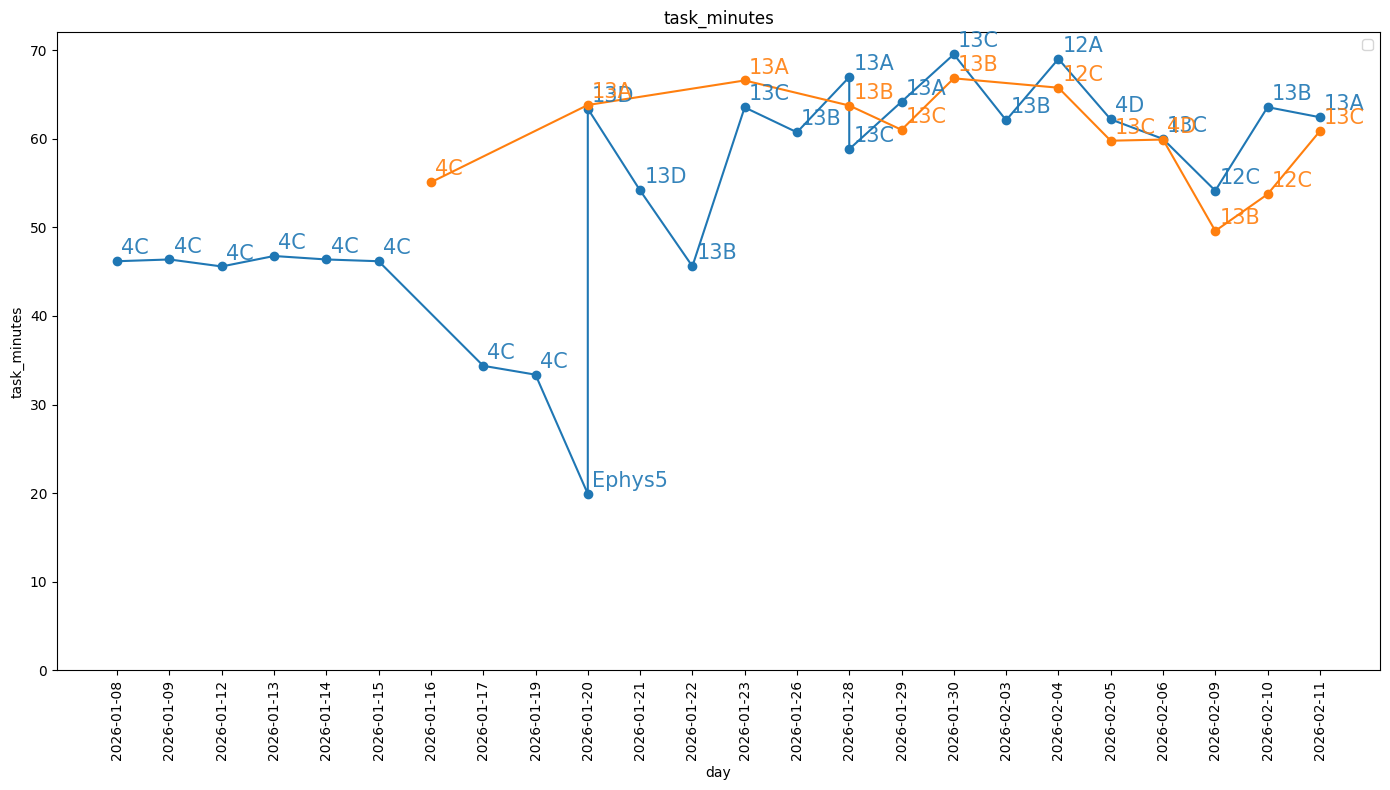

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


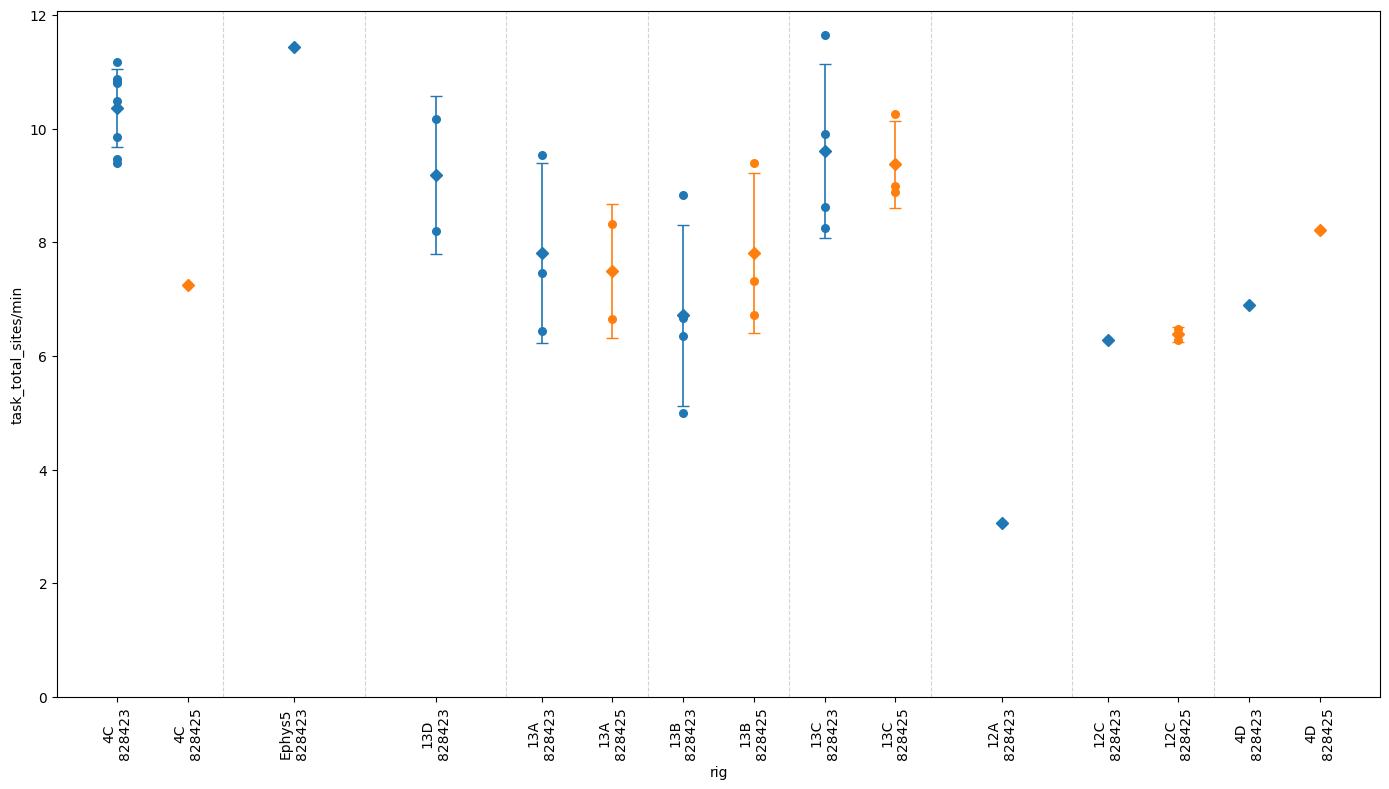

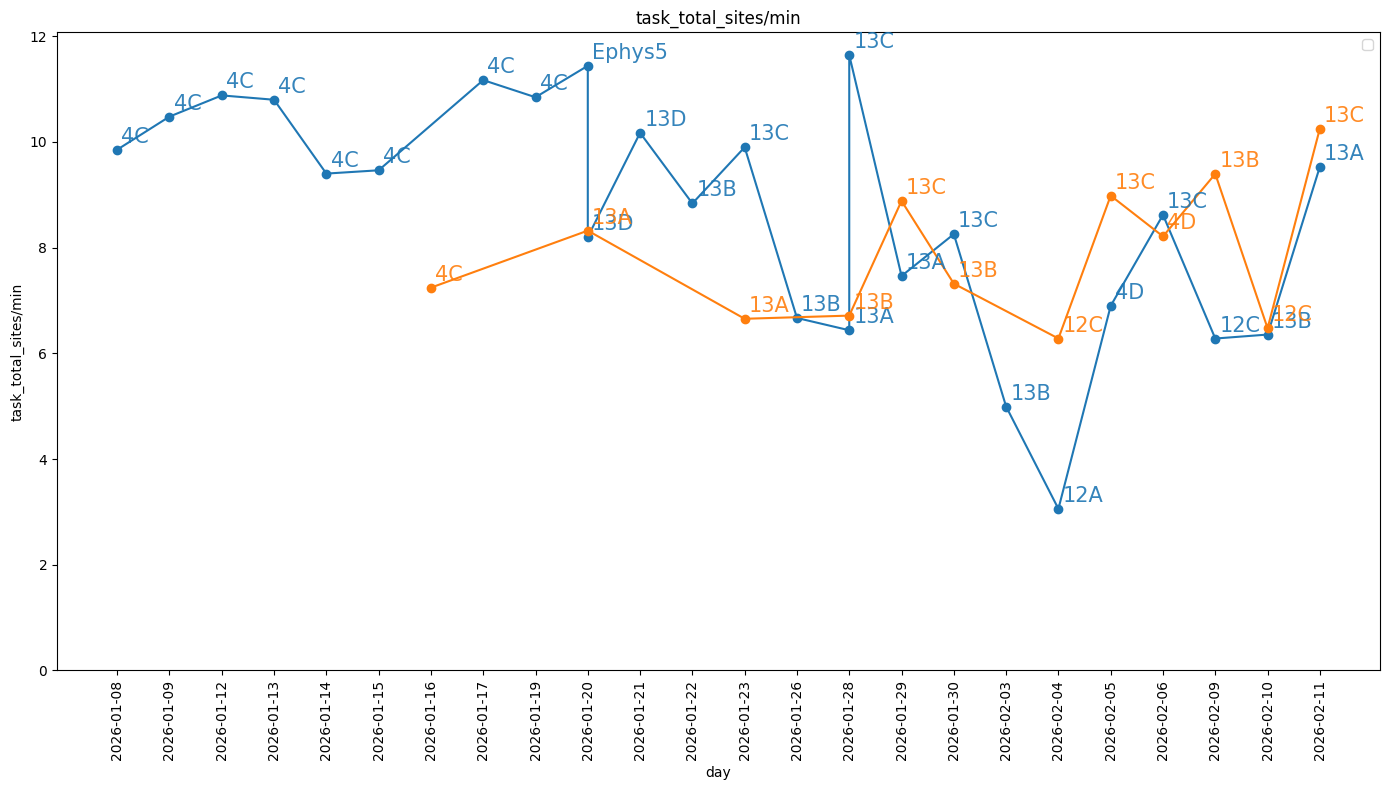

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


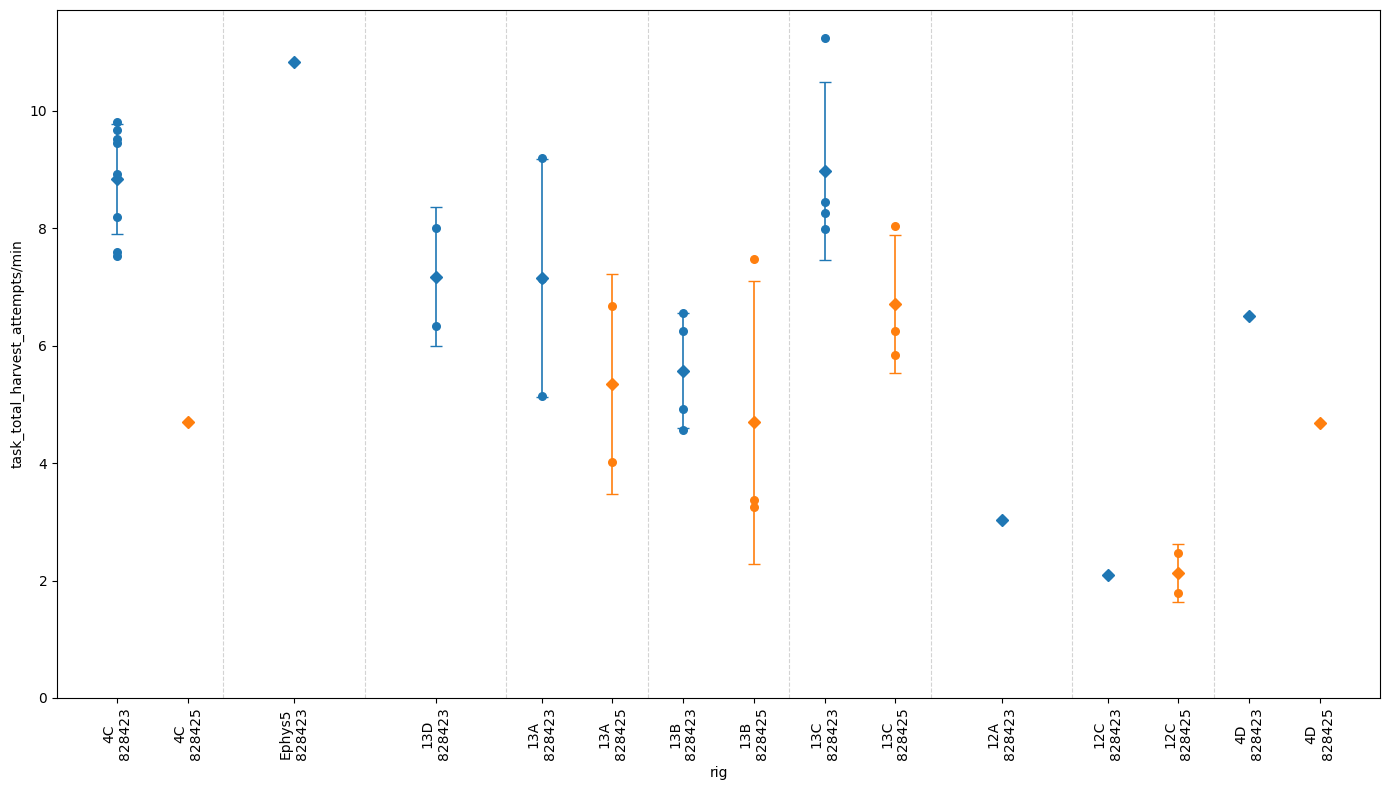

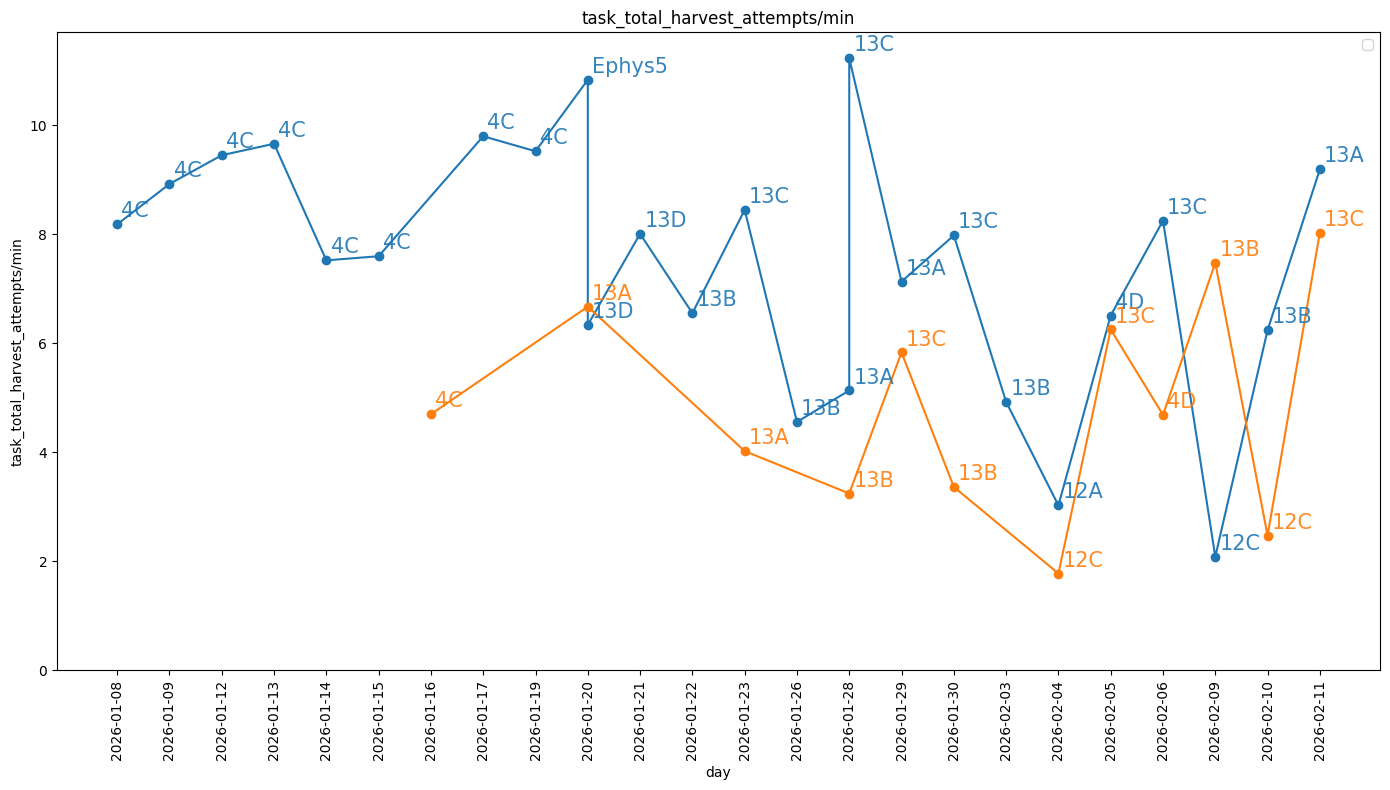

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


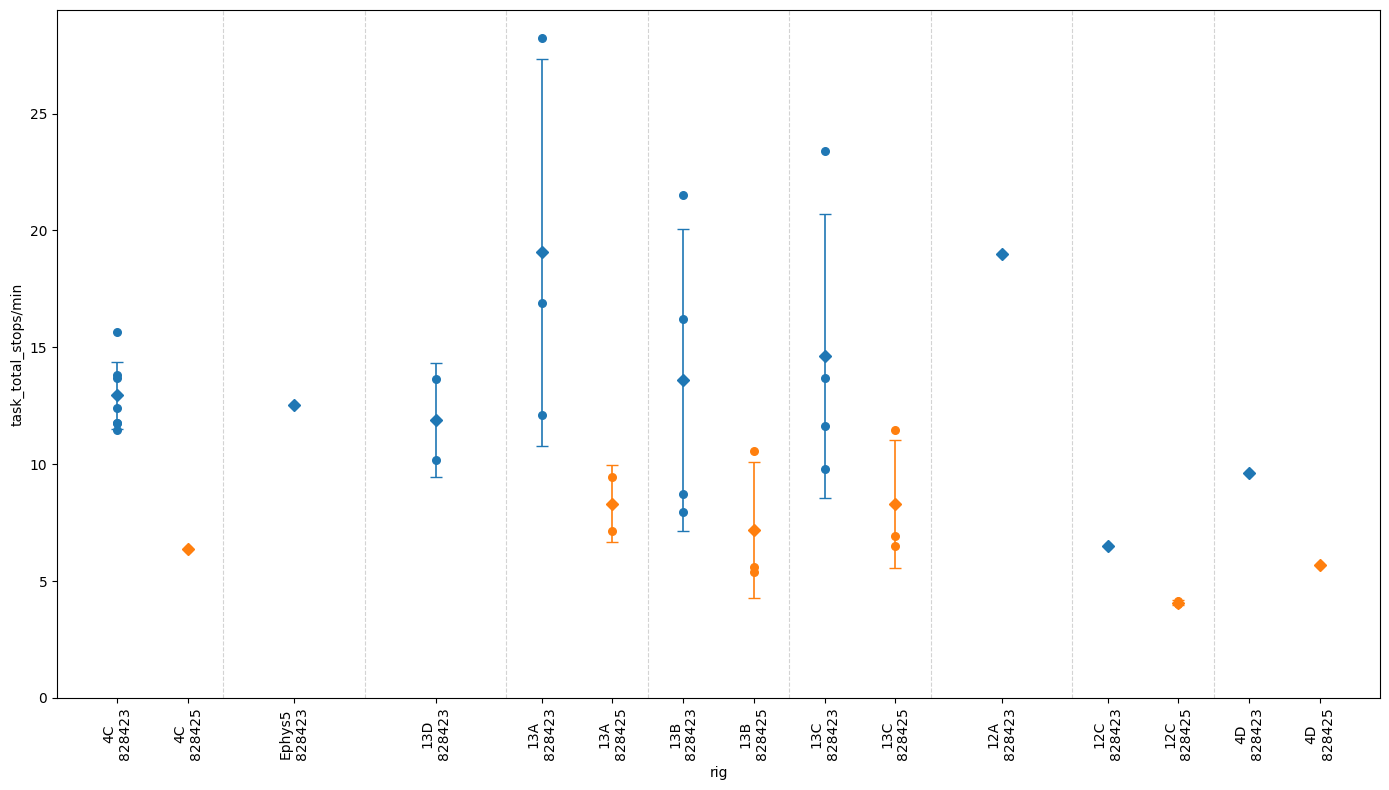

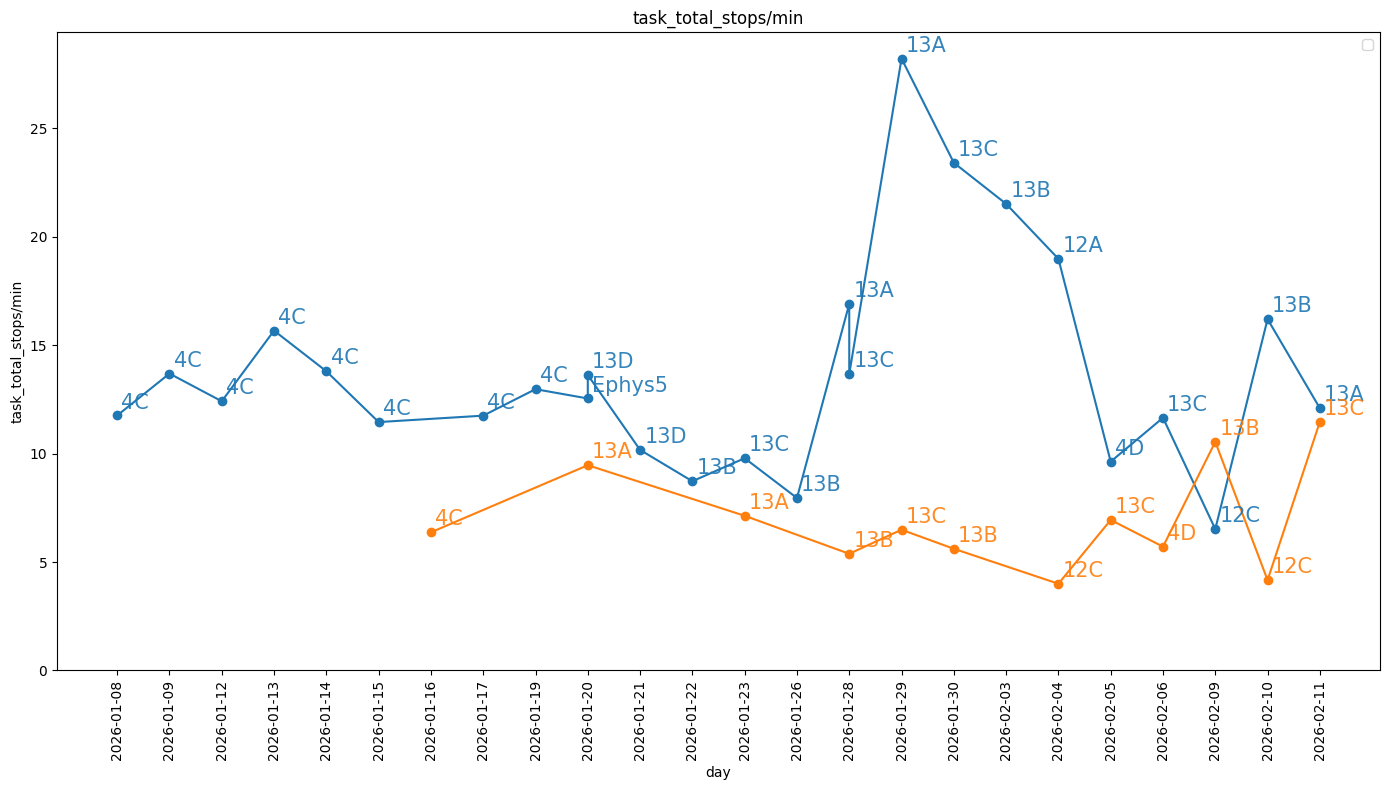

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


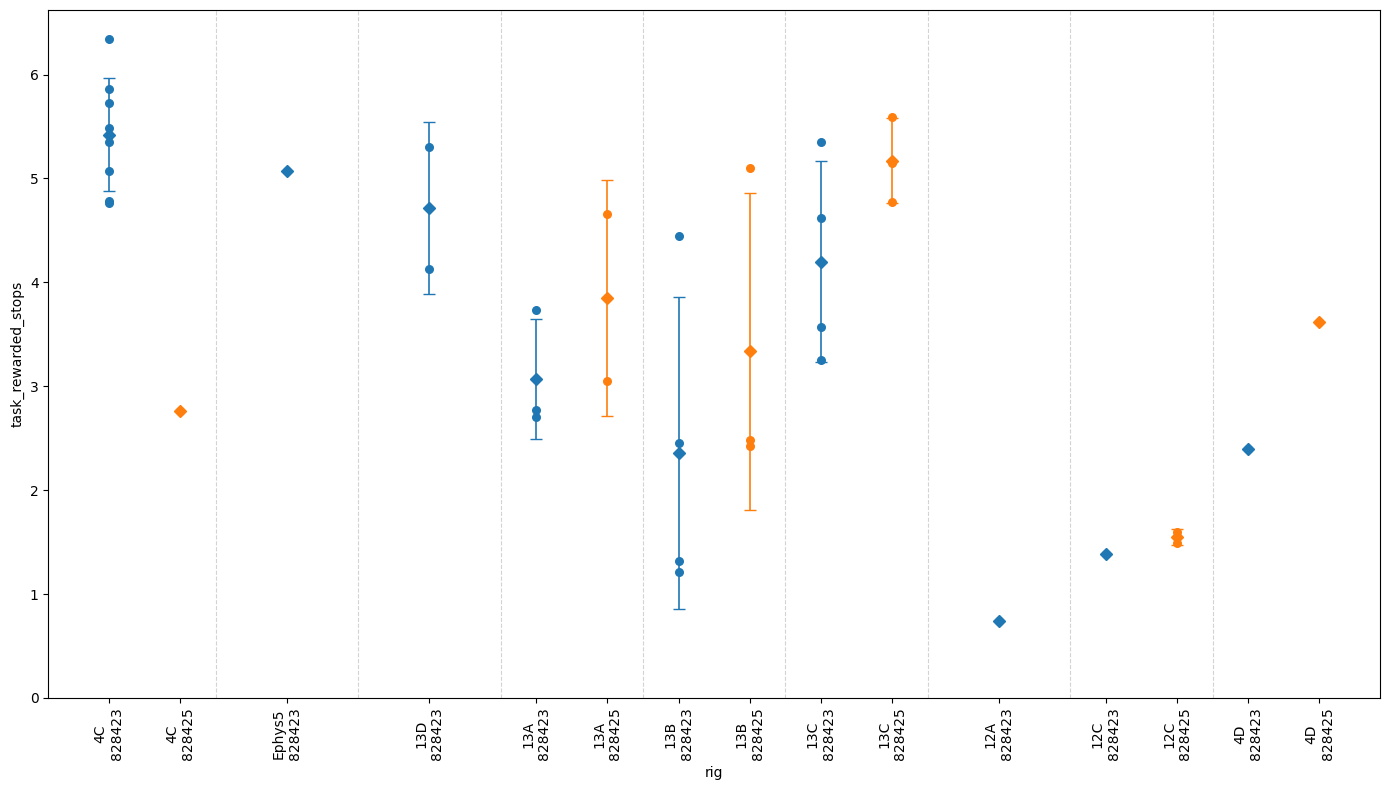

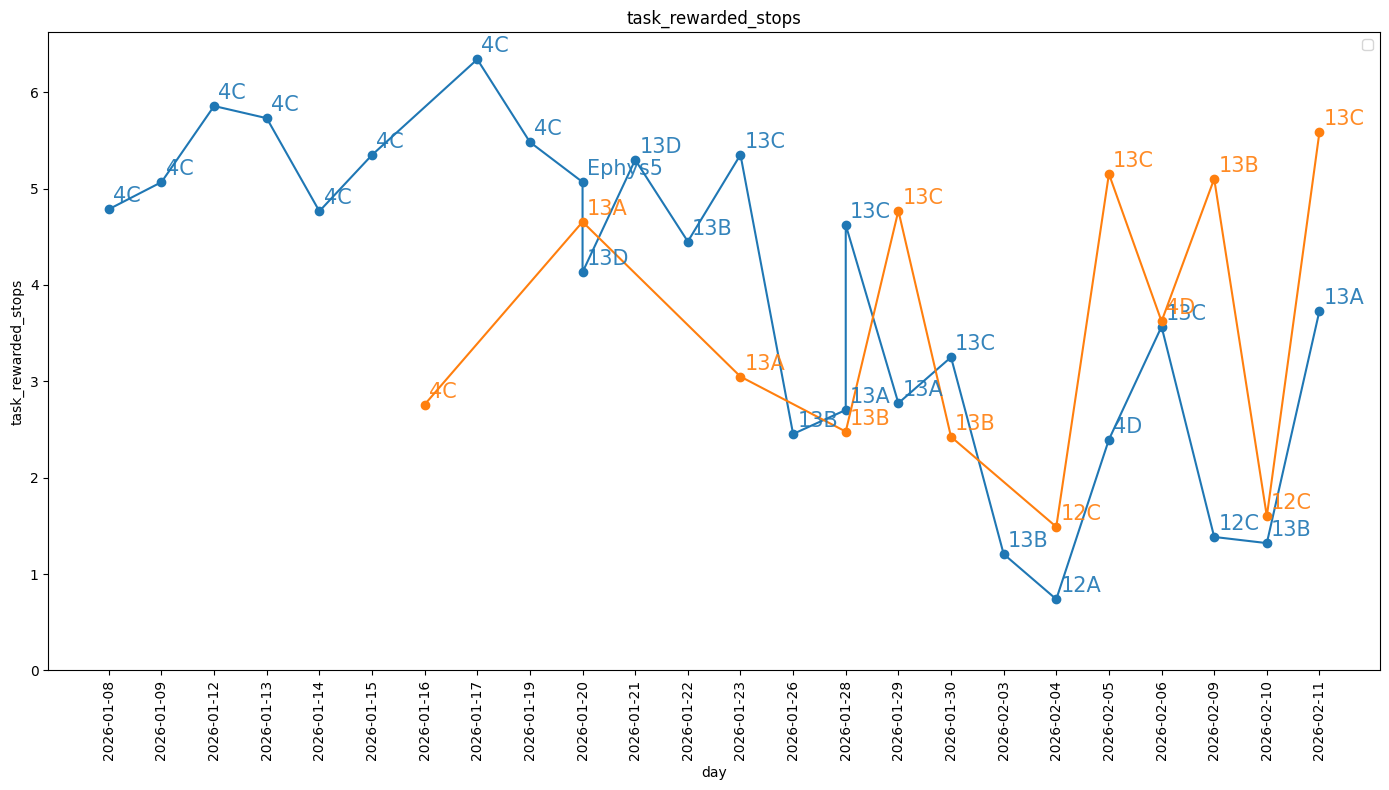

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


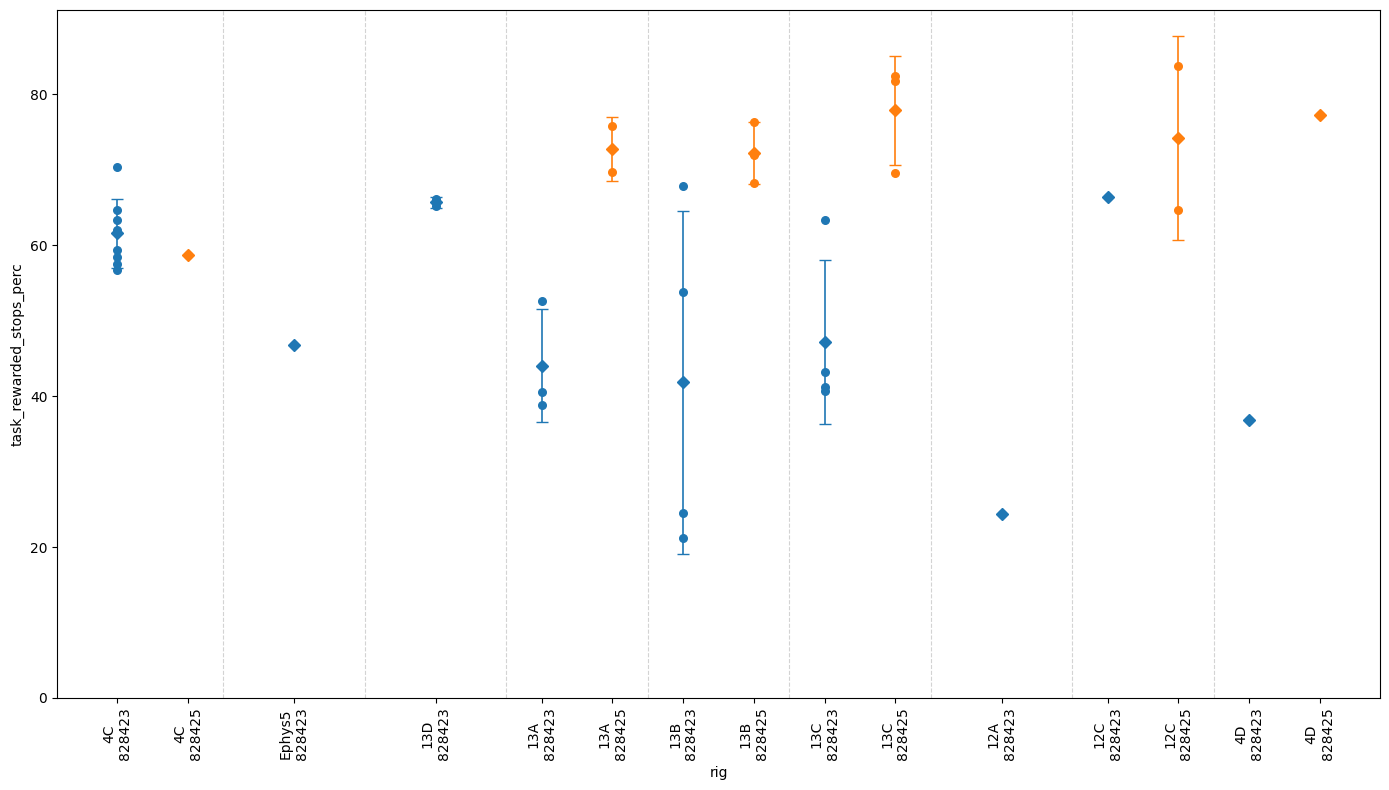

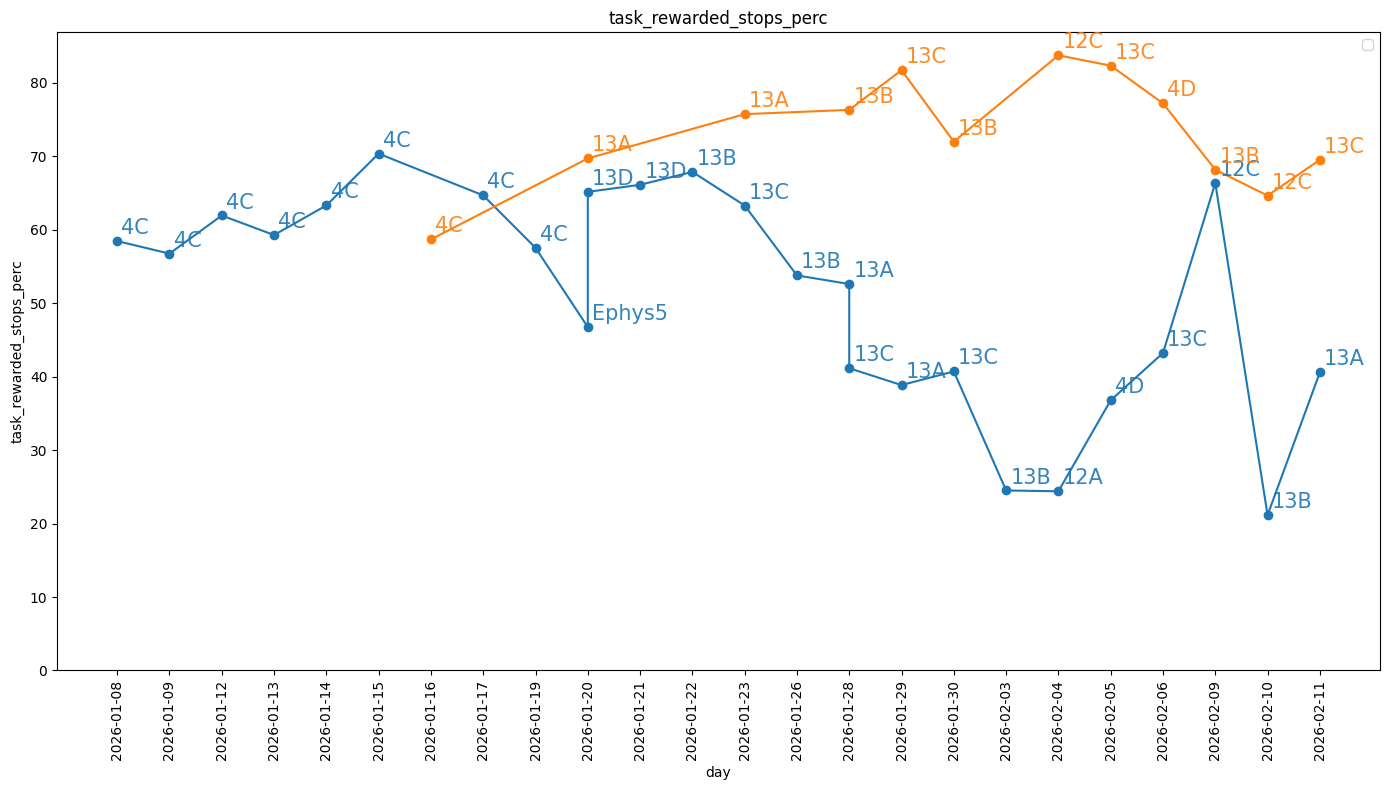

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


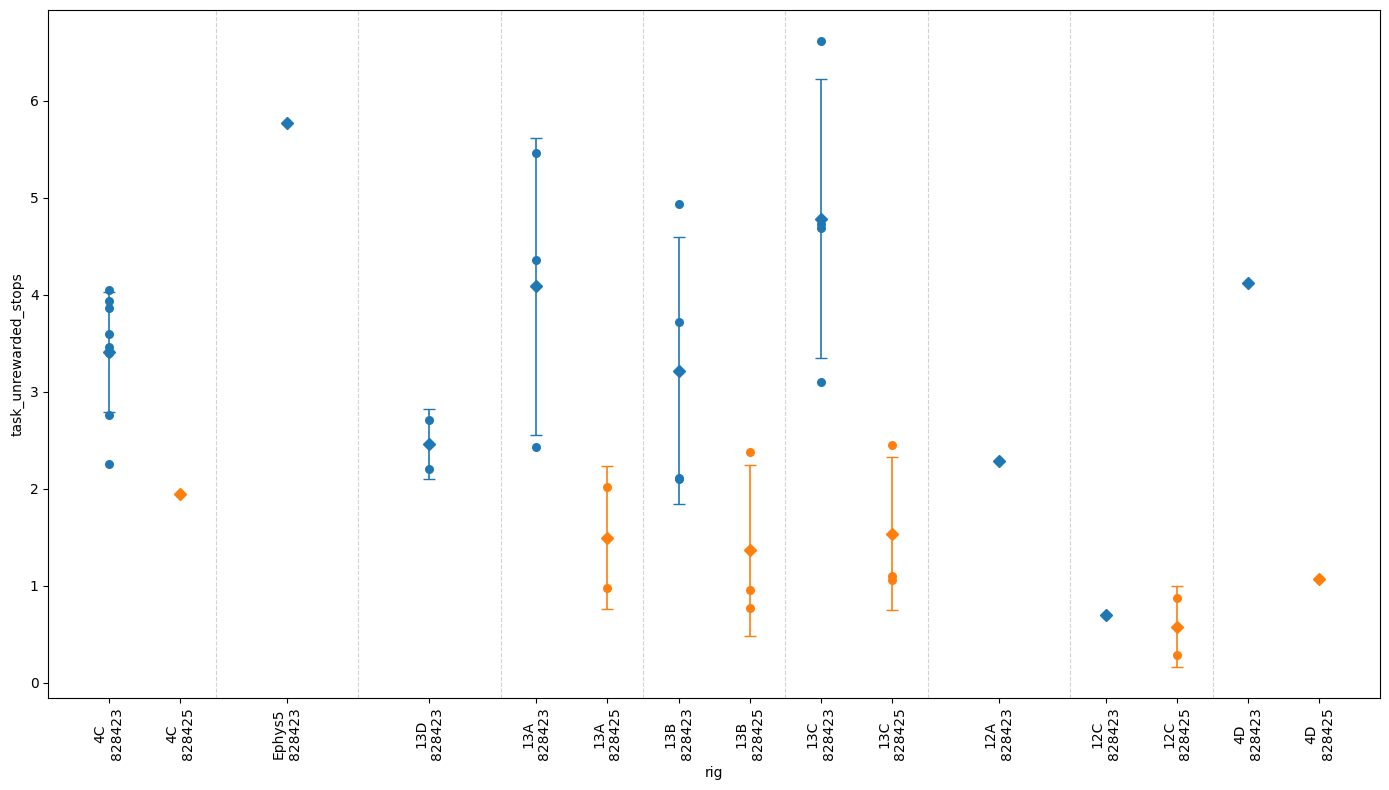

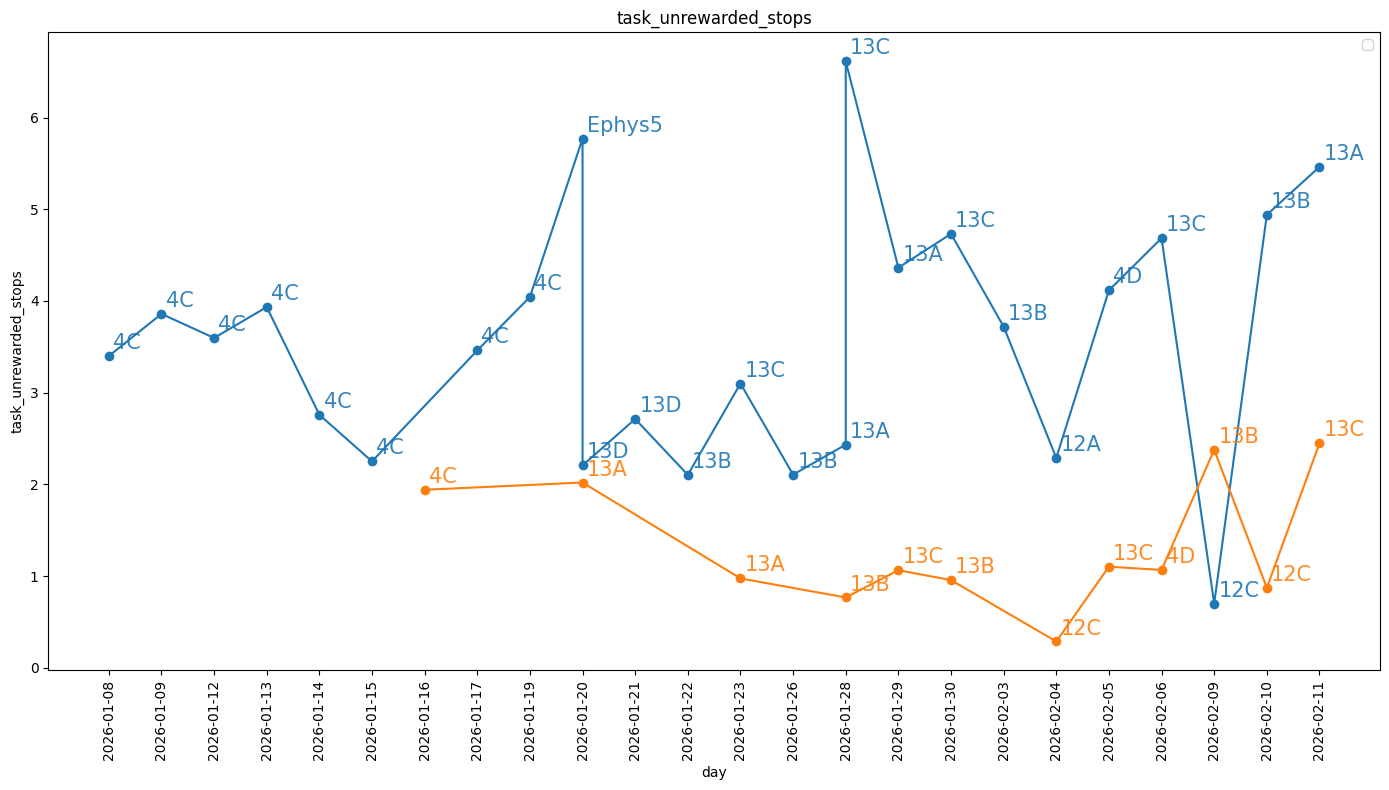

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


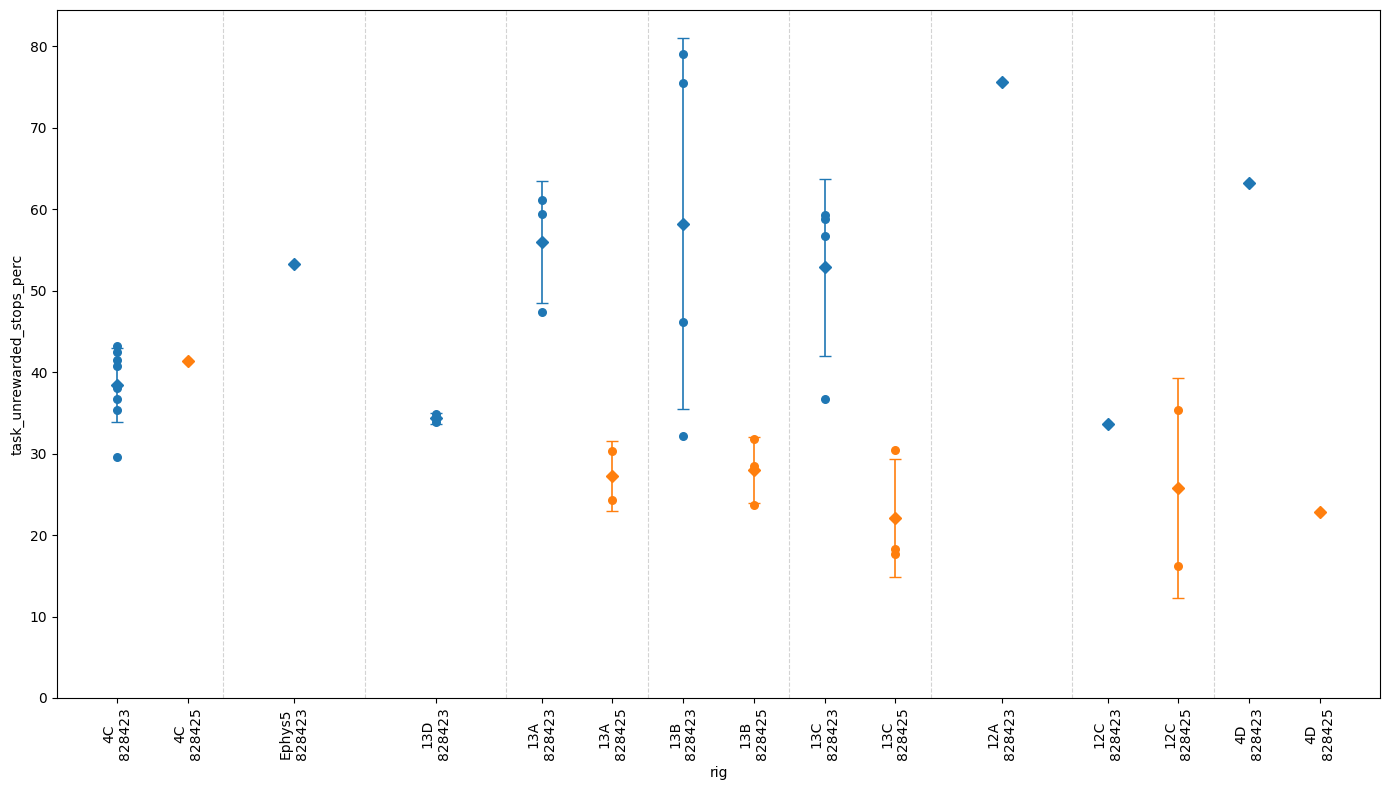

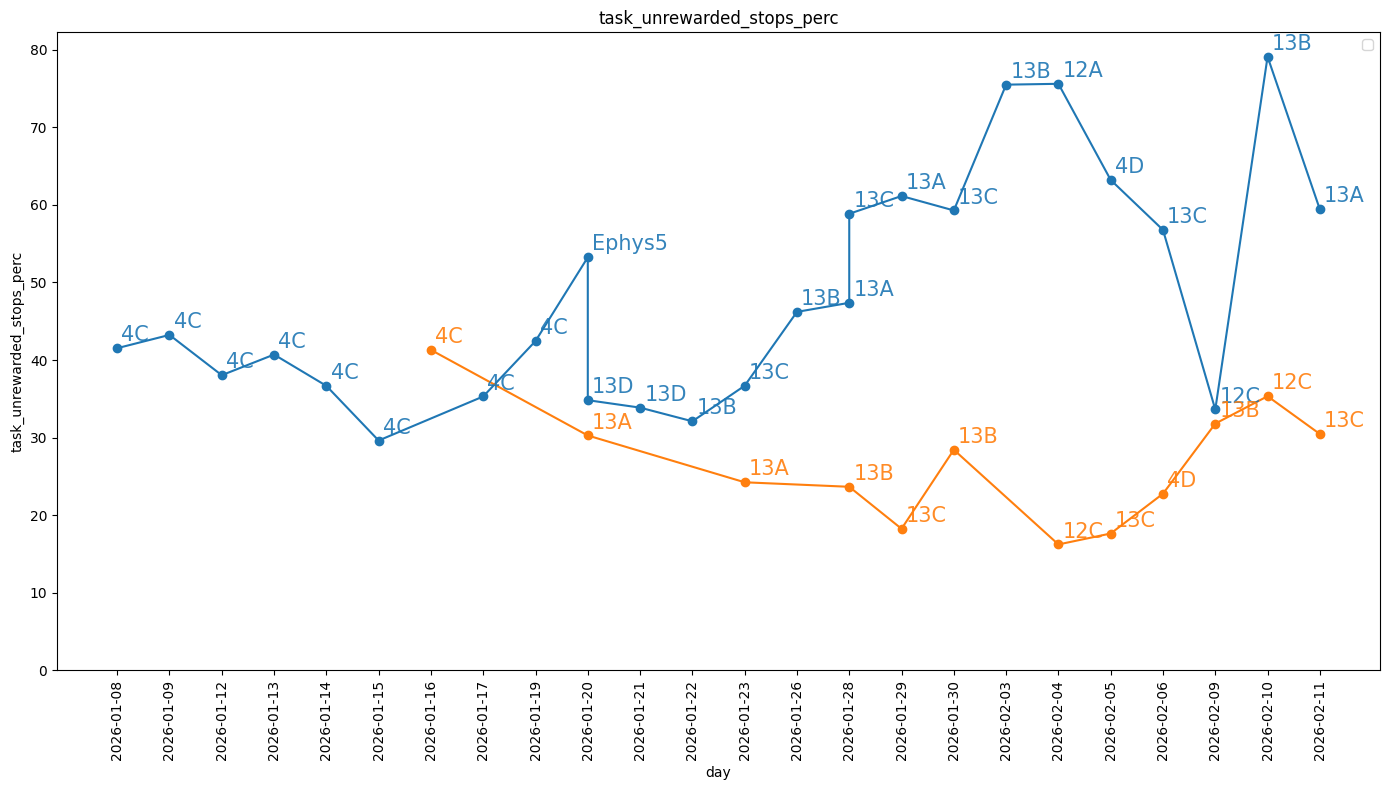

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


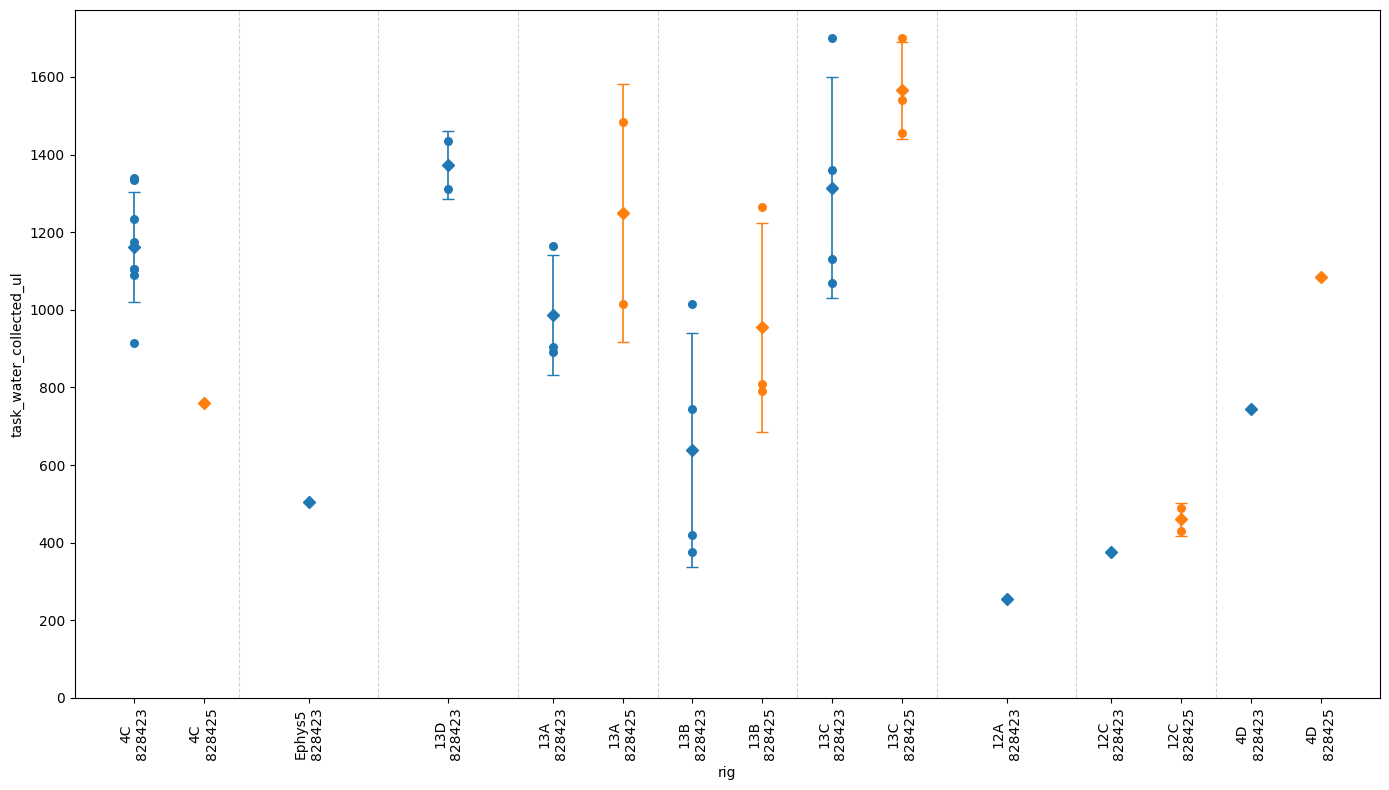

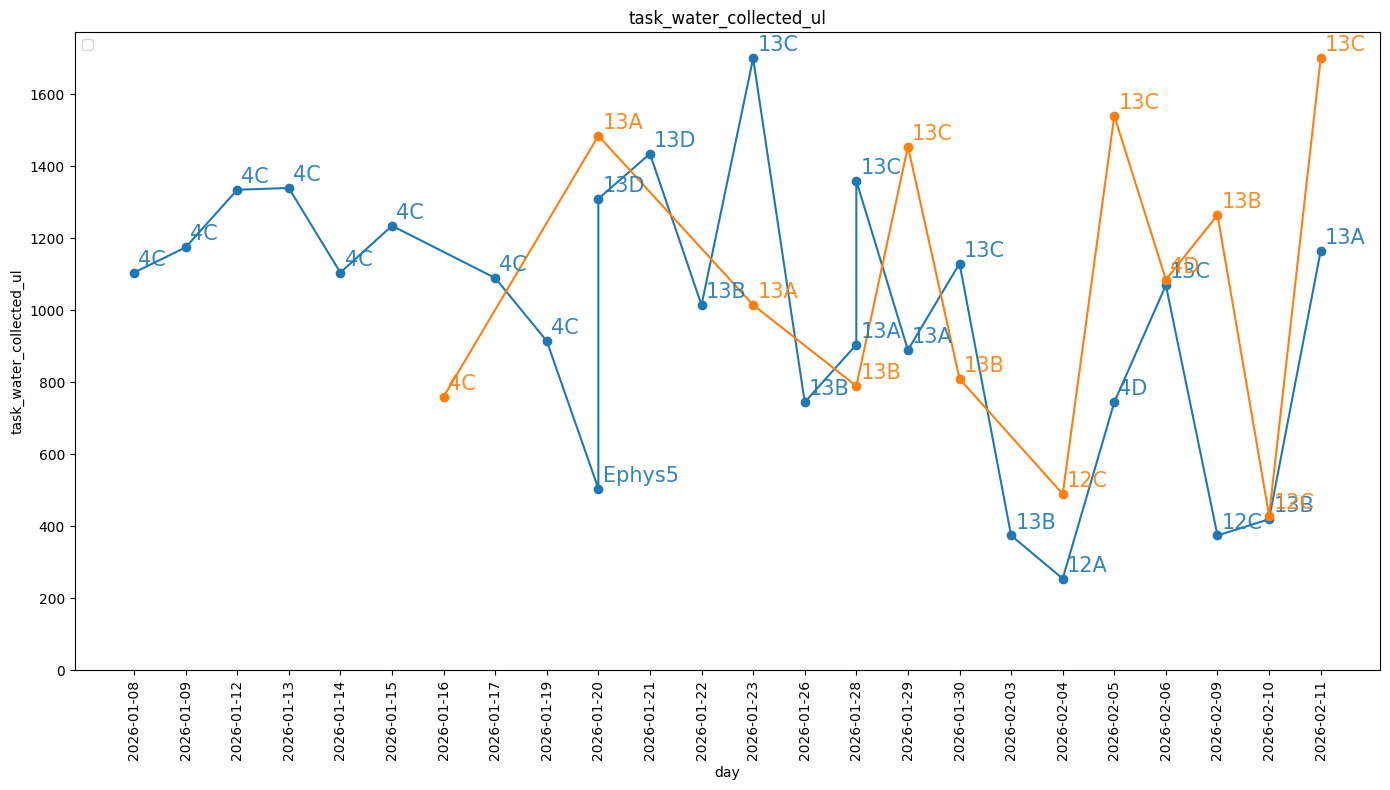

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


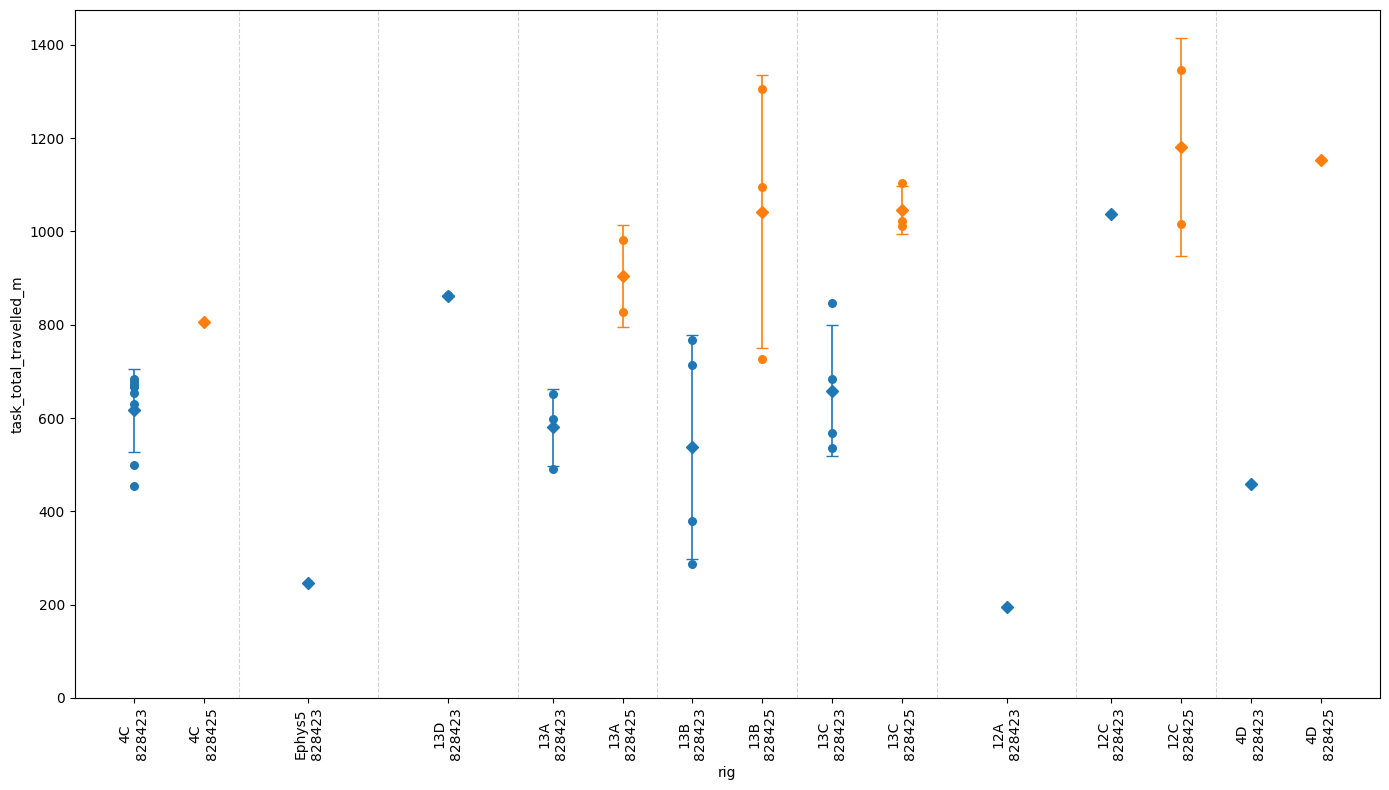

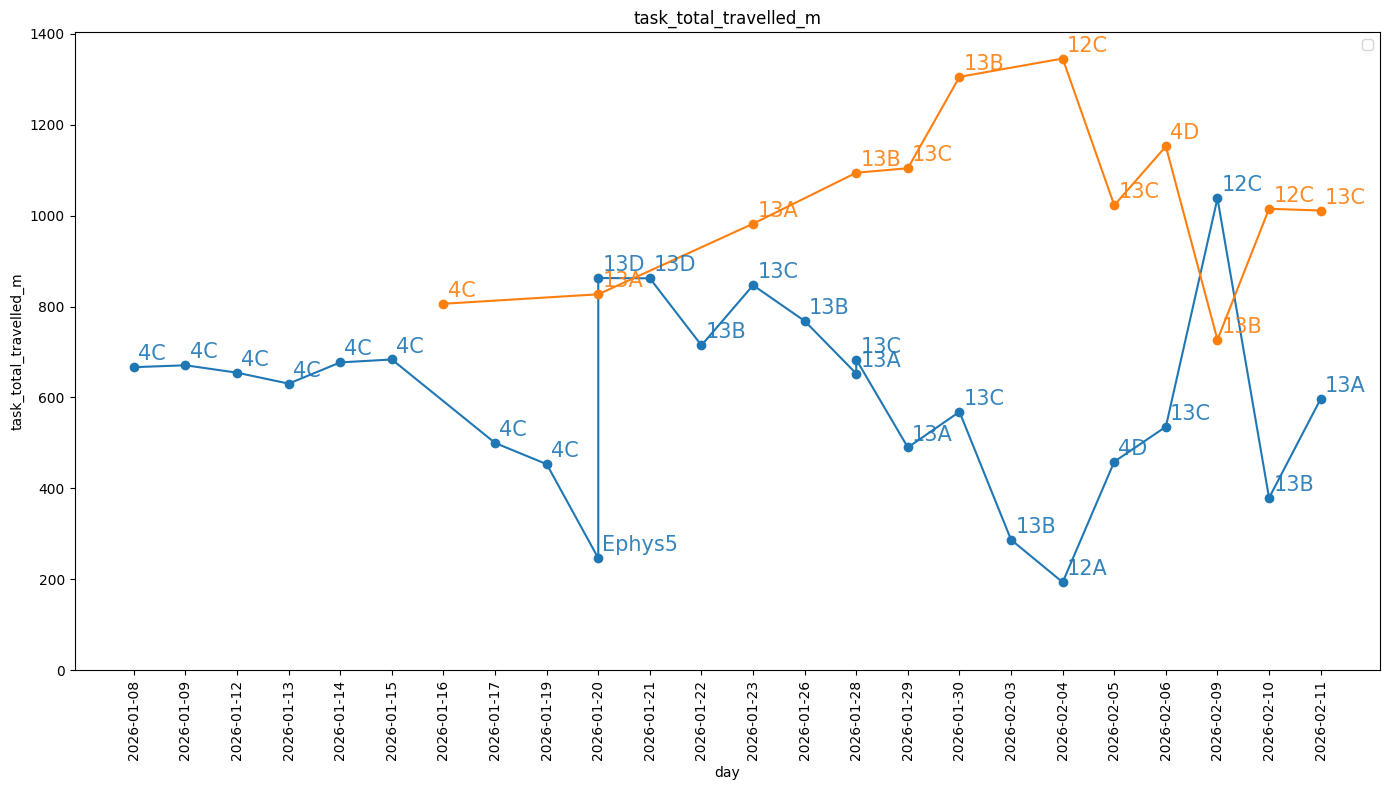

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


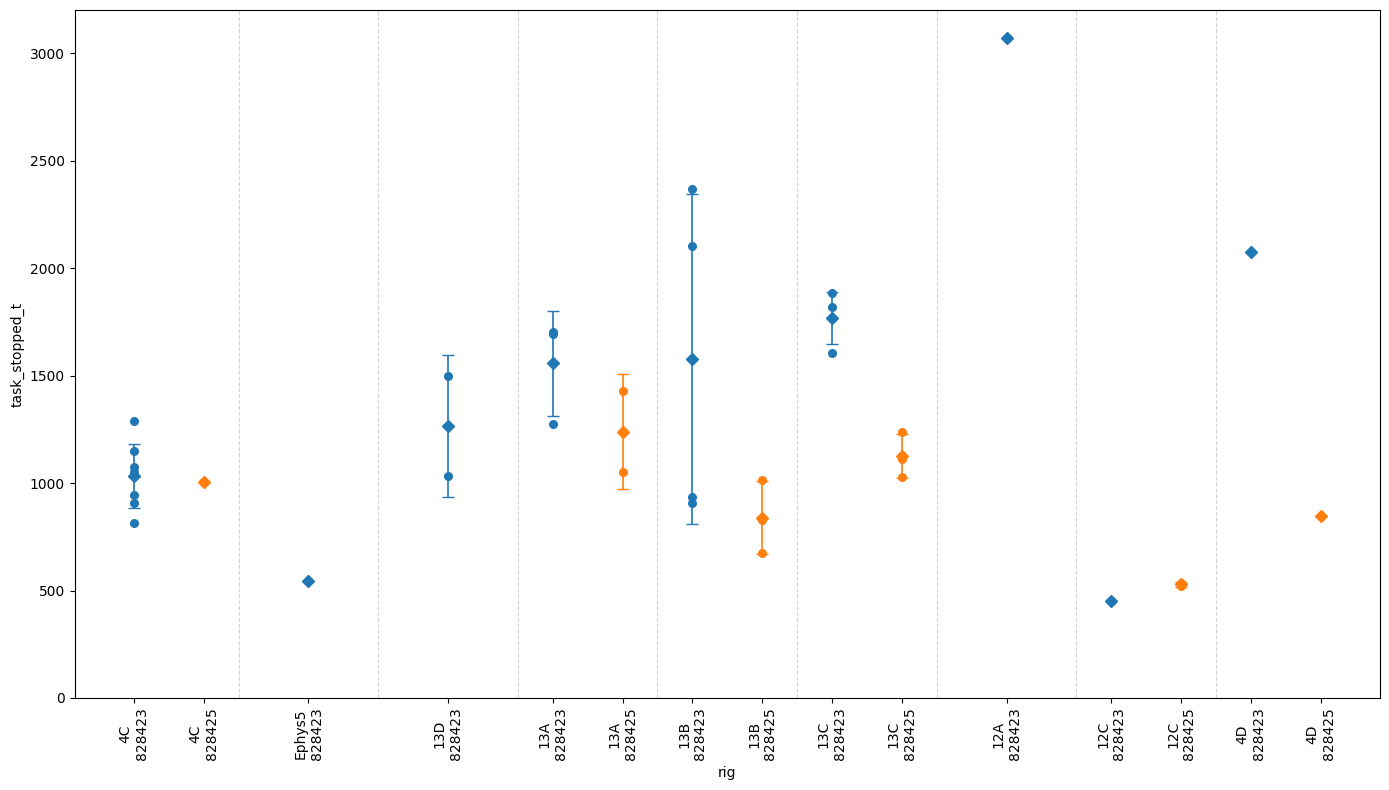

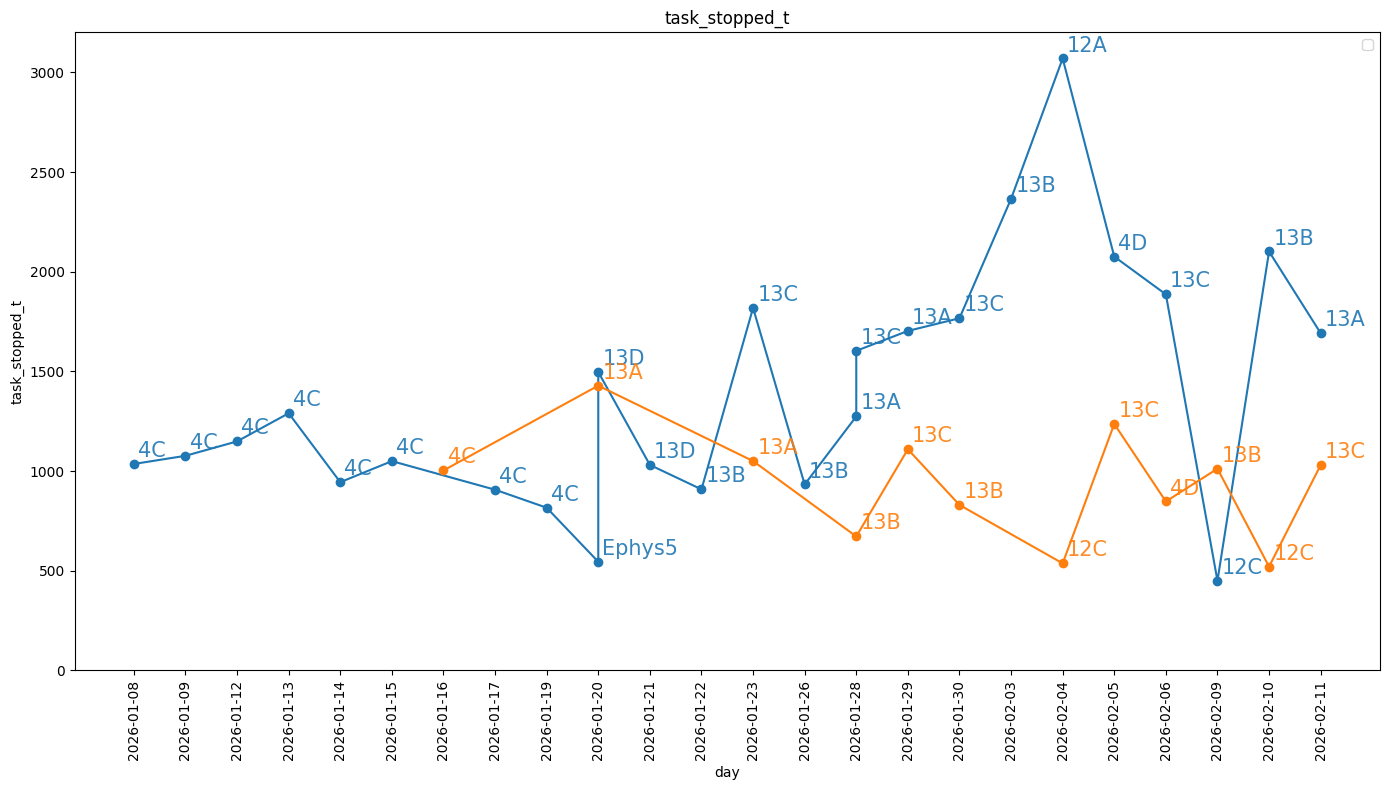

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


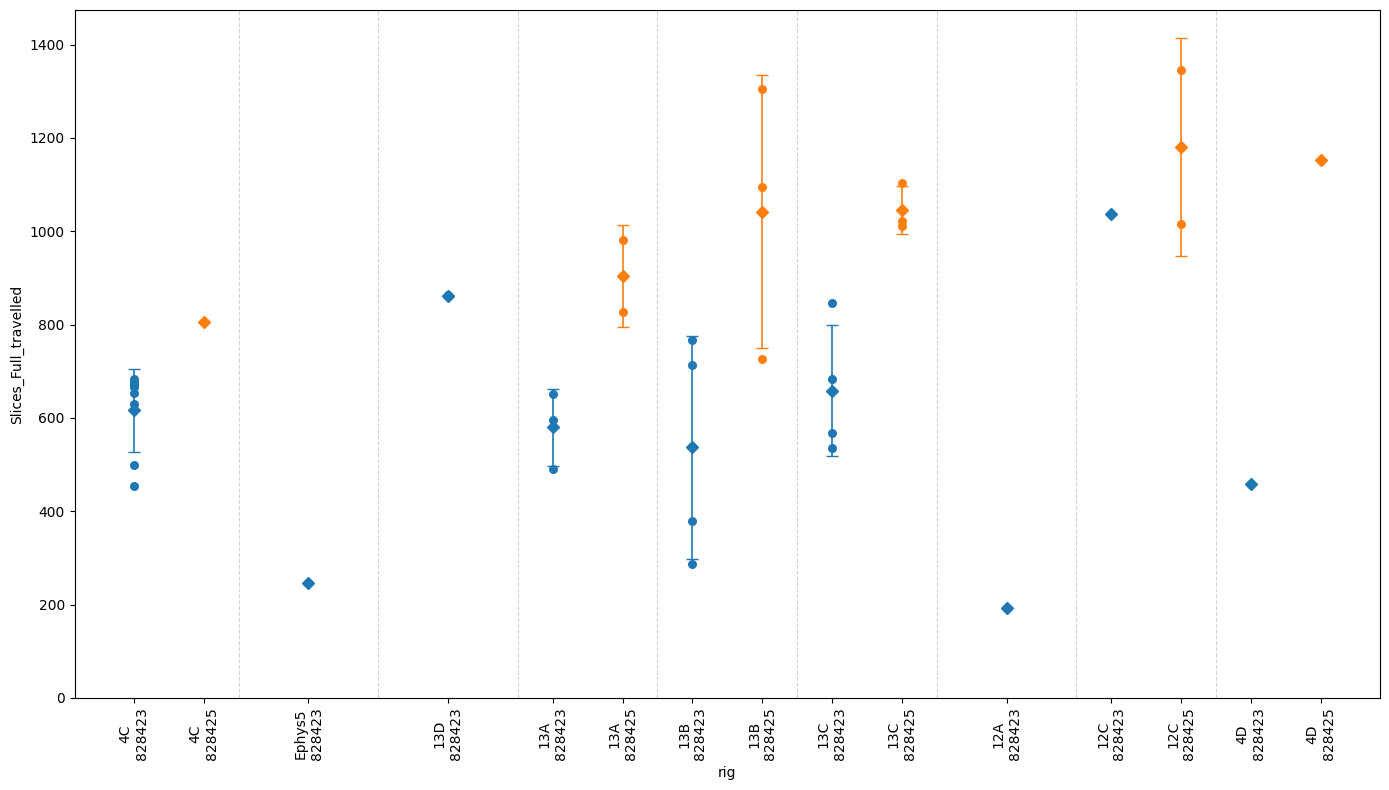

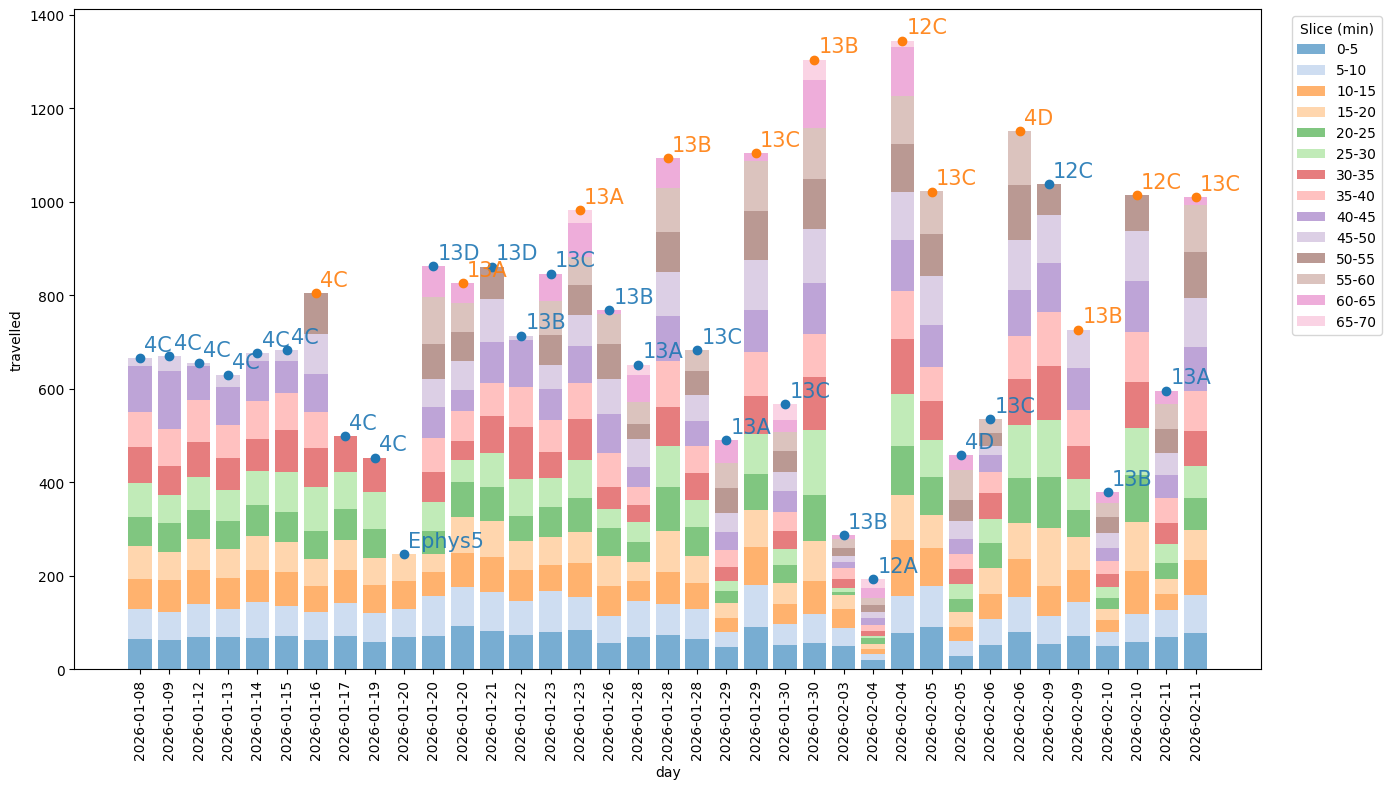

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


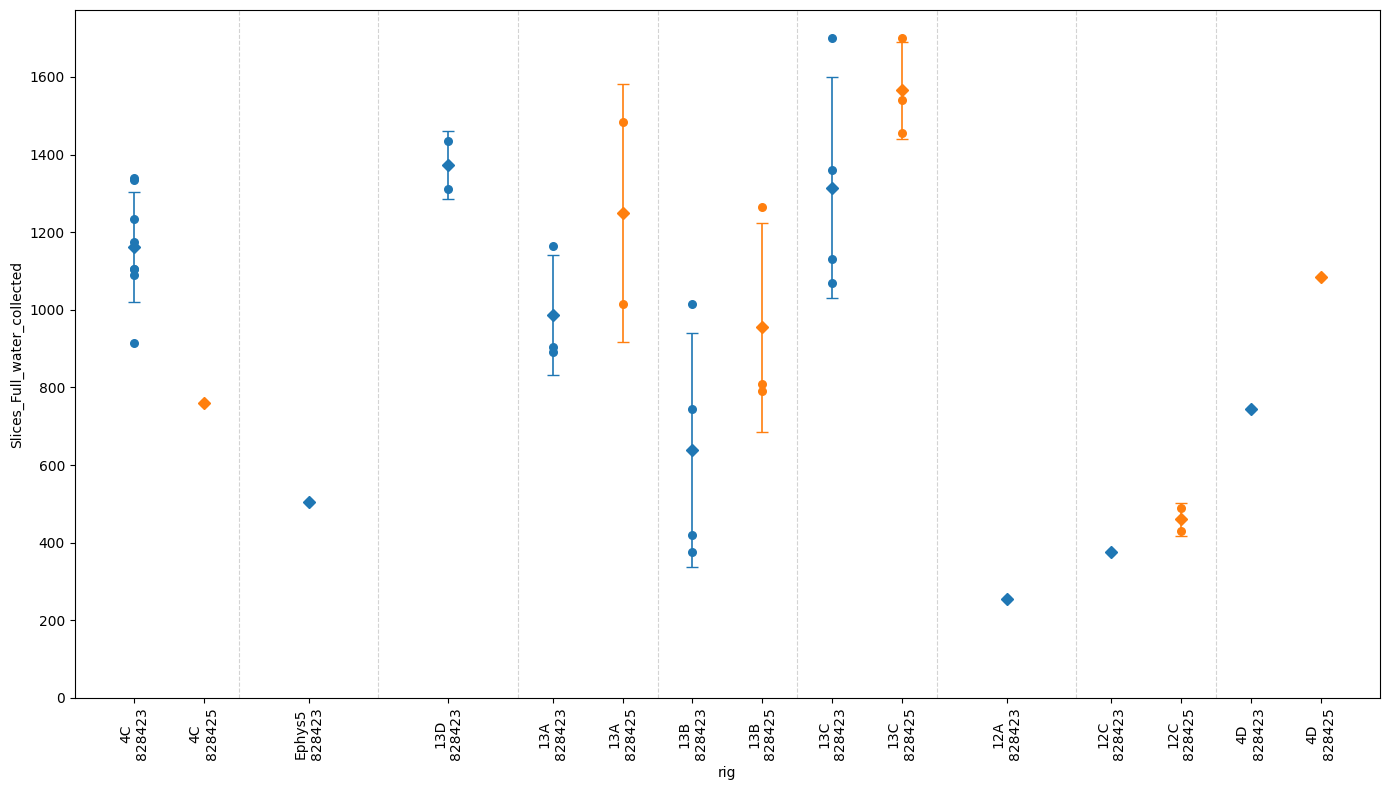

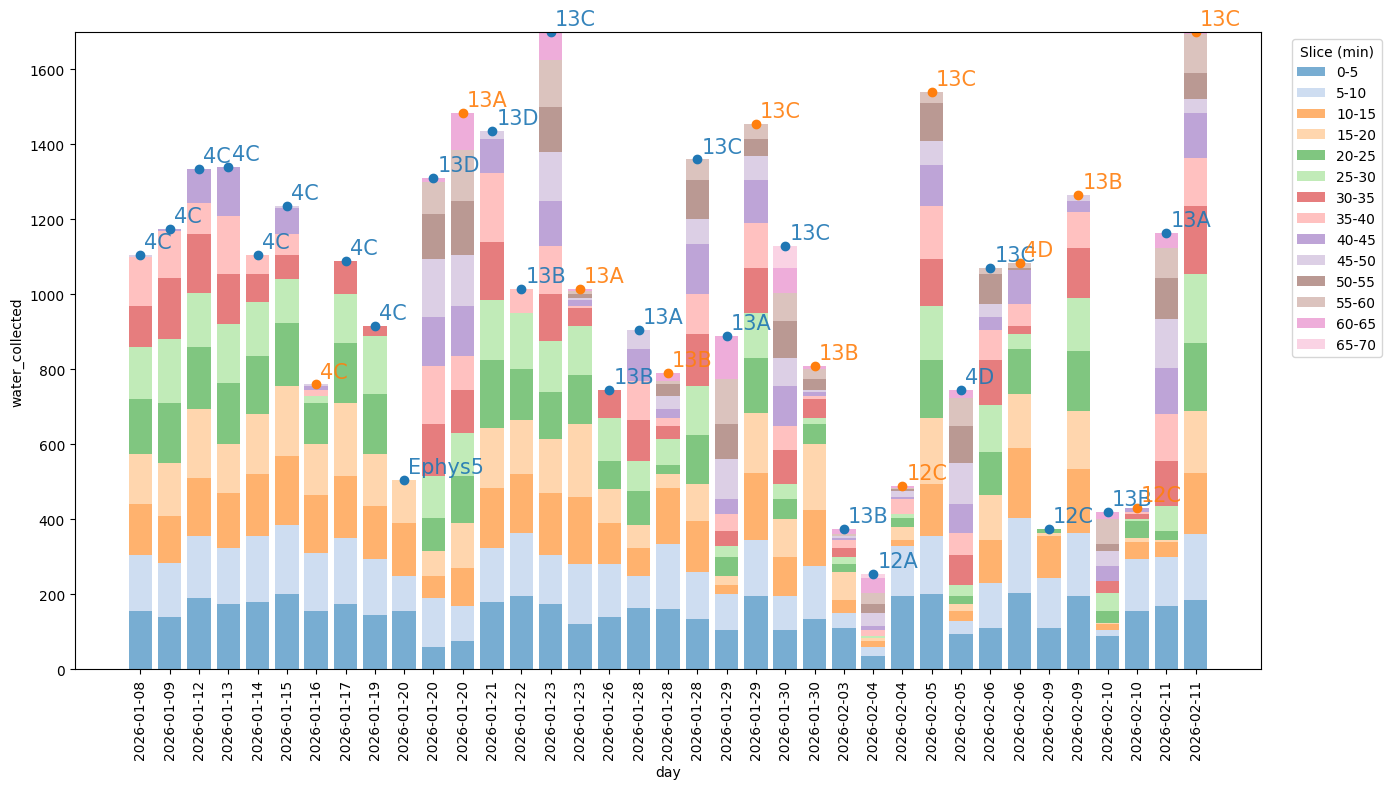

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


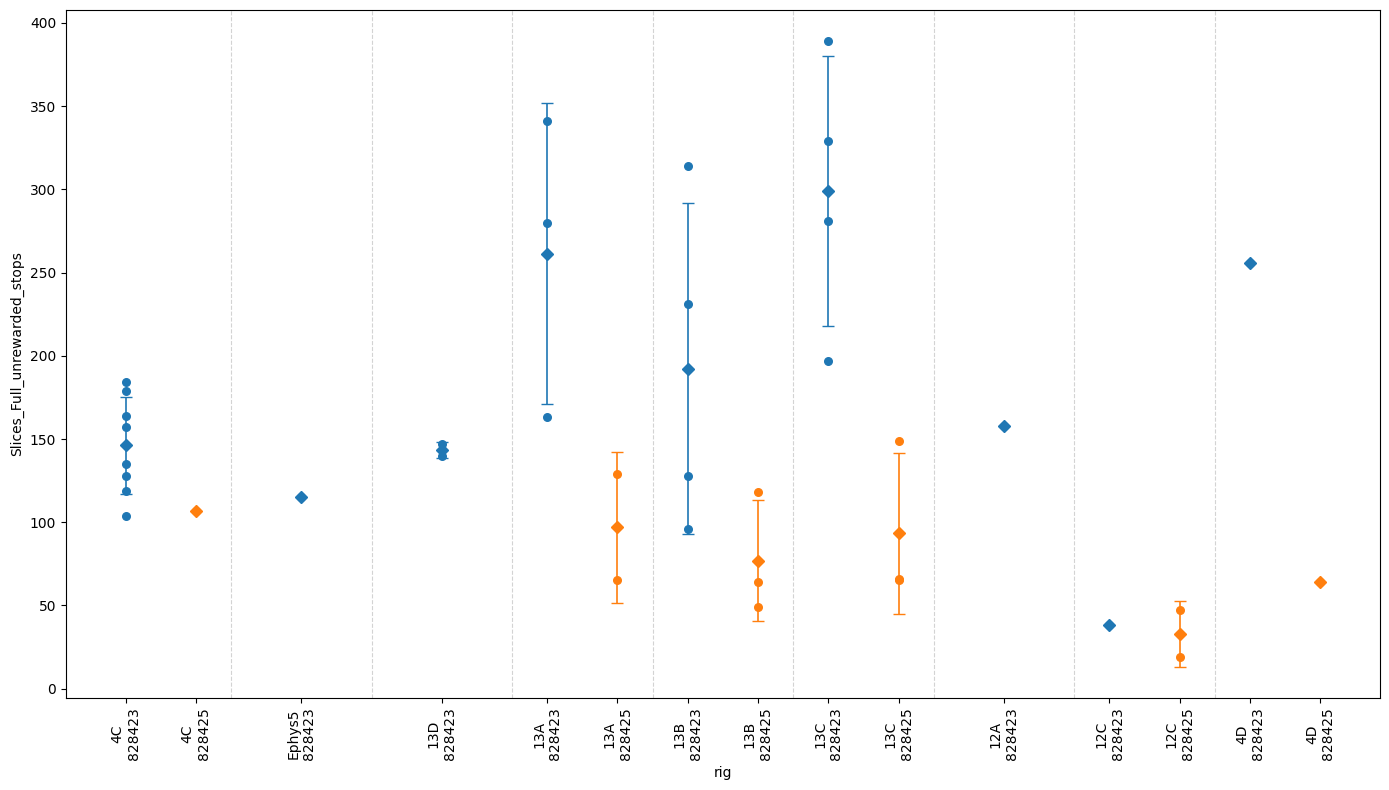

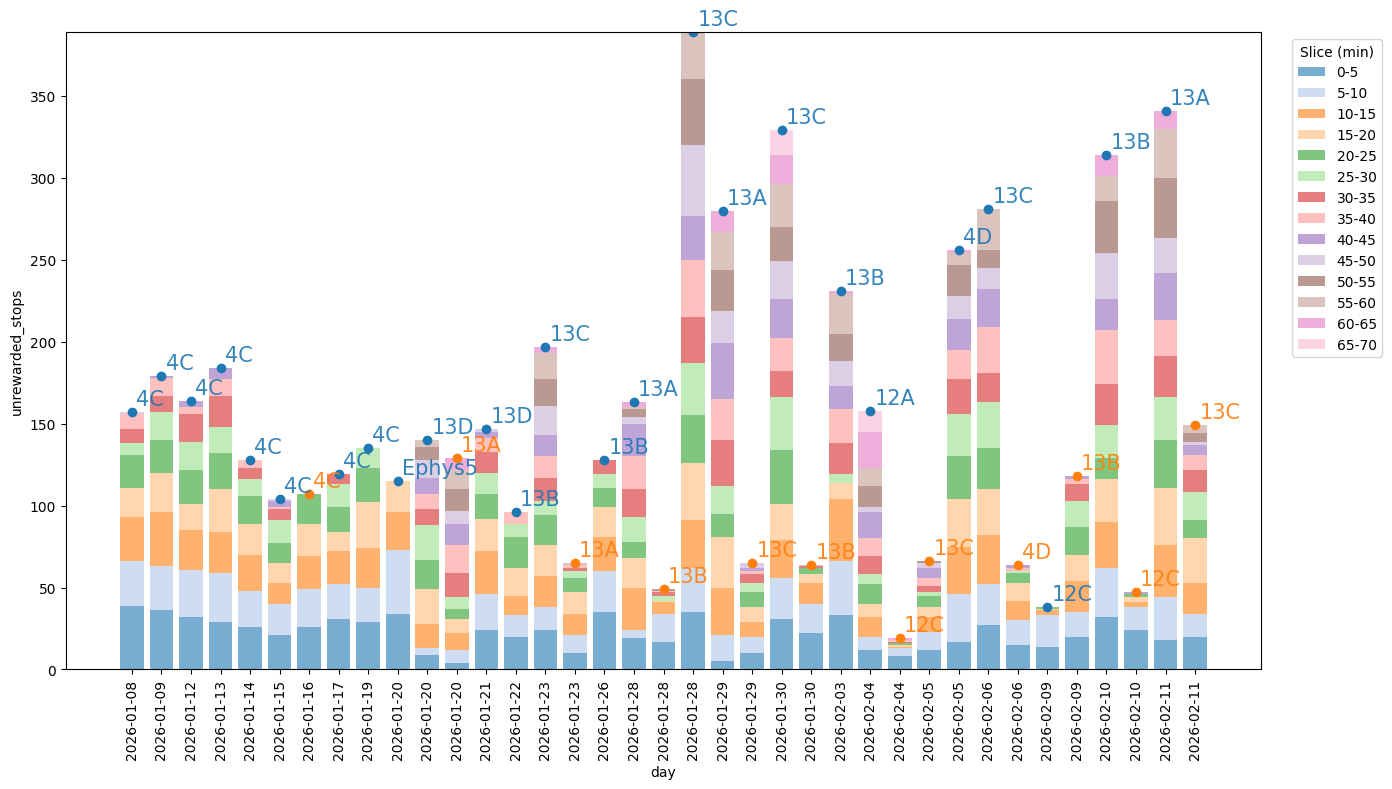

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


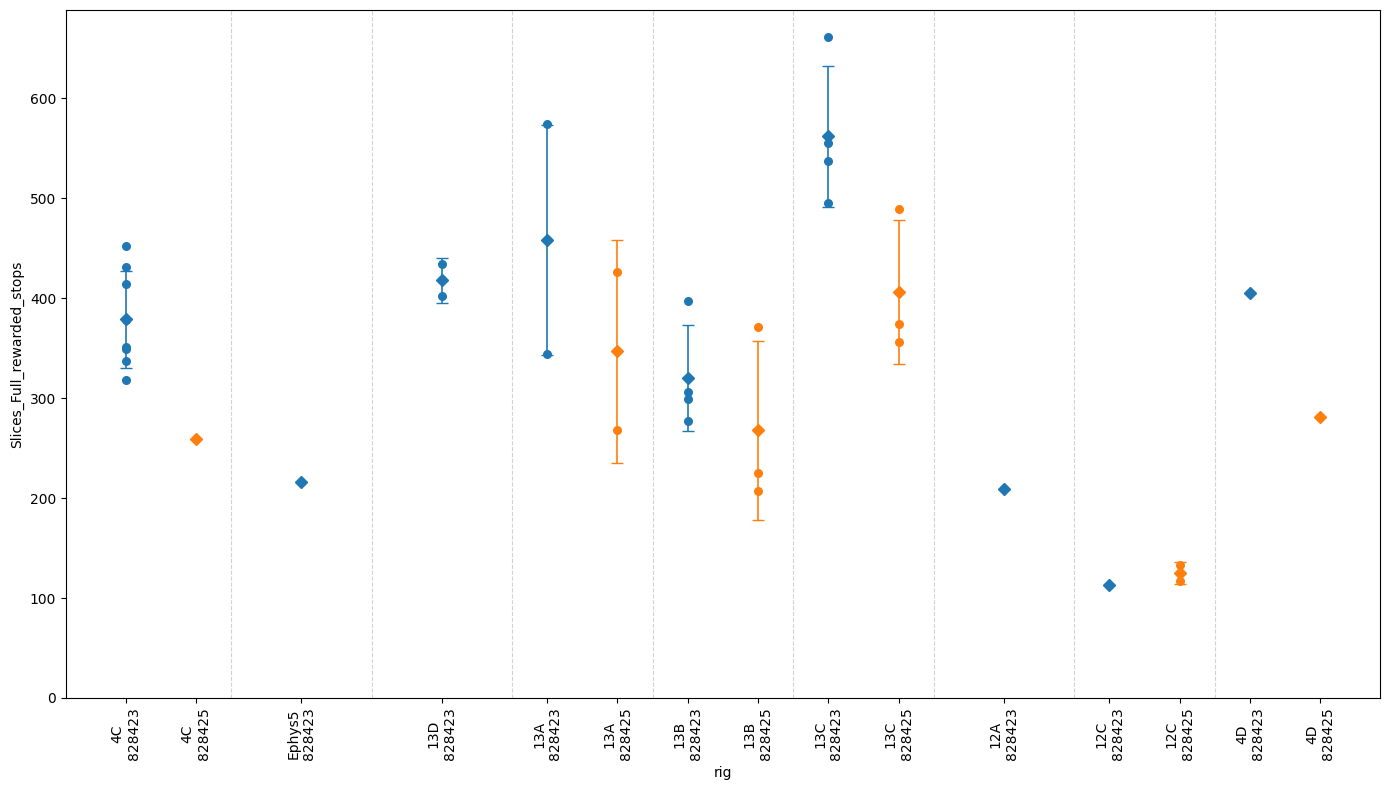

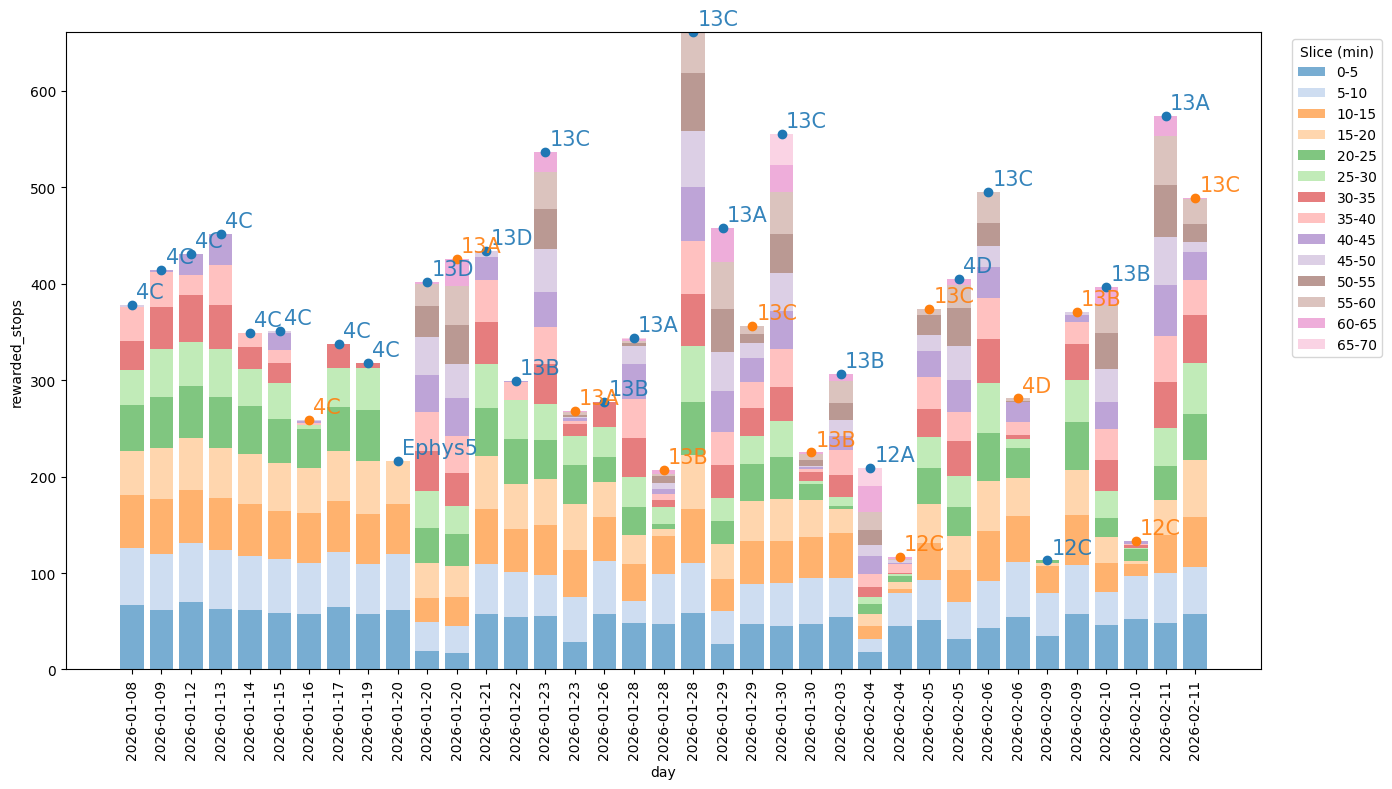

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


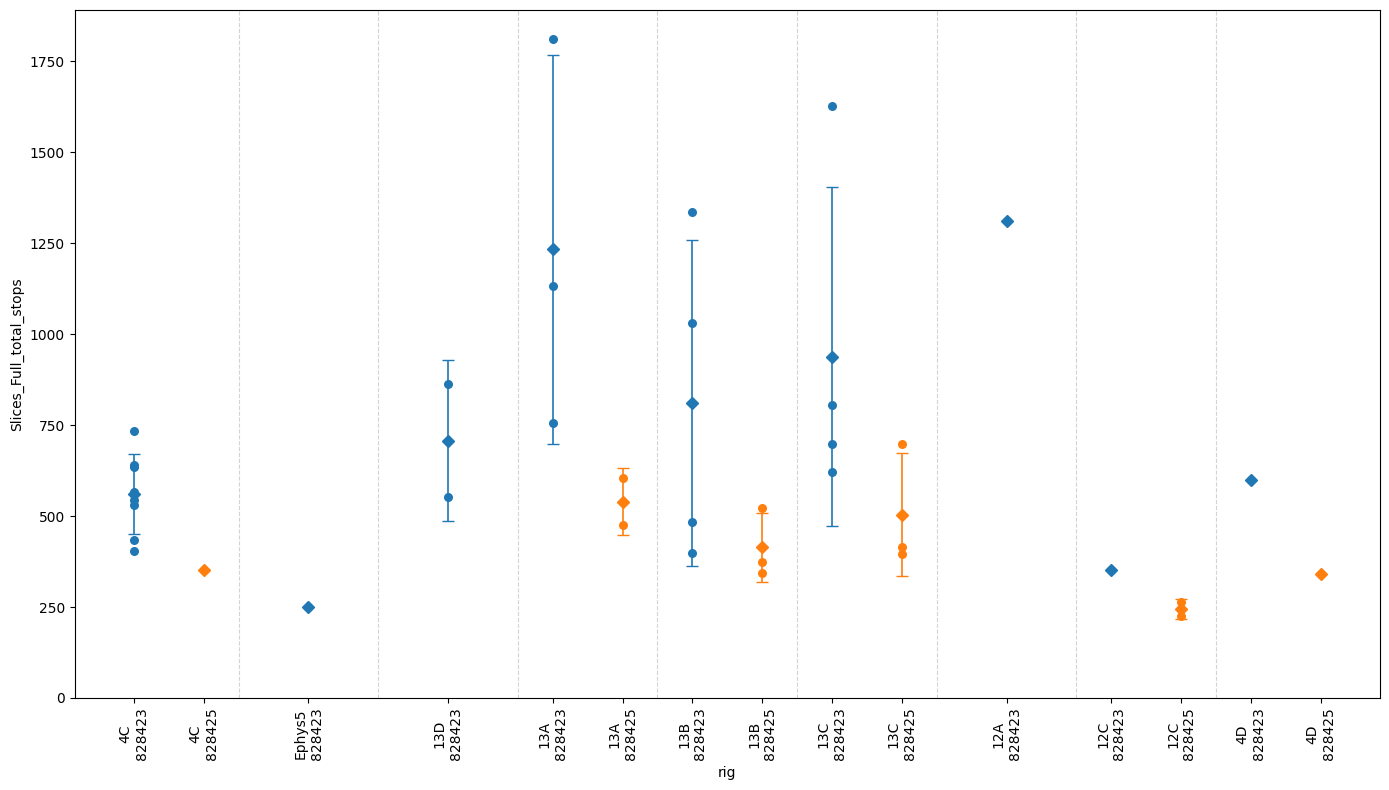

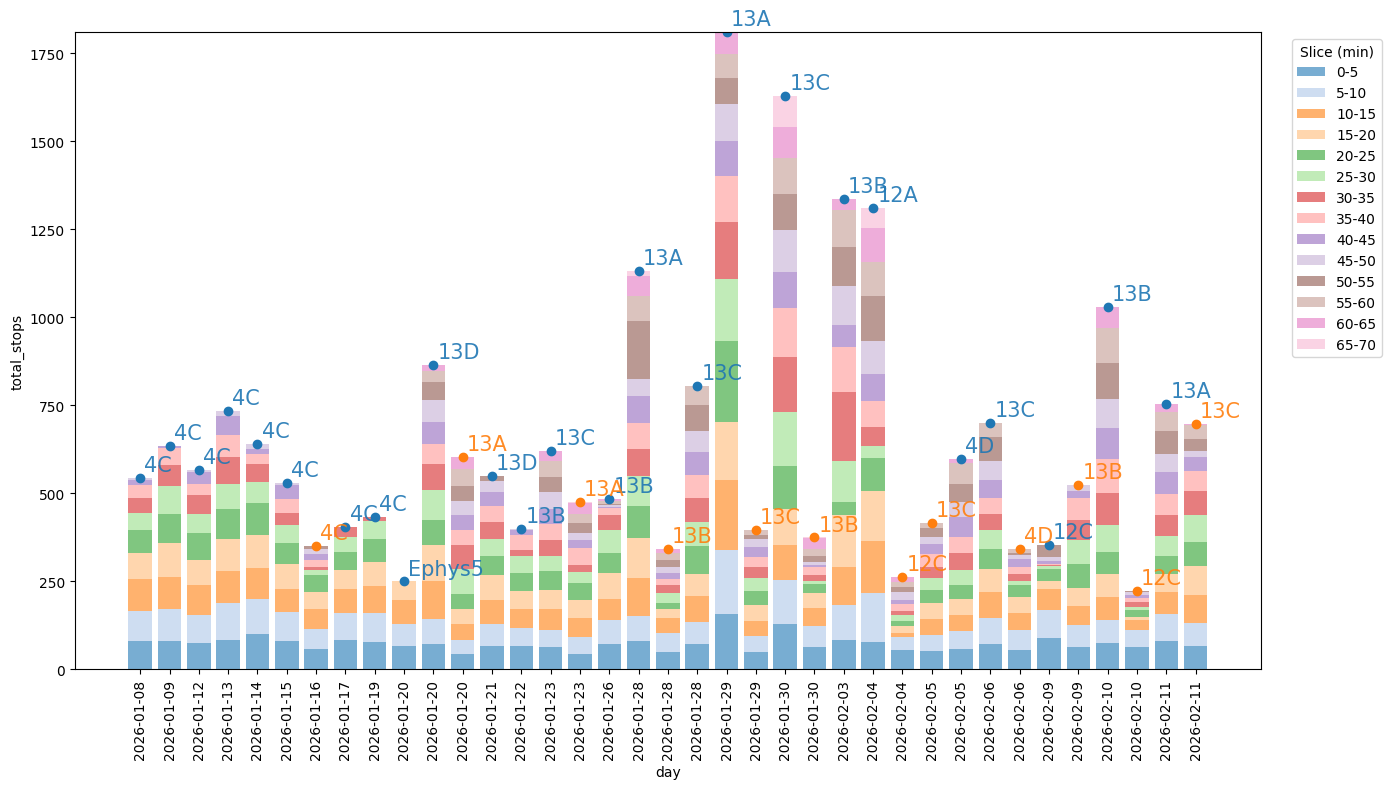

['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]
['828423']
[0.0]
['828423', '828425']
[-0.25, 0.25]
['828423', '828425']
[-0.25, 0.25]


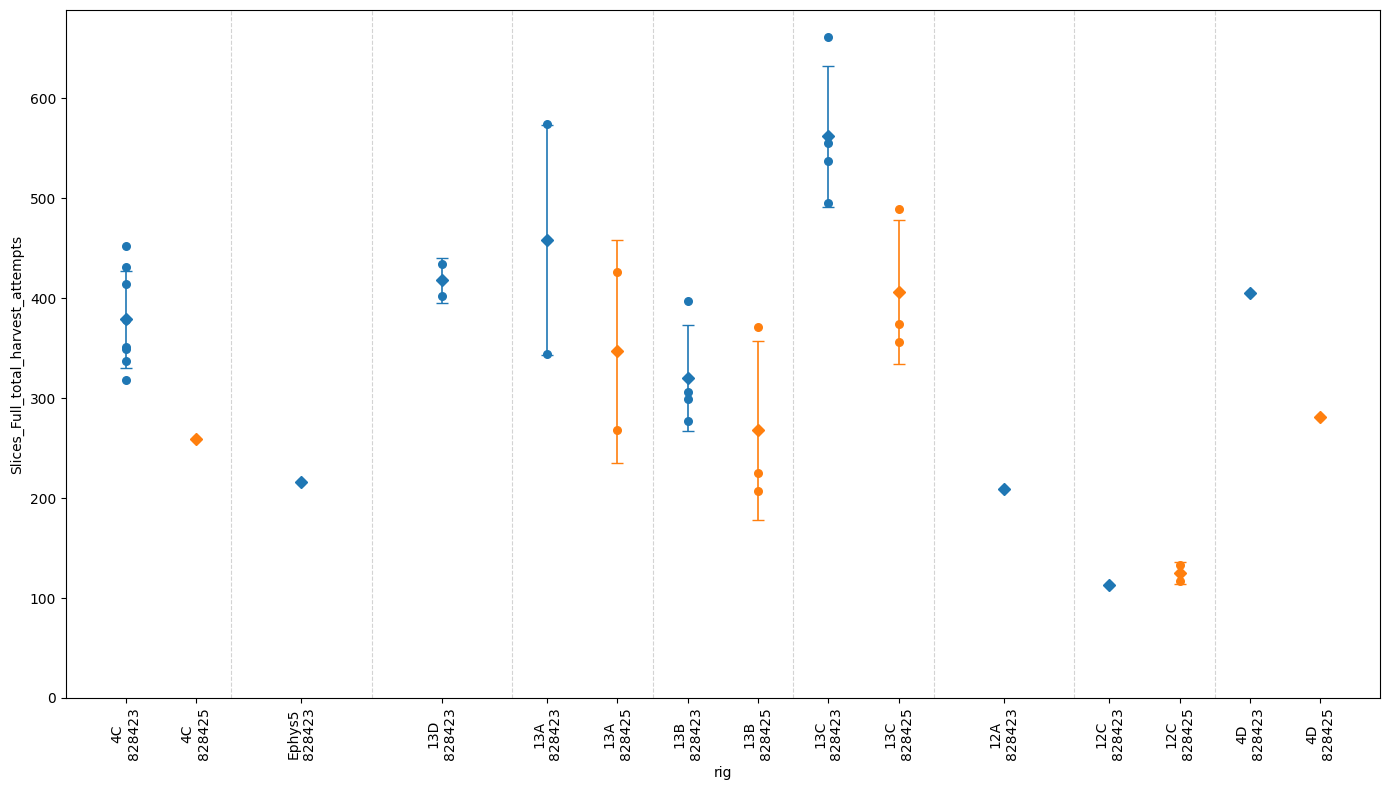

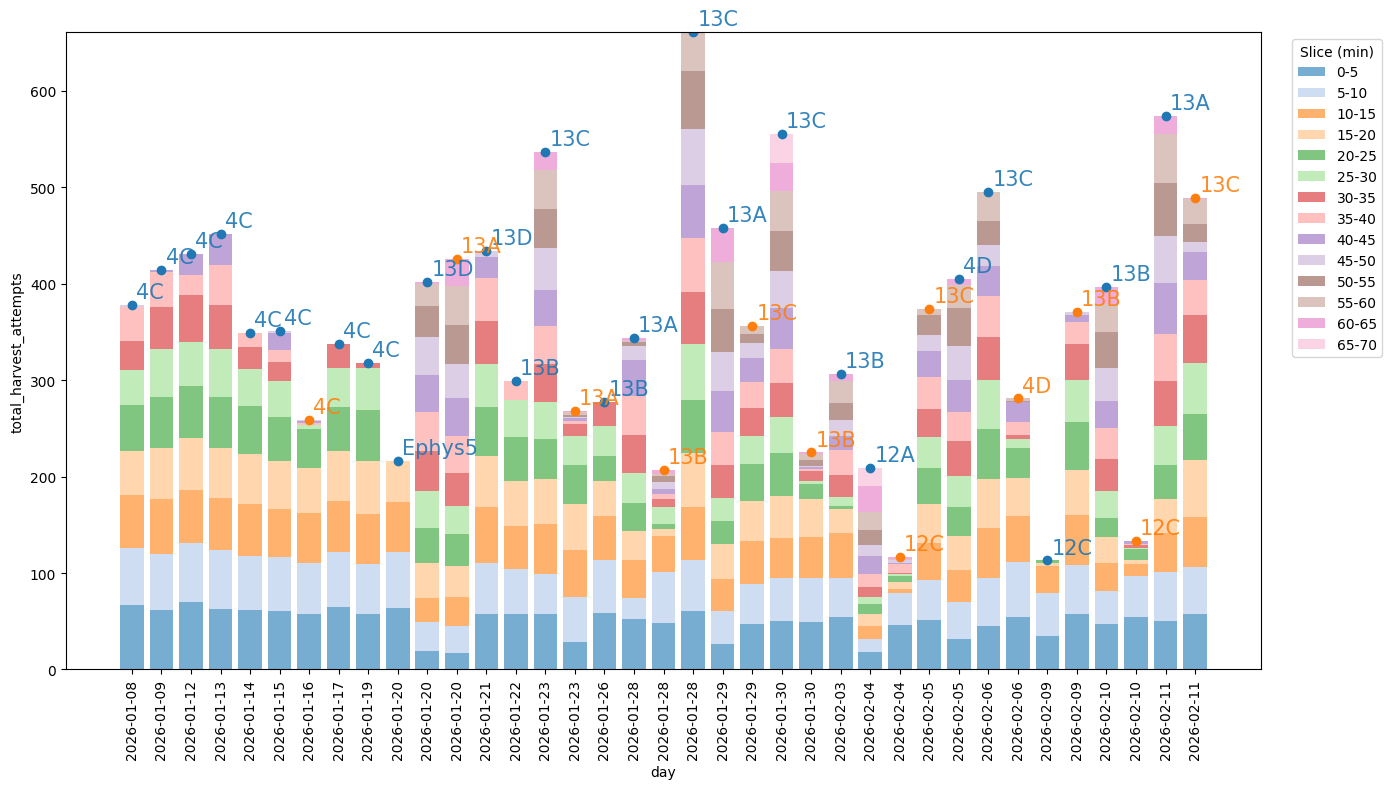

In [ ]:
dir = Path(r"C:/Data/")
tests_dir = Path(os.path.join(dir, "Tests"))
save_img_path = os.path.join(dir, "img/") # Comment to skip saving

# Load Summaries
def load_json_summaries(tests_dir:Path) -> pd.DataFrame:
    
    def flatten_json(d: dict, parent_key: str = "", sep: str = "_") -> dict:
        items = []
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k

            if isinstance(v, dict):
                items.extend(flatten_json(v, new_key, sep=sep).items())
            else:
                items.append((new_key, v))

        return dict(items)
    
    rows = []
    for session_dir in tests_dir.iterdir():
        acq_file = session_dir / "acquisition.json"
        acq_file2 = session_dir / "acquisition_vrforaging.json"
        summary_file = session_dir / "summary.json"

        if not summary_file.exists():
            continue
        
        if acq_file.exists():
            with open(acq_file) as f:
                acq = json.load(f)
        elif acq_file2.exists():
            with open(acq_file2) as f:
                acq = json.load(f)    
        else:
            continue  
        
        with open(summary_file) as f:
            summary = json.load(f)

        # --- Session time ---
        start = pd.Timestamp(acq["acquisition_start_time"])
        end = pd.Timestamp(acq["acquisition_end_time"])
        duration_min = (end - start).total_seconds() / 60
        day = start.date()
        
        # --- Flatten summary ---
        flat_summary = flatten_json(summary)

        row = {
            "session": session_dir.name,
            "rig": acq["instrument_id"],
            "mouse_n": acq["subject_id"],
            "experimenter": ",".join(acq.get("experimenters", [])),
            "day": day,
            "duration_min": round(duration_min, 1),
            **flat_summary
        }
        rows.append(row)
        if verbose: print(f"Loaded summary for {session_dir.name}")
        
    df = pd.DataFrame(rows)
    df = df.sort_values("day")
    df["session_idx"] = range(len(df))
    return df

# --- Plotting primitives ---
def plot_metric(df: pd.DataFrame, metric: str, x_col: str, tag_col: str, save_img_path: str | None = None) -> None:
    """Plot `metric` vs `x_col` for each mouse (grouped by 'mouse_n'), annotate with `tag_col` if present, and optionally save the figure."""
    fig, ax = plt.subplots(figsize = (14, 8))


    categories = df[x_col].drop_duplicates().tolist()
    pos_map = {c: i for i, c in enumerate(categories)} # Uniform spacing between x axis columns

    for inst, g in df.groupby("mouse_n"):
        g = g.sort_values(x_col)
        x = g[x_col].map(pos_map)  
        y = g[metric]
        line, = ax.plot(x, y, marker="o")
        color = line.get_color()
        if tag_col in g.columns: annotate_points(ax, x, y, g[tag_col], color=color)
    
    ax.set_title(f"{metric}")
    ax.set_ylabel(metric)
    ax.set_xlabel(x_col)
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=90)
    y_min, y_max = plt.ylim()
    plt.ylim(bottom = min(y_min, 0))
    plt.legend()
    plt.tight_layout()
    plt.show()
    if save_img_path: 
        fig.savefig(os.path.join(save_img_path, metric.replace('/', '-')), dpi=175, bbox_inches='tight')

def plot_series(df: pd.DataFrame, metric: str, cols: dict, x_col: str, tag_col: str, save_img_path: str | None = None) -> None:
    """Plot a per-mouse line of `cols['mean']` vs `x_col` with optional std errorbars and min/max band, annotate with `tag_col`, and optionally save."""
    fig, ax = plt.subplots(figsize = (14, 8)) 
    categories = df[x_col].drop_duplicates().tolist()
    pos_map = {c: i for i, c in enumerate(categories)}

    for inst, g in df.groupby("mouse_n"):
        g = g.sort_values(x_col)
        x = g[x_col].map(pos_map)  
        mean_vals = g[cols["mean"]]
        line, = ax.plot(x, mean_vals, marker="o", label=f"{inst}")
        color = line.get_color()
        if "std" in cols:
            ax.errorbar(x, mean_vals, yerr=g[cols["std"]], fmt="none", ecolor=color, capsize=3, alpha=0.8)
        if "min" in cols and "max" in cols:
            ax.fill_between(x, g[cols["min"]], g[cols["max"]], alpha=0.30, color = color)
        # annotate per mouse line
        if tag_col in g.columns: annotate_points(ax, x, mean_vals, g[tag_col], color=color)
        
    ax.set_xlabel(x_col)
    ax.set_ylabel(metric)
    categories = df[x_col].drop_duplicates().tolist()
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=90)

    y_min, y_max = plt.ylim()
    plt.ylim(bottom = min(y_min, 0))
    plt.legend()
    plt.tight_layout()
    plt.show()
    if save_img_path: 
        fig.savefig(os.path.join(save_img_path, f"a_{metric.replace('/', '-')}"), dpi=175, bbox_inches='tight')

def plot_slices(df: pd.DataFrame, metric: str, x_col: str, tag_col: str, save_img_path: str | None = None) -> None:
    """ Plot stacked slice bars of `{metric}` from columns named like `Slices_<start>-<end>_<metric>`    """

    prefix = "Slices_"
    full_col = f"Slices_Full_{metric}"

    # Collect slice columns for this metric (exclude 'Full')
    slice_cols = [c for c in df.columns if c.startswith(prefix) and c.endswith("_" + metric) and c != full_col]
    if not slice_cols:
        return

    # Helpers
    def _extract_label(col: str) -> str:
        return col[len(prefix):-len("_" + metric)]

    def _parse_bounds(label: str):
        a, b = label.split("-", 1)
        unit:str = "%" if (label.endswith("%")) else "min"
        a = a.replace("%", ""); b = b.replace("%", "")
        try:
            return float(a), float(b), unit
        except ValueError:
            return 0.0, 0.0, unit

    # Parse all slices (preserve column order)
    parsed = []  # (start, end, unit, label, column)
    for column in slice_cols:
        label = _extract_label(column)
        start, end, unit = _parse_bounds(label)
        parsed.append((start, end, unit, label, column))

    # Detect the slice width and the unit used in this DataFrame
    start, end, unit, _, _ = parsed[0]
    slice_width = end - start


    # Group columns by start bucket (rounded to int to absorb tiny float noise)
    groups = {}
    for s, _, _, _, c in parsed:
        key = int(round(s))
        groups.setdefault(key, []).append(c)

    # Prepare figure
    fig, ax = plt.subplots(figsize=(14, 8))
    x = np.arange(len(df[x_col]))
    bottom = np.zeros(len(df), dtype=float)

    # Color map: one color per start bucket
    cmap = plt.get_cmap("tab20")
    def _color_for(i: int):
        return cmap(i % cmap.N)

    # Stack in ascending start order
    starts_sorted = sorted(groups.keys())
    for i, start_key in enumerate(starts_sorted):
        cols = groups[start_key]
        # Collapse multiple variants for same start (use max per-row to avoid double-counting)
        vals = df[cols].max(axis=1, skipna=True).values
        color = _color_for(i)
        start_lbl = int(start_key)
        end_lbl = int(round(start_key + slice_width))
        label = f"{start_lbl}-{end_lbl}{'%' if unit == '%' else ''}"
        ax.bar(x, vals, bottom=bottom, color=color, alpha=0.6, label=label)
        bottom[:] = bottom + np.nan_to_num(vals, nan=0.0)

    # Overlay one FULL line per mouse_n (no legend entry)
    if full_col in df.columns and "mouse_n" in df.columns:
        for mouse, g in df.groupby("mouse_n"):
            idx = df.index.get_indexer(g.index)
            line, = ax.plot(idx, g[full_col], marker="o", linestyle="-", linewidth=0)
            color = line.get_color()
            if tag_col in g.columns:
                annotate_points(ax, idx, g[full_col].values, g[tag_col], color=color)

    # Axes & legend
    ax.set_xticks(x)
    ax.set_xticklabels(df[x_col], rotation=90)
    ax.set_xlabel(x_col)
    ax.set_ylabel(f"{metric}")

    handles, labels = ax.get_legend_handles_labels()
    # De-duplicate labels (safety)
    seen, new_h, new_l = set(), [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l); new_h.append(h); new_l.append(l)
    ax.legend(new_h, new_l, title=f"Slice ({unit})", ncol=1, frameon=True, loc="upper left", bbox_to_anchor=(1.02, 1.0))

    plt.tight_layout()
    plt.show()

    if save_img_path:
        fig.savefig(os.path.join(save_img_path, f"s_{metric.replace('/', '-')}"), dpi=175, bbox_inches='tight')

def scatter_by_rig_with_subcolumns(df: pd.DataFrame, metric:str) -> None:
    """
    Scatter plot of `metric` organized by rig on x-axis, with each mouse_n as a sub-column within each rig.
    Plots all session points, plus the mean ± std for each (rig, mouse_n) subgroup.
    """
    # --- Prepare ordering: rigs by first appearance; mice by first appearance within each rig ---
    x_in_order = df["rig"].astype(str).drop_duplicates().tolist()

    # For consistent "subcolumns", collect mouse order per rig (appearance order within each rig)
    mice_per_rig = {}
    for rig in x_in_order:
        g = df[df["rig"].astype(str) == str(rig)]
        mice_per_rig[rig] = g["mouse_n"].astype(str).drop_duplicates().tolist()

    # --- Set up plot ---
    fig, ax = plt.subplots(figsize=(14, 8))
    color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
         '#7f7f7f', '#bcbd22', '#17becf']

    # To hold tick positions and labels for the x-axis
    xtick_pos = []
    xtick_lab = []

    # --- Draw per rig ---
    for r_idx, rig in enumerate(x_in_order):
        rig_center = r_idx 
        mice = sorted(mice_per_rig[rig])
        n_mice = len(mice)

        # Precompute offsets for mice inside this rig, centered around rig_center
        offsets = []
        for i in range(n_mice):
            offsets.append((i - (n_mice - 1) / 2.0) /n_mice)
        print(offsets)

        # Draw a faint separator between rigs (except before the first one)
        if r_idx > 0:
            ax.axvline(rig_center - 0.5, color='lightgray', linestyle='--', linewidth=0.8, zorder=0)

        # --- For each mouse in this rig: scatter points + mean ± std ---
        for i, mouse in enumerate(mice):
            x_pos = rig_center + offsets[i]

            # Subgroup data
            sg = df[(df["rig"].astype(str) == str(rig)) & (df["mouse_n"].astype(str) == str(mouse))]
            y_vals = sg[metric].dropna()

            # Scatter all session points
            if not y_vals.empty:
                # Mean and std (errorbar)
                m = y_vals.mean()
                s = y_vals.std()  # NaN-safe; if only one point, std is NaN and errorbar won't draw
                ax.errorbar(x_pos, m, yerr=s, fmt='D', markersize=6, capsize=4, linewidth=1.2, zorder=3, color=color_list[i%5])

                # Scatter points (auto color cycle)
                ax.scatter([x_pos] * len(y_vals), y_vals.values, s=30, color=color_list[i%5])



            # Collect x tick for this subcolumn (two-line label: rig on top, mouse below)
            xtick_pos.append(x_pos)
            xtick_lab.append(f"{rig}\n{mouse}")

    # --- Axes cosmetics ---
    ax.set_xlabel("rig")
    ax.set_ylabel(metric)

    # x-ticks at each subcolumn center
    ax.set_xticks(xtick_pos)
    ax.set_xticklabels(xtick_lab, rotation=90)

    # y-baseline handling (optional: keep zero visible if relevant)
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(bottom=min(0, y_min))

    fig.tight_layout()
    plt.show()

# --- Plotting Coordinator ---
def plot_grouped_metrics(df: pd.DataFrame, x_col: str = "day", tag_col: str = "rig", save_img_path: str | None = None) -> None:
    """
    Groups columns of a df depending on the type of metric (single, family or slice), then plots it accordingly. Optionally saves these figures.
        - Single metrics: Property that only has a value -> Basic line plot
        - Family Metrics: Columns that store the mean, std, min & max of the same property -> Plots it in a graph where the mean is the main line, 
                            the std is represented as err bars and the max and min are a shaded area.
        - Slice props: Properties that are stored in slices of the session -> These are drawn in a bar plot where the slices are on in top of each other
    """
    df = df.sort_values(by=x_col)

    stats_suffixes = ["mean", "std", "min", "max"]
    series_metrics, single_metrics, slice_properties = {}, [], set()

    for col in df.columns:
        for suffix in stats_suffixes:
            if col.endswith("_" + suffix):
                base = col[:-(len(suffix) + 1)]
                series_metrics.setdefault(base, {})[suffix] = col
                break
        else:
            if col.startswith("task"):
                single_metrics.append(col)
            elif col.startswith("Slices_"):
                slice_properties.add(col.split("_", 2)[-1])
    




    for base, cols in series_metrics.items():
        if "mean" in cols:
            scatter_by_rig_with_subcolumns(df, metric=cols["mean"])
            plot_series(df, base, cols, x_col, tag_col, save_img_path=save_img_path)
    for metric in single_metrics:
        scatter_by_rig_with_subcolumns(df, metric=metric)
        plot_metric(df, metric, x_col, tag_col, save_img_path=save_img_path)
    for prop in slice_properties:
        scatter_by_rig_with_subcolumns(df, metric=f"Slices_Full_{prop}")
        plot_slices(df, prop, x_col, tag_col, save_img_path=save_img_path)

    # scatter_by_rig_with_subcolumns(df, metric=metric)

df = load_json_summaries(tests_dir)    


plot_grouped_metrics(df, save_img_path=save_img_path)


## Dynamic plots

In [ ]:
def add_position(df: pd.DataFrame, position: pd.DataFrame):
    # Ensure both indices are named 'Time'
    position = position.rename_axis('Time', axis='index')
    df = df.rename_axis('Time', axis='index')

    # Cast both to float 
    df = df.copy()
    position = position.copy()
    df.index = df.index.astype(float)
    position.index = position.index.astype(float)

    # Perform merge_asof
    df = pd.merge_asof(df.sort_index(), position.sort_index(), direction='nearest', on="Time").set_index("Time").sort_index()
    df.columns = [*df.columns[:-1], 'Position']
    return df

def plot_patches(ax, navigation_mode, zero_index, _legend) -> None:
    """Plot the context patches based on the navigation mode."""
    _sites = add_position(all_epochs, position=stream_data.position_data)
    for idx, site in enumerate(all_epochs.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index'] + 1}"
            facecolor = label_dict[site_label]
        elif site_label == "OdorSite":
            site_label = site[1]['patch_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        if navigation_mode == "space":
            position = _sites["Position"].values[idx]
            width = _sites["Position"].values[idx + 1] - position
            p = Rectangle((position, -2), width, 8, linewidth=0, facecolor=facecolor, alpha=0.5)
        else:
            time_position = all_epochs.index[idx] - zero_index
            width = all_epochs.index[idx + 1] - all_epochs.index[idx]
            p = Rectangle((time_position, -2), width, 8, linewidth=0, facecolor=facecolor, alpha=0.5)

        _legend[site_label] = p
        ax.add_patch(p)

def plot_behavioral_events(ax, navigation_mode,  zero_index, _legend) -> None:
    """
    Plot the behavioral events based on the selected navigation mode.
    """
    events = [
        ("SoftReward", data['software_events'].streams['GiveReward'].data, 3.5, 'red', 'x', 400),
        ("SoftTone", data['software_events'].streams['ChoiceFeedback'].data, 2.5, 'yellow', 'x', 400),
        ('ChoiceFeedback', stream_data.choice_feedback, 2.5, 'k', 's', 100),
        ('Lick', stream_data.lick_onset, 1, 'k', '|', 100),
        ('Reward', stream_data.give_reward, 3.5, 'mediumblue', '*',100),
        ('Odor onset', odor_triggers.odor_onset, 2.5, 'pink', '|', 100),
        ('Odor offset', odor_triggers.odor_onset, 2.5, 'purple', '|', 100)
    ]
    
    for event_name, event_data, y_pos, color, marker, size in events:
        if navigation_mode == "time" or navigation_mode == "patch":
            # Plot events by time index
            _legend[event_name] = ax.scatter(event_data.index-zero_index, [y_pos] * len(event_data.index), label=event_name, color=color, marker=marker, s=size)
        else:
            # Plot events by position (space or patch mode)
            positions = add_position(event_data, stream_data.position_data)['Position'].values
            _legend[event_name] = ax.scatter(positions, [y_pos] * len(positions), label=event_name, color=color, marker=marker, s=size)

In [ ]:
# Define a dictionary to map navigation modes to corresponding limits and increments
nav_config = {
    "patch": {"increment": 1},  # For patches, we move one patch at a time
    "time": {"increment": 20},
    "space": {"increment": 750}
}

def update_plot(x_start, navigation_mode="time") -> None:
    """
    Update the plot based on the selected navigation mode (space, time, or patch).
    
    Parameters:
    ----------
    x_start : float
        The starting value for the x-axis (time or position or patch number).
    navigation_mode : str
        Mode of navigation: 'patch', 'time', or 'space'.
    """
    zero_index = all_epochs.index[0]
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(20, 4))
    
    # Get the configuration for the selected navigation mode
    nav_mode = nav_config.get(navigation_mode, nav_config["time"])  # Default to 'time' if mode is invalid
    
    if navigation_mode == "patch":
        # Get the start and end times of patches
        patch_start_times = all_epochs.loc[all_epochs['label'] == 'InterPatch'].index
        patch_end_times = patch_start_times[1:].append(pd.Index([all_epochs.index[-1]]))  # Next patch's start time as end time for the last one
        patches = list(zip(patch_start_times, patch_end_times))

        # Determine the current patch
        current_patch = int(x_start)  # Use the integer part of x_start as the patch index
        start, end = patches[current_patch]

        # Set the x-limits for the current patch
        ax.set_xlim(start - zero_index, end - zero_index)
        
    else:
        # Use the configured x-limits for time or space navigation
        ax.set_xlim(x_start, x_start + nav_mode.get("increment"))

    _legend = {}
    
    # Plot context patches (the "OdorSite", "InterPatch" regions)
    plot_patches(ax, navigation_mode, zero_index, _legend)
    
    # Plot behavioral events (e.g., ChoiceFeedback, Lick, ValveOpen)
    plot_behavioral_events(ax, navigation_mode,zero_index, _legend)
    
    # Plot the velocity curve
    ax2 = ax.twinx()
    if navigation_mode == "time" or navigation_mode == "patch":
        _legend["Velocity"] = ax2.plot(
            stream_data.encoder_data.index - zero_index,
            stream_data.encoder_data.filtered_velocity,
            c="k", label="Velocity", alpha=0.8
        )[0]
    else:
        _legend["Velocity"] = ax2.plot(add_position(stream_data.encoder_data.filtered_velocity, position=stream_data.position_data)["Position"].values, 
                                       stream_data.encoder_data.filtered_velocity.values, c="k", label="Encoder", alpha = 0.8)[0]
    
    
    # Customize axis labels, limits, and grid
    ax.set_yticklabels([])
    ax.set_yticks([])
    
    ax.set_xlabel("Time (s)" if navigation_mode != "space" else "VR Space (cm)")
    ax2.set_ylabel("Velocity (cm/s)")
    ax.set_ylim(bottom=-1, top=4)
    ax.set_yticks([0, 3])
    ax2.yaxis.tick_left()  # Move the ticks to the left side
    ax2.yaxis.set_label_position("left")  # Place the label on the left side
    ax.grid(False)
    ax2.set_ylim((-10, 70))
    ax.legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)

# Define callback functions for the arrow buttons with different navigation logic based on the plot type
def on_left_button_clicked(button) -> None:
    # Adjust the x_start based on the selected navigation mode
    if navigation_mode_widget.value == "patch":
        x_start_widget.value -= 1  # Go to the previous patch
    else:
        x_start_widget.value -= nav_config[navigation_mode_widget.value]["increment"]  # Go left by increment

def on_right_button_clicked(button) -> None:
    # Adjust the x_start based on the selected navigation mode
    if navigation_mode_widget.value == "patch":
        x_start_widget.value += 1  # Go to the next patch
    else:
        x_start_widget.value += nav_config[navigation_mode_widget.value]["increment"]  # Go right by increment

def save_plot(button) -> None:
    fig, ax = update_plot(x_start_widget.value)  # Get the current plot
    save_name = "current_plot.png"  # Define the filename (you can modify this as needed)
    
    fig.savefig(save_name, bbox_inches='tight', pad_inches=0.1, transparent=True)
    print(f"Plot saved as {save_name}")
    
# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Create Save button
save_button = widgets.Button(description='Save Plot')

# Set the save button click event handler
save_button.on_click(save_plot)

# Define widget for the starting value of x-axis (space, time, or patch number)
x_start_widget = widgets.FloatText(value=0.0, description='X start:', continuous_update=False)

# Dropdown to select navigation mode (Space, Time, Patch)
navigation_mode_widget = widgets.Dropdown(
    options=['time', 'space','patch'],
    value='patch',
    description='Nav Mode:',
    disabled=False
)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button, navigation_mode_widget, save_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget, 'navigation_mode': navigation_mode_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)


### Segments of the session with sniff data

Explore data but having the sniff data on top (it takes longer to plot)

In [ ]:
breathing_data = processing.fir_filter(stream_data.breathing, 'data', 100)
breathing_data = stream_data.breathing

In [ ]:
def update_plot(x_start) -> None:
    zero_index = all_epochs.index[0]

    fig, axs = plt.subplots(2,1, figsize=(12,6), gridspec_kw={'height_ratios': [2, 3]}, sharex=True)

    # sites_test = sites.loc[(sites.index > (zero_index + x_start))&(sites.index < (zero_index + x_start + 50))]   
    _legend = {}
    for idx, site in enumerate(all_epochs.iloc[:-1].iterrows()):
        site_label = site[1]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "OdorSite":
            site_label = site[1]['patch_label']
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (all_epochs.index[idx] - zero_index, -2), all_epochs.index[idx+1] - all_epochs.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        
        _legend[site_label] = p
        axs[0].add_patch(p)
        
        q = Rectangle(
            (all_epochs.index[idx] - zero_index, -2), all_epochs.index[idx+1] - all_epochs.index[idx], 8,
            linewidth = 0, facecolor = facecolor, alpha = .5)
        _legend[site_label] = q
        axs[1].add_patch(q)
        # axs[1].add_patch(p)
        
    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs[1].scatter(stream_data.choice_feedback.index - zero_index+0.2,
            stream_data.choice_feedback.index * 0 + y_idx,
            marker="s", s=100, lw=lw, c='darkblue',
            label="Choice Tone")
    y_idx += 1
    _legend["Lick"] = axs[1].scatter(stream_data.lick_onset.index - zero_index,
            stream_data.lick_onset.index * 0 + y_idx,
            marker="|", s=s, lw=lw, c='k',
            label="Lick")
    _legend["Reward"] = axs[1].scatter(stream_data.give_reward.index - zero_index,
            stream_data.give_reward.index*0 + y_idx,
            marker=".", s=s, lw=lw, c='deepskyblue',
            label="Reward")
    # _legend["Waits"] = axs[1].scatter(stream_data.successfull_wait.index - zero_index,
    #     stream_data.successfull_wait.index*0 + 1.2,
    #     marker=".", s=s, lw=lw, c='green',
    #     label="Reward")
    # _legend["Odor_on"] = axs.scatter(odor_on - zero_index,
    #     odor_on*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")
    
    # _legend["Odor_off"] = axs.scatter(odor_off - zero_index,
    #     odor_off*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")
    
    y_idx += 1

    #ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs[1].set_yticklabels([])
    axs[1].set_xlabel("Time(s)")
    axs[1].set_ylim(bottom=-1, top = 3)
    axs[1].grid(False)

    ax2 = axs[1].twinx()
    _legend["Velocity"] = ax2.plot(stream_data.encoder_data.index - zero_index, stream_data.encoder_data.filtered_velocity, c="k", label="Encoder", alpha = 0.8)[0]
    try:
        v_thr = data['config'].streams.TaskLogic.data["operationControl"]["positionControl"]["stopResponseConfig"]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha = 0.5, lw = 2, ls = "--")[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")

    ax3 = axs[0].twinx()
    _legend["Breathing"] = ax3.plot(breathing_data.index - zero_index, breathing_data.data.values, c="black", label="Breathing", alpha = 0.8)[0]
    # _legend["Breathing"] = ax3.plot(filtered_breathing.index - zero_index, filtered_breathing['data'].values, c="black", label="Breathing", alpha = 0.8)[0]

    ax3.grid(False)
    ax3.set_ylim(stream_data.breathing.mean()[0]+100, stream_data.breathing.mean()[0]-100)
    ax3.set_ylabel("Breathing (au)")
    
    axs[0].legend(_legend.values(), _legend.keys(), bbox_to_anchor=(1.2, 0.1), loc='center left', borderaxespad=0.)

    # axs[0].stairs(software_events.streams.RewardAvailableInPatch.data["data"].values[:-1],
    #           software_events.streams.RewardAvailableInPatch.data["data"].index.values -  zero_index,
    #           lw = 3, color = 'k', fill=0)
    
    for i in [0,1]:
        axs[i].set_xlabel("Time(s)")
        axs[i].grid(False)
        axs[i].set_ylim(bottom=-1, top = 4)
        axs[i].set_yticks([])
        axs[i].yaxis.tick_right()
        axs[i].set_xlim([x_start, x_start + 2])
        
    # plt.savefig(foraging_figures + f"\{x_start_widget.value}_time_detrended.svg", bbox_inches='tight', pad_inches=0.1, transparent=True)
    
# Define callback functions for the arrow buttons
def on_left_button_clicked(button) -> None:
    x_start_widget.value -= 2

def on_right_button_clicked(button) -> None:
    x_start_widget.value += 2

# Create arrow buttons
left_button = widgets.Button(description='◄')
right_button = widgets.Button(description='►')

# Define widget for the starting value of x-axis
x_start_widget = widgets.FloatText(value=00.0, description='X start:', continuous_update=False)

# Set button click event handlers
left_button.on_click(on_left_button_clicked)
right_button.on_click(on_right_button_clicked)

# Arrange the buttons and widget horizontally
button_box = widgets.HBox([left_button, right_button])
ui = widgets.VBox([button_box, x_start_widget])

# Create interactive plot
interactive_plot = widgets.interactive_output(update_plot, {'x_start': x_start_widget})

# Display the interactive plot and UI
display(ui, interactive_plot)